# Two Sigma Other Models

This notebook runs the top publicly shared models to gain insights on how they performed, and what drove their performance.

The <a href='https://www.kaggle.com/c/two-sigma-financial-modeling/discussion/29466'>solution sharing</a> and <a href='https://smist08.wordpress.com/2017/03/07/playing-the-kaggle-two-sigma-challenge-part-4/'>blogs</a> are useful, but the details are in the code.  I review some of the models, ignoring the ones that had a high public score and dropped significantly in the private LB (<a href='https://www.kaggle.com/bencopeland/two-sigma-financial-modeling/xgb-lags-v2/run/758415/comments'>xgb_lags_v2</a>), and those with lower public score and got lucky on the private LB (<a href='https://www.kaggle.com/pranavj/two-sigma-financial-modeling/rl-with-laws-of-physics/run/864419'>RL_with_laws_of_physics</a>). I pick the following models for further inspection:
<table><tr><td><b>Team or Model</td><td><b>Public LB</td><td><b>Private LB</td><td><b>Train</td>
<td><b>Public Score</td><td><b>Private Score</td><td><b>Notes</td></tr>

<tr><td><a href='https://www.kaggle.com/c/two-sigma-financial-modeling/discussion/29793'>E2</a></td><td>15</td>
<td>8</td><td></td><td>0.0191194</td><td>0.0291539</td><td>good discussion of model approach</td></tr>

<tr><td><a href='https://www.kaggle.com/phegde/two-sigma-financial-modeling/team-pradeep-arthur-private-lb-10-solution/code'>Team Pradeep & Arthur</a></td><td>34</td><td>10</td><td>0.02873228</td><td>0.0177370</td><td>0.0287992</td><td></td></tr>

<tr><td><a href='https://www.kaggle.com/c/two-sigma-financial-modeling/discussion/29518'>The "Team Rocket"</a></td><td>4</td><td>13</td><td>0.0507</td><td>0.0226325</td><td>0.0275698</td><td></td></tr>

<tr><td><a href='https://www.kaggle.com/tks0123456789/two-sigma-financial-modeling/xgb-500-600-001/run/971599'>xgb_500_600_001</a></td><td>525</td><td>16</td><td>0.02710810</td><td>0.0060832</td><td>0.0263726</td><td>tks</td></tr>

<tr><td><a href='https://www.kaggle.com/happycube/two-sigma-financial-modeling/202-with-two-feature-xgb/run/968991'>202-with-two-feature-xgb</a></td><td>13</td><td>51</td><td>0.02341814</td><td>0.0194566</td><td>0.0197482</td><td>happycube</td></tr>


<tr><td><a href='https://www.kaggle.com/willieliao/two-sigma-financial-modeling/et1-ridge3-med-adj/run/967135'>et1_ridge3_med_adj</a></td><td>16</td><td>19</td><td>0.03768811</td><td>0.0189746</td><td>0.0254838</td><td></td></tr>

<tr><td><a href='https://www.kaggle.com/ouranos/two-sigma-financial-modeling/modelc/run/972791'>ModelC</a></td><td>398</td><td>27</td><td>0.03225601</td><td>0.0135783</td><td>0.0229201</td><td></td></tr>

<tr><td><a href='https://www.kaggle.com/happycube/two-sigma-financial-modeling/two-sigma-03-shorter-version'>two-sigma-03</a><td>28</td><td>41</td><td>0.02683961</td><td>0.0180552</td><td>0.0199284</td><td>forked from two-sigma-03 by sdfoley</td></tr>

<tr><td><a href='https://www.kaggle.com/cescfangs/two-sigma-financial-modeling/mixed-ridge-etr-xgb-private0-0252120/run/859377'>mixed_ridge_etr_xgb</a></td><td>42</td><td>42</td><td>0.02952927</td><td>0.0143345</td><td>0.0252120</td><td></td></tr>

<tr><td><a href='https://www.kaggle.com/ggrizzly/two-sigma-financial-modeling/linear-bag-1-py'>linear-bag-1</a></td><td>20</td><td>163</td><td>0.03839378</td><td>0.0188127</td><td>0.0189525</td><td></td></tr>


<tr><td><a href='https://www.kaggle.com/phegde/two-sigma-financial-modeling/reinforcement-learning-private-lb-0-0333/code'>RL</a></td><td></td><td></td><td>0.03082909</td><td>0.011</td><td>0.0333</td><td></td></tr>


<tr><td><a href='https://www.kaggle.com/trottefox/two-sigma-financial-modeling/two-sigma-playground'>two-sigma-playground</a></td><td>259</td><td>~314</td><td>0.0222019</td><td>0.0140380</td><td>0.0181243</td><td>messy</td></tr>

<!-- <tr><td><a href=''>x</a></td><td>0</td><td>0</td><td>0.0</td><td>0.0</td><td>0.0</td><td></td></tr>
-->

</table>

## Load the data

In [1]:
import kagglegym
import numpy as np
import pandas as pd
import random
import math
from sklearn import ensemble, linear_model, metrics
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
full_train = pd.HDFStore("../input/train.h5", "r").get("train")

In [3]:
# A custom function to compute the R score
import math
def get_reward(y_true, y_fit):
    R2 = 1 - np.sum((y_true - y_fit)**2) / np.sum((y_true - np.mean(y_true))**2)
    R = np.sign(R2) * math.sqrt(abs(R2))
    return(R)

from sklearn.metrics import r2_score
def r_score(y_true, y_pred, sample_weight=None, multioutput=None):
    r2 = r2_score(y_true, y_pred, sample_weight=sample_weight,
                  multioutput=multioutput)
    r = (np.sign(r2)*np.sqrt(np.abs(r2)))
    return r

In [4]:
def plot_rewards(reward_list, overall_reward_list, ts_list, market, title="Overall R"):
    fig = plt.figure(figsize=(12, 6))
    percent_positive = "{0:.2f}%".format((sum([x > 0 for x in reward_list])/len(reward_list)*100))
    overall_percent_positive = "{0:.2f}%".format((sum([x > 0 for x in overall_reward_list])/len(overall_reward_list))*100)
    overall_R = "{0:.6f}".format(overall_reward_list[-1])
    reward_line = pd.Series(reward_list, index=ts_list)
    overall_reward_line = pd.Series(overall_reward_list, index=ts_list)
    # ax = overall_reward_line.plot(lw=1, c='blue', label='overall R>0 = '+overall_percent_positive, legend=True)
    ax = plt.plot(ts_list, [0]*len(ts_list), c='orange')
    ax = market.cumsum().plot(c='r', lw=1, label='market mean', legend=True)
    ax = reward_line.plot(lw=0.5, c='grey', alpha=0.5, label='R>0 = '+percent_positive, legend=True)
    ax = reward_line.rolling(center=False,window=10).mean().plot(lw=0.5, c='black', alpha=1, label='rolling mean of R', legend=True)
    ax = overall_reward_line.plot(lw=1, c='b', label='overall R = '+overall_R, legend=True)
    plt.title(title)
    plt.show()

In [5]:
# Train Test split
test_size = 0.50
end_train = round(len(full_train.timestamp.unique())*test_size)
x_train = full_train[full_train.timestamp <= end_train]
x_test = full_train[full_train.timestamp > end_train]

In [6]:
# Keep track of market mean
train_market = x_train.groupby('timestamp').y.mean()
test_market = x_test.groupby('timestamp').y.mean()

In [7]:
import math

class Performance(object):
    
    def __init__(self, title='Model'):
        self.title = title
        self.y_actual_list = []
        self.y_pred_list = []
        self.reward_list = []
        self.overall_reward_list = []
        self.ts_list = []

    def update(self, timestamp, pred_y, reward=None):
        actual_y = list(full_train[full_train.timestamp == timestamp]["y"].values)
        self.y_actual_list.extend(actual_y)
        self.y_pred_list.extend(pred_y)
        if reward == None:
            # reward = get_reward(np.array(actual_y), np.array(pred_y))
            reward = r_score(actual_y, pred_y)
        self.reward_list.append(reward)
        # overall_reward = get_reward(np.array(self.y_actual_list), np.array(self.y_pred_list))
        overall_reward = r_score(self.y_actual_list, self.y_pred_list)
        self.overall_reward_list.append(overall_reward)
        self.ts_list.append(timestamp)

    def plot(self):
        plot_rewards(self.reward_list, self.overall_reward_list, self.ts_list, test_market, title=self.title)
        
    def to_series(self):
        s = pd.Series(self.overall_reward_list, index=self.ts_list)
        s.name = self.title
        return s
        

## Team Pradeep & Arthur
- https://www.kaggle.com/phegde/two-sigma-financial-modeling/team-pradeep-arthur-private-lb-10-solution/code

In [8]:
# import kagglegym
# import numpy as np
# import pandas as pd
import random
from sklearn import ensemble, linear_model, metrics
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.linear_model import HuberRegressor
from itertools import combinations
import gc
from threading import Thread
import multiprocessing
from multiprocessing import Manager
from sklearn import preprocessing as pp
from numpy.fft import fft
from sklearn.naive_bayes import GaussianNB


env = kagglegym.make()
o = env.reset()
train = o.train
print(train.shape)
d_mean= train.median(axis=0)


low_y_cut = -0.075
high_y_cut = 0.075
y_is_above_cut = (train.y > high_y_cut)
y_is_below_cut = (train.y < low_y_cut)
y_is_within_cut = (~y_is_above_cut & ~y_is_below_cut)  

train["nbnulls"]=train.isnull().sum(axis=1)
col=[x for x in train.columns if x not in ['id', 'timestamp', 'y']]

rnd=17

#keeping na information on some columns (best selected by the tree algorithms)
add_nas_ft=True
nas_cols=['technical_9', 'technical_0', 'technical_32', 'technical_16', 'technical_38', 
'technical_44', 'technical_20', 'technical_30', 'technical_13']

#columns kept for evolution from one month to another (best selected by the tree algorithms)
add_diff_ft=True
diff_cols=['technical_22','technical_20', 'technical_30', 'technical_13', 'technical_34']

class createLinearFeatures:
    
    def __init__(self, n_neighbours=1, max_elts=None, verbose=True, random_state=None):
        self.rnd=random_state
        self.n=n_neighbours
        self.max_elts=max_elts
        self.verbose=verbose
        self.neighbours=[]
        self.clfs=[]
        
    def fit(self,train,y):
        if self.rnd!=None:
            random.seed(self.rnd)
        if self.max_elts==None:
            self.max_elts=len(train.columns)
        list_vars=list(train.columns)
        random.shuffle(list_vars)
        
        lastscores=np.zeros(self.n)+1e15

        for elt in list_vars[:self.n]:
            self.neighbours.append([elt])
        list_vars=list_vars[self.n:]
        
        for elt in list_vars:
            indice=0
            scores=[]
            for elt2 in self.neighbours:
                if len(elt2)<self.max_elts:
                    clf=linear_model.LinearRegression(fit_intercept=False, normalize=True, copy_X=True, n_jobs=-1) 
                    clf.fit(train[elt2+[elt]], y)
                    scores.append(metrics.mean_squared_error(y,clf.predict(train[elt2 + [elt]])))
                    indice=indice+1
                else:
                    scores.append(lastscores[indice])
                    indice=indice+1
            gains=lastscores-scores
            if gains.max()>0:
                temp=gains.argmax()
                lastscores[temp]=scores[temp]
                self.neighbours[temp].append(elt)

        indice=0
        for elt in self.neighbours:
            clf=linear_model.LinearRegression(fit_intercept=False, normalize=True, copy_X=True, n_jobs=-1) 
            clf.fit(train[elt], y)
            self.clfs.append(clf)
            if self.verbose:
                print(indice, lastscores[indice], elt)
            indice=indice+1
                    
    def transform(self, train):
        indice=0
        for elt in self.neighbours:
            #this line generates a warning. Could be avoided by working and returning
            #with a copy of train.
            #kept this way for memory management
            train['neighbour'+str(indice)]=self.clfs[indice].predict(train[elt])
            indice=indice+1
        return train
    
    def fit_transform(self, train, y):
        self.fit(train, y)
        return self.transform(train)

class huber_linear_model():
    def __init__(self):

        self.bestmodel=None
        self.scaler = pp.MinMaxScaler()
       
    def fit(self, train, y):

        indextrain=train.dropna().index
        tr = self.scaler.fit_transform(train.ix[indextrain])
        self.bestmodel = HuberRegressor().fit(tr, y.ix[indextrain])
        

    def predict(self, test):
        te = self.scaler.transform(test)
        return self.bestmodel.predict(te)

class LGB_model():
    def __init__(self, num_leaves=25, feature_fraction=0.6, bagging_fraction=0.6):
        self.lgb_params = {
                'task': 'train',
                'boosting_type': 'gbdt',
                'objective': 'regression',
                'metric': {'l2'},
                'learning_rate': 0.05,
                'bagging_freq': 5,
                'num_thread':4,
                'verbose': 0
            }
        
        self.lgb_params['feature_fraction'] = feature_fraction
        self.lgb_params['bagging_fraction'] = bagging_fraction
        self.lgb_params['num_leaves'] = num_leaves
        

        self.bestmodel=None
       
    def fit(self, train, y):
        
        X_train, X_val, y_train, y_val = train_test_split(train, y, test_size=0.2, random_state=343)
        
        lgtrain = lgb.Dataset(X_train, y_train)
        lgval = lgb.Dataset(X_val, y_val, reference=lgtrain)
                
        self.bestmodel = lgb.train(self.lgb_params,
                                    lgtrain,
                                    num_boost_round=100,
                                    valid_sets=lgval,
                                    verbose_eval=False,
                                    early_stopping_rounds=5)


    def predict(self, test):
        return self.bestmodel.predict(test, num_iteration=self.bestmodel.best_iteration)

def calcHuberParallel(df_train, train_cols, result):
    model=huber_linear_model()
    model.fit(df_train.loc[:,train_cols], df_train.loc[:, 'y'])
    residual = abs(model.predict(df_train[train_cols].fillna(d_mean))-df_train.y)
    
    result.append([model, train_cols, residual])
    
    return 0


if add_nas_ft:
    for elt in nas_cols:
        train[elt + '_na'] = pd.isnull(train[elt]).apply(lambda x: 1 if x else 0)
        #no need to keep columns with no information
        if len(train[elt + '_na'].unique())==1:
            print("removed:", elt, '_na')
            del train[elt + '_na']
            nas_cols.remove(elt)


if add_diff_ft:
    train=train.sort_values(by=['id','timestamp'])
    for elt in diff_cols:
        #a quick way to obtain deltas from one month to another but it is false on the first
        #month of each id
        train[elt+"_d"]= train[elt].rolling(2).apply(lambda x:x[1]-x[0]).fillna(0)
    #removing month 0 to reduce the impact of erroneous deltas
    train=train[train.timestamp!=0]

print(train.shape)
cols=[x for x in train.columns if x not in ['id', 'timestamp', 'y']]


cols2fit=['technical_22','technical_20', 'technical_30_d', 'technical_20_d', 'technical_30', 
          'technical_13', 'technical_34']

models=[]
columns=[]
residuals=[]

num_threads = 4
result = Manager().list()
threads = []

for (col1, col2) in combinations(cols2fit, 2):
    print("fitting Huber model on ", [col1, col2])
    threads.append(multiprocessing.Process(target=calcHuberParallel, args=(train, [col1, col2], result)))

    if (len(threads) == num_threads):
        for thread in threads:
            thread.start()
    
        for thread in threads:
            thread.join()
        
        print(len(result))
        
        threads = []
        
        
''' Last bit '''
print("running last threads ..")
if (len(threads)>0):
    for thread in threads:
        thread.start()

    for thread in threads:
        thread.join()
    print(len(result))
    
    threads = []


for data in result:
    model, train_cols, residual = data
    models.append(model)
    columns.append(train_cols)
    residuals.append(residual) 

del result, threads
gc.collect()



train=train.fillna(d_mean)

print("adding new features")
featureexpander=createLinearFeatures(n_neighbours=20, max_elts=2, verbose=True, random_state=rnd)
index2use=train[abs(train.y)<0.086].index
featureexpander.fit(train.ix[index2use,cols],train.ix[index2use,'y'])
trainer=featureexpander.transform(train[cols])

treecols=trainer.columns

print("training LGB model ")
num_leaves = [70]
feature_fractions = [0.2, 0.6]
bagging_fractions = [0.7]

#with Timer("running LGB models "):
for num_leaf in num_leaves:
    for feature_fraction in feature_fractions:
        for bagging_fraction in bagging_fractions:
            print("fitting LGB tree model with ", num_leaf, feature_fraction, bagging_fraction)
            model = LGB_model(num_leaves=num_leaf, feature_fraction=feature_fraction, bagging_fraction=bagging_fraction)
            model.fit(trainer,train.y)
            models.append(model)
            columns.append(treecols)
            residuals.append(abs(model.predict(trainer)-train.y))

print("training trees")
model = ensemble.ExtraTreesRegressor(n_estimators=100, max_depth=4, n_jobs=-1, random_state=rnd, verbose=0)
model.fit(trainer,train.y)
print(pd.DataFrame(model.feature_importances_,index=treecols).sort_values(by=[0]).tail(30))
for elt in model.estimators_:
    models.append(elt)
    columns.append(treecols)
    residuals.append(abs(elt.predict(trainer)-train.y))

num_to_keep=7
targetselector=np.array(residuals).T
targetselector=np.argmin(targetselector, axis=1)
print("selecting best models:")
print(pd.Series(targetselector).value_counts().head(num_to_keep))

tokeep=pd.Series(targetselector).value_counts().head(num_to_keep).index
tokeepmodels=[]
tokeepcolumns=[]
tokeepresiduals=[]
for elt in tokeep:
    tokeepmodels.append(models[elt])
    tokeepcolumns.append(columns[elt])
    tokeepresiduals.append(residuals[elt])


for modelp in tokeepmodels:
    print("")
    print(modelp)


#creating a new target for a model in charge of predicting which model is best for the current line
targetselector=np.array(tokeepresiduals).T
targetselector=np.argmin(targetselector, axis=1)

#with Timer("Training ET selection model "):
print("training selection model")
modelselector = ensemble.ExtraTreesClassifier(n_estimators= 120, max_depth=4, n_jobs=-1, random_state=rnd, verbose=0)
modelselector.fit(trainer, targetselector)

model2 = GaussianNB()
model2.fit(trainer,targetselector)

print(pd.DataFrame(modelselector.feature_importances_,index=treecols).sort_values(by=[0]).tail(30))


lastvalues=train[train.timestamp==max(train.timestamp)][['id']+diff_cols].copy()

print("end of training, now predicting")
indice=0
countplus=0
rewards=[]


del models
del columns
del residuals
del tokeepresiduals
gc.collect()

p = Performance('Team Pradeep & Arthur')
while True:
    indice+=1
    test = o.features
    test["nbnulls"]=test.isnull().sum(axis=1)
    if add_nas_ft:
        for elt in nas_cols:
            test[elt + '_na'] = pd.isnull(test[elt]).apply(lambda x: 1 if x else 0)
    test=test.fillna(d_mean)
    
    timestamp = o.features.timestamp[0]

    pred = o.target
    if add_diff_ft:
        #creating deltas from lastvalues
        indexcommun=list(set(lastvalues.id) & set(test.id))
        lastvalues=pd.concat([test[test.id.isin(indexcommun)]['id'],
            pd.DataFrame(test[diff_cols][test.id.isin(indexcommun)].values-lastvalues[diff_cols][lastvalues.id.isin(indexcommun)].values,
            columns=diff_cols, index=test[test.id.isin(indexcommun)].index)],
            axis=1)
        #adding them to test data    
        test=test.merge(right=lastvalues, how='left', on='id', suffixes=('','_d')).fillna(0)
        #storing new lastvalues
        lastvalues=test[['id']+diff_cols].copy()
    
    testid=test.id
    test=featureexpander.transform(test[cols])
    #prediction using modelselector and models list
    selected_prediction = modelselector.predict_proba(test.loc[: ,treecols])
    selected_prediction2 = model2.predict_proba(test.loc[: ,treecols])
    for ind,elt in enumerate(tokeepmodels):
        pred['y']+= (selected_prediction[:,ind]*elt.predict(test[tokeepcolumns[ind]])*1.00) +  (selected_prediction2[:,ind]*elt.predict(test[tokeepcolumns[ind]])*0.05)
    
    
    pred['y'] = pred['y'].clip(low_y_cut, high_y_cut)

    o, reward, done, info = env.step(pred)

    p.update(timestamp, pred.y)
    
    rewards.append(reward)
    if reward>0:
        countplus+=1
    
    if indice%100==0:
        print(indice, countplus, reward, np.mean(rewards), info)
        
    if done:
        print(info["public_score"])
        break

(806298, 111)
(805548, 126)
fitting Huber model on  ['technical_22', 'technical_20']
fitting Huber model on  ['technical_22', 'technical_30_d']
fitting Huber model on  ['technical_22', 'technical_20_d']
fitting Huber model on  ['technical_22', 'technical_30']
4
fitting Huber model on  ['technical_22', 'technical_13']
fitting Huber model on  ['technical_22', 'technical_34']
fitting Huber model on  ['technical_20', 'technical_30_d']
fitting Huber model on  ['technical_20', 'technical_20_d']
8
fitting Huber model on  ['technical_20', 'technical_30']
fitting Huber model on  ['technical_20', 'technical_13']
fitting Huber model on  ['technical_20', 'technical_34']
fitting Huber model on  ['technical_30_d', 'technical_20_d']
12
fitting Huber model on  ['technical_30_d', 'technical_30']
fitting Huber model on  ['technical_30_d', 'technical_13']
fitting Huber model on  ['technical_30_d', 'technical_34']
fitting Huber model on  ['technical_20_d', 'technical_30']
16
fitting Huber model on  ['tech

/Users/paulperry/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


training LGB model 
fitting LGB tree model with  70 0.2 0.7
fitting LGB tree model with  70 0.6 0.7
training trees
                        0
neighbour6       0.006812
technical_27     0.007006
nbnulls          0.008128
fundamental_8    0.008357
technical_40     0.008388
technical_35     0.009483
neighbour7       0.010175
neighbour14      0.010812
technical_38_na  0.010971
technical_7      0.011398
technical_9_na   0.013263
fundamental_53   0.014775
technical_0_na   0.014926
fundamental_58   0.015279
technical_21     0.016368
neighbour11      0.016508
technical_30_d   0.017917
technical_17     0.018322
technical_32_na  0.018579
technical_19     0.019582
technical_20_d   0.020087
technical_44_na  0.022489
technical_6      0.028747
technical_43     0.029849
technical_2      0.048886
technical_11     0.066119
neighbour5       0.068703
technical_20     0.071286
fundamental_11   0.073991
technical_30     0.139133
selecting best models:
3     66688
0     55531
78    50443
1     42418
22    41

/Users/paulperry/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


100 12 0.0375496597905 -0.125039861849 {}
200 28 -0.175384233154 -0.117211392717 {}
300 43 -0.0414264812837 -0.116166033898 {}
400 57 -0.141508011548 -0.117299532243 {}
500 69 -0.126447123884 -0.118342607615 {}
600 78 -0.121573112976 -0.117775631732 {}
700 94 -0.242404765339 -0.123863212522 {}
800 106 -0.0961658637447 -0.126563068459 {}
900 118 -0.14463884852 -0.126680853373 {}
0.0287322898343


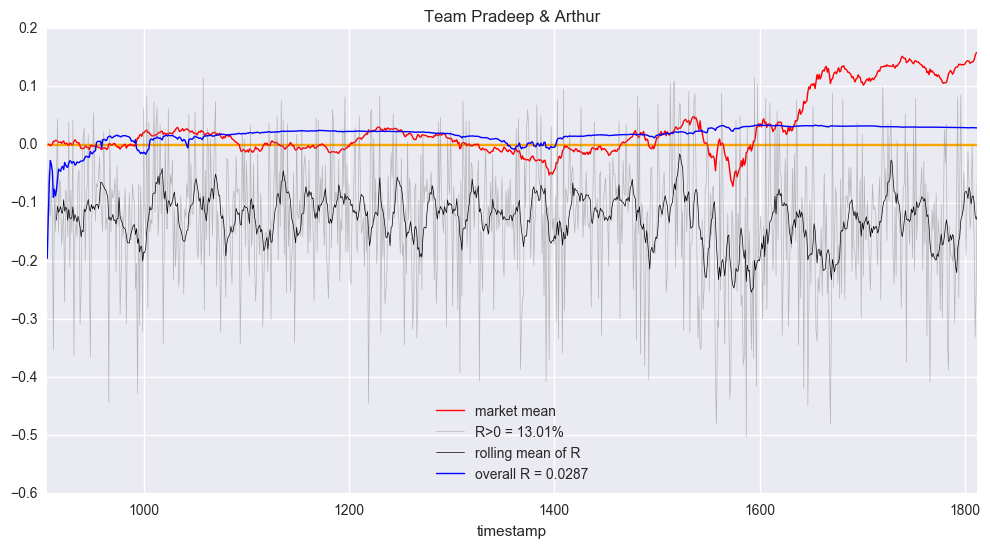

In [9]:
p.plot()

## xgb_500_600_001
- https://www.kaggle.com/tks0123456789/two-sigma-financial-modeling/xgb-500-600-001/run/971599

In [27]:
import kagglegym
import numpy as np
import pandas as pd
import xgboost as xgb

env = kagglegym.make()
o = env.reset()

excl = ['id', 'sample', 'y', 'timestamp']
cols = [c for c in o.train.columns if c not in excl]

roll_std = o.train.groupby('timestamp').y.mean().rolling(window=10).std().fillna(0)
train_idx = o.train.timestamp.isin(roll_std[roll_std < 0.009].index)

y_train = o.train['y'][train_idx]
xgmat_train = xgb.DMatrix(o.train.loc[train_idx, cols], label=y_train)

# exp070
params_xgb = {'objective'        : 'reg:linear',
              'tree_method'      : 'hist',
              'grow_policy'      : 'depthwise',
              'eta'              : 0.05,
              'subsample'        : 0.6,
              'max_depth'        : 10,
              'min_child_weight' : y_train.size/2000,
              'colsample_bytree' : 1, 
              'base_score'       : y_train.mean(),
              'silent'           : True,
}
n_round = 16

bst_lst = []
for i in range(8):
    params_xgb['seed'] = 2429 + 513 * i
    bst_lst.append(xgb.train(params_xgb,
                             xgmat_train,
                             num_boost_round=n_round,
                             # __copy__ reduce memory consumption?
                             verbose_eval=False).__copy__())

p2 = Performance('xgb_500_600_001')

while True:
    pr_lst = []
    xgmat_test = xgb.DMatrix(o.features[cols])
    for bst in bst_lst:
        pr_lst.append(bst.predict(xgmat_test))

    pred = o.target
    pred['y'] = np.array(pr_lst).mean(0)
    ts = o.features.timestamp[0]
    o, reward, done, info = env.step(pred)
    
    p2.update(ts, pred.y)
    
    if done:
        print(info)
        break
    if o.features.timestamp[0] % 100 == 0:
        print(ts, reward)


-0.312770128741
-0.184532128192
-0.164223981578
-0.0250062891868
-0.11763065231
-0.172457823234
-0.1879605511
-0.315263946764
0.0403268649474
{'public_score': 0.027108100733649412}


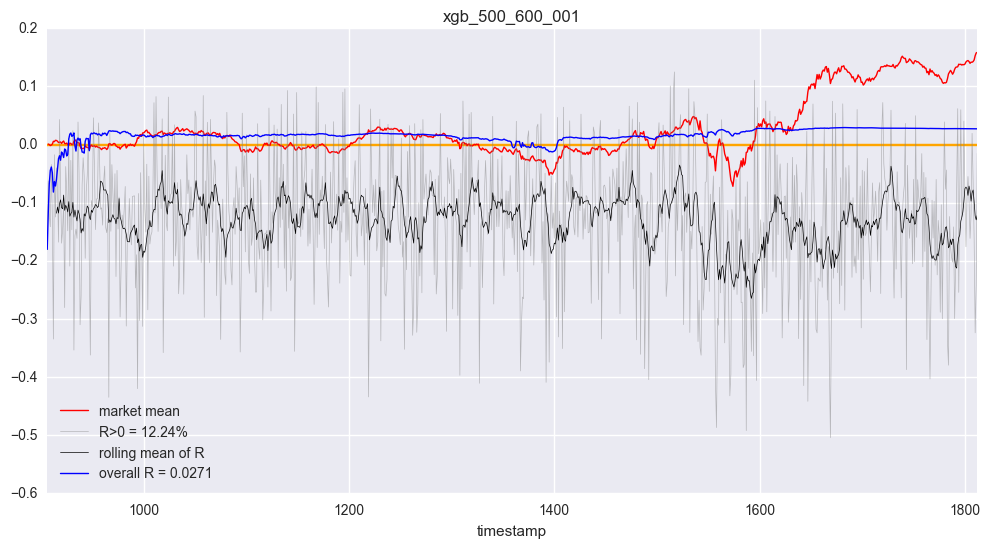

In [28]:
p2.plot()

## 202-with-two-feature-xgb by happycube
- https://www.kaggle.com/happycube/two-sigma-financial-modeling/202-with-two-feature-xgb/run/968991
- https://www.kaggle.com/happycube/two-sigma-financial-modeling/lightly-annotated-final-submission-13-51

In [16]:
import kagglegym
import numpy as np
import pandas as pd
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import xgboost as xgb
import math

import time

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge

from operator import itemgetter

localrun = False
usepublic = False
vmode = False
all_features = False # use w/vmode for feature selection.  run twice, cutting # of rounds to peak round

# This is taken from Frans Slothoubers post on the contest discussion forum.
# https://www.kaggle.com/slothouber/two-sigma-financial-modeling/kagglegym-emulation

def r_score(y_true, y_pred, sample_weight=None, multioutput=None):
    r2 = r2_score(y_true, y_pred, sample_weight=sample_weight,
                  multioutput=multioutput)
    r = (np.sign(r2)*np.sqrt(np.abs(r2)))
    if r <= -1:
        return -1
    else:
        return r

# From the xgboost script (along with the param settings)
    
# Function XGBOOST ########################################################
def xgb_obj_custom_r(y_pred, dtrain):
    y_true = dtrain.get_label()
    y_mean = np.mean(y_true)
    y_median = np.median(y_true)
    c1 = y_true
    #c1 = y_true - y_mean
    #c1 = y_true - y_median
    grad = 2*(y_pred-y_true)/(c1**2)
    hess = 2/(c1**2)
    return grad, hess

def xgb_eval_custom_r(y_pred, dtrain):
    #y_pred = np.clip(y_pred, -0.075, .075)
#    y_pred[y_pred > .075] = .075
#    y_pred[y_pred < -.075] = -.075
    y_true = dtrain.get_label()
    ybar = np.sum(y_true)/len(y_true)
    ssres = np.sum((y_true - y_pred) ** 2)
    sstot = np.sum((y_true - ybar)**2)
    r2 = 1 - ssres/sstot
    error = np.sign(r2) * np.absolute(r2)**0.5
    return 'error', error

env = kagglegym.make()
o = env.reset()

#excl = [env.ID_COL_NAME, env.SAMPLE_COL_NAME, env.TARGET_COL_NAME, env.TIME_COL_NAME]
excl = ['id', 'sample', 'y', 'timestamp']
basecols = [c for c in o.train.columns if c not in excl]


rcol_orig = ['Dtechnical_20', 'y_prev_pred_avg_diff', 'Dtechnical_21', 'technical_43_prev', 'technical_20', 'y_prev_pred_avgT0', 'y_prev_pred_mavg5', 'y_prev_pred_avgT1', 'fundamental_8_prev', 'Dtechnical_40', 'technical_7_prev', 'technical_7', 'fundamental_5', 'Dtechnical_30', 'technical_32_prev', 'technical_14_prev', 'fundamental_1', 'fundamental_43_prev', 'Dfundamental_22', 'Dtechnical_35', 'Dtechnical_6', 'Dtechnical_17', 'Dtechnical_27', 'Dfundamental_42', 'fundamental_1_prev', 'Dtechnical_0', 'technical_40', 'technical_40_prev', 'fundamental_36', 'Dfundamental_33', 'Dfundamental_48', 'technical_27_prev', 'fundamental_62_prev', 'fundamental_41_prev', 'Dfundamental_50', 'fundamental_48', 'derived_2_prev', 'Dtechnical_18', 'fundamental_35', 'Dfundamental_49', 'fundamental_26_prev', 'technical_28_prev', 'Dfundamental_63', 'fundamental_10_prev', 'fundamental_36_prev', 'fundamental_16', 'Dfundamental_8', 'fundamental_32', 'fundamental_40_prev', 'derived_0', 'Dfundamental_32', 'fundamental_17', 'Dtechnical_7', 'fundamental_25', 'technical_35', 'Dtechnical_19', 'technical_35_prev', 'fundamental_8', 'Dtechnical_32', 'Dfundamental_18', 'Dtechnical_37', 'fundamental_33_prev', 'Dtechnical_28', 'fundamental_46', 'Dfundamental_1', 'Dfundamental_45', 'fundamental_18', 'technical_12', 'technical_44', 'fundamental_22', 'Dtechnical_5', 'technical_17_prev', 'Dfundamental_25']
rcol = rcol_orig.copy()

if all_features:
    rcol = []
    for c in basecols:
        rcol.append(c)
        rcol.append(c + '_prev')
        rcol.append('D' + c)

backy_fset = ['technical_13', 'technical_20', 'technical_13_prev', 'technical_20_prev', 'technical_30_prev', 'technical_30']
for f in backy_fset:
    if f not in rcol:
        rcol.append(f)

def get_basecols(rcol):
    duse = {}

    for r in rcol:
        if 'y' in r:
            continue

        if 'D' in r:
            duse[r[1:]] = True
        elif '_prev' in r:
            duse[r[:-5]] = True
        elif r in basecols:
            duse[r] = True

    return [k for k in duse.keys()]

basecols_touse = get_basecols(rcol)

if vmode:
    train = pd.read_hdf('../input/train.h5')
else:
    train = o.train.copy()

d_mean = o.train[basecols_touse].median(axis=0)
for c in basecols_touse:
    d_mean[c + '_prev'] = d_mean[c]
    d_mean['D' + c] = 0

median = {t[0]:t[1] for t in zip(d_mean.index, d_mean.values)}
median['y'] = 0

print('processed medians')

class DataPrep:
    
    def __init__(self, yprev_model = None, keepinput = True, cols = rcol):
        self.previnput = None
        self.prevavg = 0
        self.cols = cols.copy()
        
        self.basecols = get_basecols(self.cols)
        self.keepcols = ['y', 'id', 'timestamp'] + self.basecols
        
        self.allinput = [] if keepinput else None
        
        self.dayavg = []
        
        self.yprev_model = yprev_model
        
    def procday(self, day_in):
        
        if 'y' not in day_in and 'y' in self.keepcols:
            self.keepcols.remove('y')
        
        day = day_in[self.keepcols].copy()
        
        notinnew = []
        
        if self.previnput is not None:
            olen = len(day)
            day = pd.merge(day, self.previnput, on='id', how = 'left', suffixes=['', '_prev'])
            notinnew = self.previnput[~self.previnput.id.isin(day_in.id)].copy()
            #print(day.iloc[0].timestamp, len(notinnew))
        else:
            for c in self.basecols:
                day[c + '_prev'] = np.full_like(day[c], 0, dtype=np.float32)
                #day[c + '_prev'] = np.zeros_like(day[c], dtype=np.float32)
        
        for c in self.cols:
            if c == 'y_prev_pred':
                continue

            if c[0] == 'D':
                day[c] = day[c[1:]] - day[c[1:] + '_prev']
                
        self.previnput = day_in[self.keepcols].copy()
        if len(notinnew) > 0:
            self.previnput = self.previnput.append(notinnew[self.keepcols])
        
        if self.yprev_model:
            day['y_prev_pred'] = self.yprev_model.predict(day[backy_fset].fillna(d_mean).values.reshape(-1,len(backy_fset)))

            avg = day.y_prev_pred.mean()

            self.dayavg.append(avg)
            day['y_prev_pred_mavg5'] = np.ma.average(np.array(self.dayavg[-5:]))#, weights=range(1, len(self.dayavg[-10:]) + 1))
            day['y_prev_pred_min5'] = day.y_prev_pred - day.y_prev_pred_mavg5
            day['y_prev_pred_mavg5d'] = avg - np.ma.average(np.array(self.dayavg[-5:]))
            
            day['y_prev_pred_mavg10'] = np.ma.average(np.array(self.dayavg[-10:]))#, weights=range(1, len(self.dayavg[-10:]) + 1))
            day['y_prev_pred_mavg20'] = np.ma.average(np.array(self.dayavg[-20:]))
            day['y_prev_pred_mavg40'] = np.ma.average(np.array(self.dayavg[-40:]))
            
            day['y_prev_pred_avgT1'] = self.prevavg
            day['y_prev_pred_avgT0'] = avg
            day['y_prev_pred_avg_diff'] = avg - self.prevavg

            self.prevavg = avg
            
        if self.allinput is not None:
            self.allinput.append(day.copy())

        return day
    
    def run(self, df):
        assert self.allinput is not None
        
        for g in df.groupby('timestamp'):
            self.procday(g[1])
            
        return pd.concat(self.allinput)

yptrain = DataPrep(keepinput=True, cols=backy_fset).run(train)

#yptrain_prep = tmp.run(yptrain)

yptrain.sort_values(['id', 'timestamp'], inplace=True)

ypmodel = LinearRegression(n_jobs=-1)
low_y_cut = -0.0725
high_y_cut = 0.075

mask = np.logical_and(yptrain.y > low_y_cut, yptrain.y < high_y_cut)
for f in backy_fset:
    mask = np.logical_and(mask, ~yptrain[f].isnull())
    
yptraina = yptrain[mask]
ypmodel.fit(yptraina[backy_fset].values.reshape(-1,len(backy_fset)), yptraina.y_prev.fillna(0))

print(len(yptraina), ypmodel.coef_, ypmodel.intercept_)

#630210 [  4.94327753  10.22880098  -4.53049511  -9.34886941   8.94329596
#  -9.83007277] -2.68988841901e-05


d_mean['y'] = 0

start = time.time()

train = DataPrep(keepinput = True, yprev_model = ypmodel).run(train)

print('train proc')

endt = time.time()
print(endt - start)

dcol = [c for c in train.columns if c not in excl]

if usepublic:
    data_all = pd.read_hdf('../input/train.h5')

    #public = data_all[data_all.timestamp > 905]
    allpublic = DataPrep(yprev_model = ypmodel, keepinput=True).run(data_all)
    public = DataPrep(yprev_model = ypmodel, keepinput=True).run(data_all[data_all.timestamp > 905])

print(r_score(train.y_prev.fillna(0), train.y_prev_pred))

if usepublic:
    print(r_score(public.y_prev.fillna(0), public.y_prev_pred))

train.sort_values(['id', 'timestamp'], inplace=True)

print('prepping xgb now')
xtrain, xvalid = train_test_split(train, test_size = 0.2, random_state = 2017)

cols_to_use = [c for c in rcol if c in xtrain.columns and c in rcol_orig] 

                                                      
# Convert to XGB format
to_drop = ['timestamp', 'y']
xtrain = xtrain[np.abs(xtrain['y']) < 0.018976588919758796]
#xtrain = xtrain[np.abs(xtrain['y']) < 0.015]
train_xgb = xgb.DMatrix(data=xtrain[cols_to_use],
                        label=xtrain['y'])

#del xtrain

# determined by using testing w/public set that this matches public_xgb better.
# higher values make it end sooner.
#xvalid = xvalid[np.abs(xvalid['y']) > 0.009]
valid_xgb = xgb.DMatrix(data=xvalid[cols_to_use],
                        label=xvalid['y'])

#del xvalid

evallist = [(train_xgb, 'train'), (valid_xgb, 'valid')]

if usepublic:
    public_xgb = xgb.DMatrix(data=public[cols_to_use], label=public['y'])

    evallist = [(train_xgb, 'train'), (valid_xgb, 'xvalid'), (public_xgb, 'public')]

print('xtrain+valid')

params = {
    'objective': 'reg:linear'
    ,'eta': 0.08
    ,'max_depth': 3
    , 'subsample': 0.9
    #, 'colsample_bytree': 1
    ,'min_child_weight': 2**11
    #,'gamma': 100
    , 'seed': 10
    #, 'base_score': 0
}


model = []
for seed in [5041976, 31338]:
    params['seed'] = seed
    model.append(xgb.train(params.items()
                  , dtrain=train_xgb
                  , num_boost_round=90
                  , evals=evallist
                  , early_stopping_rounds=20
                  , maximize=True
                  , verbose_eval=10
                  , feval=xgb_eval_custom_r
                  ))

if not localrun:
    del train_xgb
    del valid_xgb
    if usepublic:
        del public_xgb

print('xgb done, linear now')

lin_features = ['Dtechnical_20', 'technical_20', 'Dtechnical_21']

def prep_linear(df, c = lin_features):
    df_tmp = df.fillna(d_mean)
    m2mat = np.zeros((len(df), len(c)))
    for i in range(len(c)):
        m2mat[:,i] = df_tmp[c[i]].values
    
    return m2mat

# Observed with histograns:
#https://www.kaggle.com/bguberfain/two-sigma-financial-modeling/univariate-model-with-clip/run/482189
low_y_cut = -0.075
high_y_cut = 0.075
traincut = train[np.logical_and(train.y > low_y_cut, train.y < high_y_cut)][['y'] + lin_features].copy().fillna(d_mean)

model2 = LinearRegression(n_jobs=-1)
model2.fit(prep_linear(traincut), traincut.y)

print('linear done')

if vmode:
    preds_xgb = model[0].predict(valid_xgb, ntree_limit=model[0].best_ntree_limit)
    preds_linear = model2.predict(prep_linear(xvalid))
    
    preds = (preds_xgb * 0.7) + (preds_linear * 0.3)
    #preds = preds_xgb
    
    rs = kagglegym.r_score(xvalid.y, preds)
    
    ID = 'expv-{0}.pkl'.format(int(rs * 10000000))
    print(rs, ID)
    
    #ID = 'subv-203172.pkl' # if actual submission
    
    output = xvalid[['id', 'timestamp', 'y']].copy()
    output['y_hat'] = preds
    output['y_hat_xgb'] = preds_xgb
    output['y_hat_linear'] = preds_linear
    
    output.to_pickle(ID)

if all_features:
    m = model[0]

    fs = m.get_fscore()
    fsl = [(f,fs[f]) for f in fs.keys()]
    fsl = sorted(fsl, key=itemgetter(1), reverse=True)

    len(fsl)

    print('rcol =', [f[0] for f in fsl])

razz_params = {
    'objective': 'reg:linear'
    ,'eta': 0.04
    ,'max_depth': 3
    , 'subsample': 0.9
    #, 'colsample_bytree': 1
    ,'min_child_weight': 2**11
    #,'gamma': 100
    , 'seed': 10
    #, 'base_score': 0
}

frazz = ['Dtechnical_20', 'technical_43_prev']
dtrain_razz = xgb.DMatrix(xtrain[frazz], label = xtrain.y)
dvalid_razz = xgb.DMatrix(xvalid[frazz], label = xvalid.y)
razz_evallist = [(dvalid_razz, 'xvalid'), (dtrain_razz, 'train')]
if usepublic:
    dpublic_razz = xgb.DMatrix(public[frazz], label = public.y)
    razz_evallist = [(dtrain_razz, 'train'), (dvalid_razz, 'xvalid'), (dpublic_razz, 'public')]
    
model_razz = xgb.train(razz_params.items()
                  , dtrain=dtrain_razz
                  , num_boost_round=400 if usepublic else 188
                  , evals=razz_evallist
                  , early_stopping_rounds=20
                  , maximize=True
                  , verbose_eval=10
                  , feval=xgb_eval_custom_r)

start = time.time()        

dprep = DataPrep(yprev_model = ypmodel, keepinput=localrun)
        

if localrun:
    env = kagglegym.make()
    o = env.reset()

p21 = Performance('202-with-two-feature-xgb')
while True:
    test_preproc = o.features.copy()
    
    #if c in basecols:
        #test_preproc.fillna(d_mean, inplace=True)
    
    test = dprep.procday(test_preproc)
    
    #test.fillna(0, inplace=True)
    
    test_xgb = xgb.DMatrix(data=test.drop(['id', 'timestamp'], axis=1)[cols_to_use])
    test_xgb_razz = xgb.DMatrix(data=test.drop(['id', 'timestamp'], axis=1)[frazz])

    xgbpreds = np.zeros(len(test), dtype=np.float64)
    for m in model:
        xgbpreds += m.predict(test_xgb, ntree_limit=m.best_ntree_limit)
    xgbpreds /= len(model)
    
    preds_razz = model_razz.predict(test_xgb_razz, ntree_limit=model_razz.best_ntree_limit)
    
    preds_linear = model2.predict(prep_linear(test)).clip(low_y_cut, high_y_cut)
    
    test_y = (preds_razz * 0.25) + (xgbpreds * 0.55) + (preds_linear * 0.2)
    
    o.target['y'] = test_y
    target = o.target
    
    timestamp = o.features["timestamp"][0]
    if timestamp % 100 == 0:
        print("Timestamp #{0} {1}".format(timestamp, time.time() - start))
        start = time.time()

    # We perform a "step" by making our prediction and getting back an updated "observation":
    o, reward, done, info = env.step(target)
    p21.update(timestamp, test_y)
    
    if done:
        print("Public score: {}".format(info["public_score"]))
        break
    

processed medians
788557 [  4.7967096   10.07235529  -4.38579377  -9.20176369   8.77051007
  -9.62992077] -6.13848550352e-05
train proc
23.926181077957153
0.822220728131
prepping xgb now
xtrain+valid
[0]	train-rmse:0.460114	valid-rmse:0.46026	train-error:-50.8505	valid-error:-21.0952
Multiple eval metrics have been passed: 'valid-error' will be used for early stopping.

Will train until valid-error hasn't improved in 20 rounds.
[10]	train-rmse:0.200035	valid-rmse:0.200736	train-error:-22.089	valid-error:-9.15628
[20]	train-rmse:0.087273	valid-rmse:0.089216	train-error:-9.59508	valid-error:-3.96964
[30]	train-rmse:0.038776	valid-rmse:0.04329	train-error:-4.16795	valid-error:-1.71626
[40]	train-rmse:0.018706	valid-rmse:0.027074	train-error:-1.80986	valid-error:-0.737048
[50]	train-rmse:0.011496	valid-rmse:0.022823	train-error:-0.784104	valid-error:-0.310888
[60]	train-rmse:0.00954	valid-rmse:0.02196	train-error:-0.33479	valid-error:-0.123644
[70]	train-rmse:0.009122	valid-rmse:0.021806	t

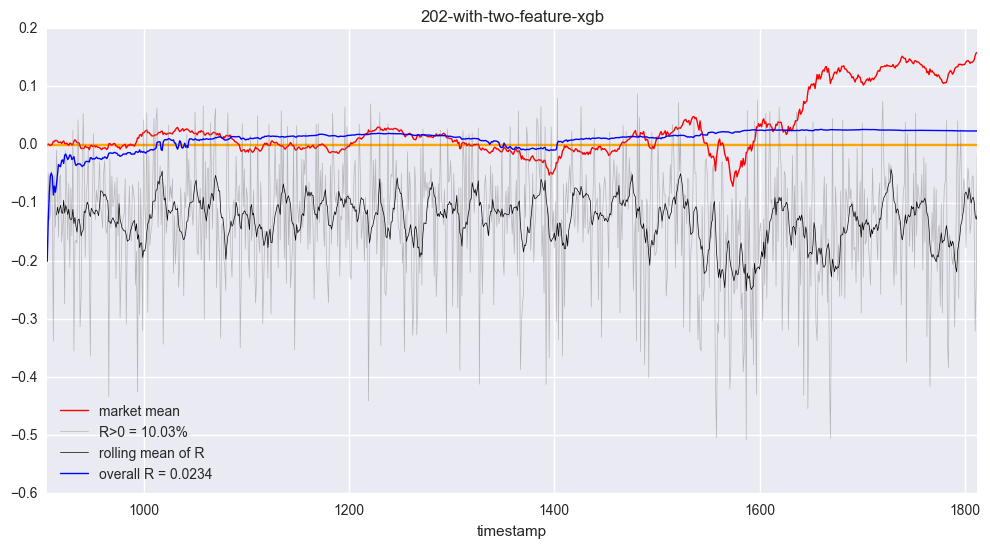

In [17]:
p21.plot()

## et1_ridge3_med_adj
- https://www.kaggle.com/willieliao/two-sigma-financial-modeling/et1-ridge3-med-adj/run/967135

In [31]:
import kagglegym
import numpy as np
import pandas as pd
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import Ridge
from sklearn.base import TransformerMixin
from sklearn.pipeline import FeatureUnion, make_pipeline
from gc import collect

###################################
### Settings
###################################
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 50)
pd.set_option('display.float_format', '{:.4f}'.format)

N_THREADS = -1
Y_CLIP_LO, Y_CLIP_HI = -0.075, 0.075
TS_ADJ_CLIP_LO, TS_ADJ_CLIP_HI = 0.1, 2.0
TS_ADJ_RATIO = 0.02
CUMMED_ADJ_RATIO = 0.04
MIN_ADJ_DATA = 100
RANDOM_SEED = 20170301

cols_na = ['technical_' + str(i) for i in [0, 9, 13, 16, 20, 30, 32, 38, 44]]
cols_diff = ['technical_' + str(i) for i in [11, 13, 20, 22, 27, 30, 34, 44]] + ['derived_0']
cols_backshift = cols_diff + ['ma', 'fundamental_11']
cols_ts = ['ma', 'y_lag', 'sign_change']

env = kagglegym.make()
o = env.reset()
cols_excl = ([env.ID_COL_NAME, env.SAMPLE_COL_NAME, env.TARGET_COL_NAME, env.TIME_COL_NAME]
             + [c + '_B' for c in cols_backshift] + ['ti', 'y_lag_prod', 'sign_change_sum'])
cols_orig = [c for c in o.train.columns if c not in cols_excl] + ['ma']
cols_na_count = [c + '_nan' for c in cols_orig if c not in cols_excl]

###################################
### Classes
###################################
class CountFillMissing(TransformerMixin):
    def __init__(self, cols_orig, cols_na, cols_medians):
        self.cols_orig = cols_orig
        self.cols_na = cols_na
        self.cols_medians = cols_medians

    def fit(self, X=None):
        return self

    def transform(self, X):
        X['ma'] = X['technical_20'] + X['technical_13'] - X['technical_30']
        X = X.assign(nas=0, nas1=0)
        for c in self.cols_orig:
            X[c + '_nan'] = pd.isnull(X[c])
            X['nas'] += X[c + '_nan']
            if c in self.cols_na:
                X['nas1'] += X[c + '_nan']
        X.fillna(self.cols_medians, inplace=True)
        return X

    def fit_transform(self, X, y=None, **fit_params):
        return self.transform(X)


class MovingAverage(TransformerMixin):
    def __init__(self, cols_backshift, cols_diff, cols_medians):
        self.cols_backshift = cols_backshift
        self.cols_diff = cols_diff
        self.cols_medians = cols_medians
        self.cols_keep = list({'id', 'ma', 'y_lag', 'y_lag_prod', 'sign_change_sum', 'ti'}
                              | set(self.cols_backshift) | set(self.cols_diff))
        # Store latest features for differences and cumulative columns
        self.previous = None

    def fit(self, X=None):
        return self

    def transform(self, X):
        # Previous values
        X = pd.merge(X, self.previous, how='left', on='id', suffixes=['', '_B'], sort=False)
        for c in self.cols_backshift:
            X[c + '_B'].fillna(self.cols_medians[c], inplace=True)
            if c in self.cols_diff:
                X[c + '_D'] = X[c] - X[c + '_B']

        # Fill if no previous value
        X.ti.fillna(-1, inplace=True)
        X.loc[X.y_lag.isnull(), 'y_lag'] = X.loc[X.y_lag.isnull(), 'ma']
        X.loc[X.y_lag_prod.isnull(), 'y_lag_prod'] = X.y_lag.loc[X.y_lag_prod.isnull()] + 1.0
        X.sign_change_sum.fillna(0, inplace=True)

        # Moving Averages
        X['ti'] += 1
        X.rename(columns={'y_lag_prod': 'y_lag_prod_B', 'y_lag': 'y_lag_B'}, inplace=True)
        X['y_lag'] = 15.0 * X['ma'] - 14.0 * X['ma_B']
        X['y_lag_prod'] = X['y_lag_prod_B'] * (1.0 + X['y_lag'])
        X['y_lag_diff'] = X['y_lag_prod'] - X['y_lag_prod_B']
        X['sign_change'] = X['y_lag'] == X['y_lag_B']
        X['sign_change_sum'] += X['sign_change']
        X['sign_change_cum'] = X['sign_change_sum'] / X['ti']
        X.loc[X.ti < 10, 'sign_change_cum'] = 0.5
        X.drop(['y_lag_prod_B', 'y_lag_B'], axis=1, inplace=True)

        # Need to keep previous ids not present in current timestamp
        self.previous = pd.concat([X[self.cols_keep], self.previous.loc[~self.previous.id.isin(X.id)]])
        return X

    def fit_transform(self, X, y=None, **fit_params):
        # Previous values
        X.sort_values(['id', 'timestamp'], inplace=True)
        X.reset_index(drop=True, inplace=True)
        g = X.groupby('id')
        X['ti'] = g.cumcount()
        for c in self.cols_backshift:
            X[c + '_B'] = g[c].shift(1)
            X[c + '_B'].fillna(self.cols_medians[c], inplace=True)
            if c in self.cols_diff:
                X[c + '_D'] = X[c] - X[c + '_B']
        del g

        # Lagged target
        X['y_lag'] = 15.0 * X['ma'] - 14.0 * X['ma_B']

        # Cumulative Values
        X['y_lag_prod'] = X['y_lag'] + 1.0
        X['y_lag_prod'] = X.groupby('id')['y_lag_prod'].cumprod()
        X['y_lag_diff'] = X['y_lag_prod'] - X.groupby('id')['y_lag_prod'].shift(1)
        X['y_lag_diff'].fillna(0.0, inplace=True)

        # Sign Change
        g = X.groupby('id')['y_lag']
        X['sign_change'] = np.sign(X.y_lag) != np.sign(g.shift(1).fillna(0.0))
        g = X.groupby('id')
        X['sign_change_sum'] = g['sign_change'].cumsum()
        X['sign_change_cum'] = X['sign_change_sum'] / X['ti']
        X.loc[X.ti < 10, 'sign_change_cum'] = 0.5

        self.previous = g[self.cols_keep].last().reset_index(drop=True)
        del g
        return X


class ExtremeValues(TransformerMixin):
    def fit(self):
        return self

    def transform(self, X):
        X['extreme0'] = (
            (X.technical_21 < -1.6).astype(int)
            + (X.technical_35 < -1.0).astype(int)
            + (X.technical_36 < -1.0).astype(int)
            + (X.technical_21 > 2.0).astype(int)
            + (X.technical_27 < -1.3).astype(int)
            + (X.fundamental_53 < -1.0).astype(int))
        return X

    def fit_transform(self, X, y=None, **fit_params):
        return self.transform(X)


class ModelTransformer(TransformerMixin):
    # Hack to use row and column filters
    def __init__(self, model, cols, rows):
        self.model = model
        self.cols = cols
        self.rows = rows

    def fit(self, X, y):
        self.model.fit(X.loc[self.rows, self.cols], y.loc[self.rows])
        return self

    def transform(self, X, **transform_params):
        return pd.DataFrame(self.model.predict(X.loc[:, self.cols]))


###################################
### Preprocess
###################################
print('### Preprocess')
# train = pd.read_hdf('../input/train.h5')
train = o.train
print('train before preprocess:', train.shape)
print('timestamps:', train["timestamp"].nunique())

train['ma'] = train['technical_20'] + train['technical_13'] - train['technical_30']
cols_medians = train[cols_orig].median(axis=0).to_dict()

preprocess_pipe = make_pipeline(
    CountFillMissing(cols_orig, cols_na, cols_medians)
    , MovingAverage(cols_backshift, cols_diff, cols_medians)
    , ExtremeValues()
)
train = preprocess_pipe.fit_transform(train)
print('train after preprocess:', train.shape)

print('Store previous targets for cumulative median')
y_lag_meds = train.loc[:, ['id', 'y_lag']]


###################################
### Models
###################################
cols_et = [c for c in train.columns if c not in cols_excl]
cols_lr0 = ['y_lag', 'ma', 'technical_11', 'fundamental_11', 'technical_11_B', 'fundamental_11_B']
cols_lr1 = ['y_lag', 'technical_22', 'technical_34', 'technical_22_B', 'technical_34_B']
cols_lr2 = ['ma', 'y_lag_prod', 'y_lag_diff']

post_ts10 = (train.timestamp > 10)
y_is_within_cut = (post_ts10) & (Y_CLIP_LO < train.y) & (train.y < Y_CLIP_HI)

print('MODEL: Extra Trees')
print('Features:', len(cols_et))
rfr = ExtraTreesRegressor(n_estimators=75, max_depth=5, min_samples_split=30, min_samples_leaf=16, n_jobs=N_THREADS, random_state=RANDOM_SEED)
model_et = rfr.fit(train.loc[post_ts10, cols_et], train.loc[post_ts10, 'y'])

print('Linear Regression')
model_lr0 = Ridge(fit_intercept=False)
model_lr0.fit(train.loc[y_is_within_cut, cols_lr0], train.loc[y_is_within_cut, 'y'])

model_lr1 = Ridge(fit_intercept=False)
model_lr1.fit(train.loc[y_is_within_cut, cols_lr1], train.loc[y_is_within_cut, 'y'])

model_lr2 = Ridge(fit_intercept=False)
model_lr2.fit(train.loc[y_is_within_cut, cols_lr2], train.loc[y_is_within_cut, 'y'])

models = {'et': model_et, 'lr0': model_lr0, 'lr1': model_lr1, 'lr2': model_lr2}
model_cols = {'et': cols_et, 'lr0': cols_lr0, 'lr1': cols_lr1, 'lr2': cols_lr2}
model_weights = {'et': 0.6, 'lr0': 0.22, 'lr1': 0.03, 'lr2': 0.15}


# Clean up
train.drop([c for c in train.columns if c not in ['id', 'timestamp', 'y']], axis=1, inplace=True)
del train, post_ts10, y_is_within_cut
collect()

p3 = Performance('et1_ridge3_med_adj')

while True:
    # Preprocess
    test = o.features    
    test = preprocess_pipe.transform(test)

    # Predict
    test['y_hat'] = 0.0
    for n, m in models.items():
        test['y_hat'] += m.predict(test[model_cols[n]]) * model_weights[n]

    # Adjust y_hat by timestamp variability
    if len(test) > MIN_ADJ_DATA:
        y_lag_med_ts = abs(test.y_lag).median()
        y_hat_med_ts = abs(test.y_hat).median()
        if y_lag_med_ts > 1e-6 and y_hat_med_ts > 1e-6:
            adj = y_lag_med_ts / y_hat_med_ts * TS_ADJ_RATIO
            adj = np.clip(adj, TS_ADJ_CLIP_LO, TS_ADJ_CLIP_HI)
            test['y_hat'] *= adj

    # Adjust y_hat by cumulative median
    y_lag_meds = pd.concat([y_lag_meds, test[['id', 'y_lag']]])
    y_lag_med = y_lag_meds.groupby('id').median().reset_index(drop=False)
    test = pd.merge(test, y_lag_med, how='left', on='id', suffixes=['', '_med'])
    test.loc[test.ti<10, 'y_lag_med'] = 0.0
    test['y_hat'] = test['y_hat'] * (1 - CUMMED_ADJ_RATIO) + test['y_lag_med'] * (CUMMED_ADJ_RATIO)

    # Clip
    test['y_hat'] = test['y_hat'].clip(Y_CLIP_LO, Y_CLIP_HI)

    # Cleanup
    pred = o.target
    pred['y'] = test['y_hat']
    test.drop([c for c in test.columns if c not in ['id', 'timestamp', 'y_hat']], axis=1, inplace=True)
    del y_lag_med
    collect()
    ts = o.features.timestamp[0]
    o, reward, done, info = env.step(pred)
    p3.update(ts, pred.y)
    
    if done:
        print("el fin ...", info["public_score"])
        break
    if o.features.timestamp[0] % 100 == 0:
        print(o.features.timestamp[0], reward, adj)

### Preprocess
train before preprocess: (806298, 111)
timestamps: 906
train after preprocess: (806298, 251)
Store previous targets for cumulative median
MODEL: Extra Trees
Features: 234
Linear Regression
1000 -0.314121536561 0.999054006179
1100 -0.183029524672 0.892152060108
1200 -0.178396883564 0.617035171029
1300 -0.00955939442627 0.729147298436
1400 -0.130363127875 0.890279563618
1500 -0.151198185904 1.29322368319
1600 -0.201853350847 1.19325903958
1700 -0.3006400165 1.01423291399
1800 -0.0197220328962 0.622137503739
el fin ... 0.0376881141995


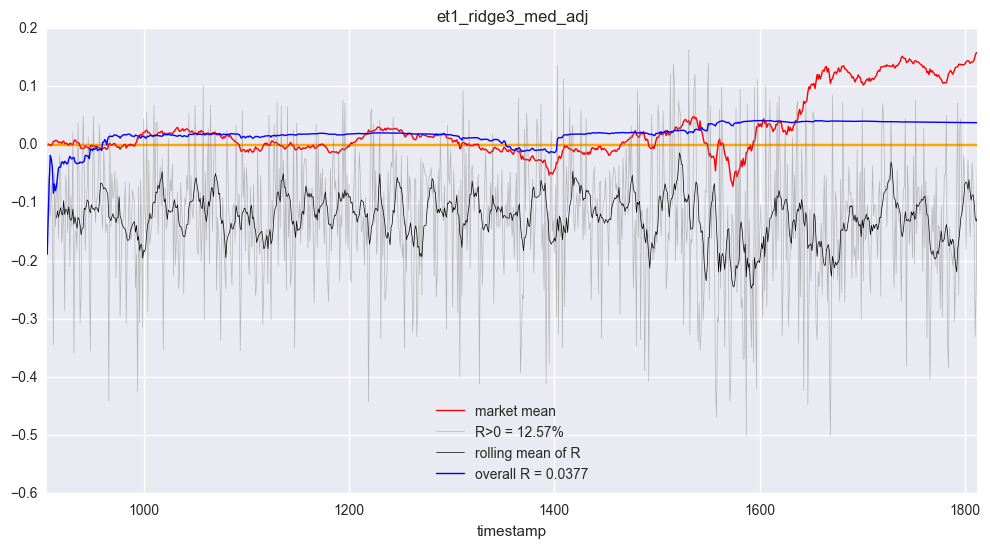

In [32]:
p3.plot()

## ModelC
- https://www.kaggle.com/ouranos/two-sigma-financial-modeling/modelc/run/972791

In [33]:
import kagglegym
import numpy as np
np.random.seed(43210)
import pandas as pd
from sklearn.ensemble import ExtraTreesRegressor
import xgboost as xgb
import math

    
def _reward(y_true, y_fit):
    R2 = 1 - np.sum((y_true - y_fit)**2) / np.sum((y_true - np.mean(y_true))**2)
    R = np.sign(R2) * math.sqrt(abs(R2))
    return(R)

env = kagglegym.make()
o = env.reset()
excl = [env.ID_COL_NAME, env.SAMPLE_COL_NAME, env.TARGET_COL_NAME, env.TIME_COL_NAME]
col = [c for c in o.train.columns if c not in excl]

#train = pd.read_hdf('../input/train.h5')
print("Loading Data")
train=o.train

previousTechnical13 = {}
previousTechnical20 = {}
previousTechnical30 = {}

#d_mean= train.median(axis=0)

#train = o.train[col]
n = train.isnull().sum(axis=1)
train = train.fillna(0)
#train = train.fillna(d_mean)
print("Adding new Features")
train['znull'] = n
train['thmtw'] = train.technical_30-train.technical_20

listofcolumns=['technical_13','technical_20','technical_30']

def addcolumns(df,listofcolumns):
    for col in listofcolumns:
        df['prev'+col]=df.groupby('id')[col].shift(1).fillna(0)
        df['D'+col]  = df[col] - df['prev'+col]
    return(df)

train=addcolumns(train,listofcolumns)
train['Ddd'] = train.Dtechnical_20 - train.Dtechnical_30

def addcolumns2(df):
    df['Dtechnical_20_30']= df['Dtechnical_20'] * df['Dtechnical_30']
    df['Dtechnical_20_13']= df['Dtechnical_20'] * df['Dtechnical_13']
    df['Dtechnical_30_13']= df['Dtechnical_30'] * df['Dtechnical_13']
    df['Dtechnical_20m30_13']= (df['Dtechnical_20'] - df['Dtechnical_30']) * df['Dtechnical_13']
    return(df)

train=addcolumns2(train)

#target=o.train['y']
#mean_y=target.mean()
mean_train_y=(o.train['y']).mean()
print(mean_train_y)

colS = [c for c in train.columns if c not in excl]

print("Fitting XGBoost Model")
xgmat_train = xgb.DMatrix(train.loc[:,colS], label=train['y'])

params_xgb = {'objective': 'reg:linear',
              'eta'             : 0.2,
              'max_depth'       : 6,#4,
              'subsample'       : 0.9,
              'colsample_bytree':0.8,
              'min_child_weight': 10,
              'silent'          : 1,
              'seed'            : 22
              }

              
bst = xgb.train(params_xgb, xgmat_train, 35)

XGBpredtrain=bst.predict(xgmat_train)
XGBpredtrainMean=XGBpredtrain.mean()
print(XGBpredtrainMean)

print("Fitting Extra Trees Model")
etr = ExtraTreesRegressor(n_estimators=60, max_depth=7, n_jobs=-1, random_state=17, verbose=0)
model1 = etr.fit(train[colS], train['y'])
train = []

p4 = Performance('ModelC')

#ymean_dict = dict(o.train.groupby(["id"])["y"].median())
reward_=[]
while True:
    test = o.features[col]
    firstsids = []
    yarray = np.zeros(o.target.y.shape[0])
    o.features.fillna(0, inplace=True)
    #o.features.fillna(median_values, inplace=True)
    timestamp = o.features["timestamp"][0]
    #llData = None
    allData = pd.DataFrame(np.zeros((test.shape[0], 6)))
    allrows=0
    for i in range(o.target.y.shape[0]):
        sid = o.features["id"].values[i]
        if(sid in previousTechnical20.keys()):
            data = np.zeros(shape=(1, 6))
            data[0, 0] = previousTechnical13[sid]
            data[0, 1] = o.features["technical_13"][i]
            data[0, 2] = previousTechnical20[sid]
            data[0, 3] = o.features["technical_20"][i]
            data[0, 4] = previousTechnical30[sid]
            data[0, 5] = o.features["technical_30"][i]

        else:
            data = np.zeros(shape=(1, 6))
            #data -= 999

        previousTechnical13[sid] = o.features["technical_13"][i]
        previousTechnical20[sid] = o.features["technical_20"][i]
        previousTechnical30[sid] = o.features["technical_30"][i]

        allData.loc[allrows,:] = data
        allrows += 1 
        
    allData.columns=['technical_13_Prev', 'technical_13_Cur', 'technical_20_Prev', 'technical_20_Cur',
                     'technical_30_Prev', 'technical_30_Cur']

    #for g in range(0,14):
    #    allData.iloc[:,g][allData.iloc[:,g]==-999] = 0#cmar[g]
    #allData.replace(-999,0,inplace=True)
    
    #test = o.features[col]
    n = test.isnull().sum(axis=1)
    #for c in test.columns:
    #    test[c + '_nan_'] = pd.isnull(test[c])
    test = test.fillna(0)
    #test = test.fillna(d_mean)
    test['znull'] = n
    test['thmtw'] = test.technical_30-test.technical_20
    
    test['prevtechnical_20']=allData['technical_20_Prev']
    test['Dtechnical_20']  = test['technical_20'] - test['prevtechnical_20']
    test['prevtechnical_30']=allData['technical_30_Prev']
    test['Dtechnical_30']  = test['technical_30'] - test['prevtechnical_30']
    test['prevtechnical_13']=allData['technical_13_Prev']
    test['Dtechnical_13']  = test['technical_13'] - test['prevtechnical_13']

    
    test['Ddd'] = test.Dtechnical_20 - test.Dtechnical_30
    test=addcolumns2(test)
    #test = test.fillna(0)
    #test = test[colS]
    ETpreds = model1.predict(test[colS])
    xgmat_test = xgb.DMatrix(test.loc[:,colS])
    XGBpreds=bst.predict(xgmat_test)
    XGBpreds=(XGBpreds -XGBpredtrainMean+mean_train_y).clip(-0.002,0.002)
    pred = o.target
    pred['y'] = (XGBpreds + ETpreds)/2
    #test2 = np.array(o.features[col].fillna(d_mean)['technical_20'].values).reshape(-1,1)
    #pred['y'] =predGP *0.6 + 0.4* (model1.predict(test).clip(low_y_cut, high_y_cut) * 0.6) + (model2b.predict(test2).clip(low_y_cut, high_y_cut))*0.4 + (model2.predict(test2).clip(low_y_cut, high_y_cut) * 0.4)
    #pred['y'] =predGP *0.5 + 0.5* (model1.predict(test).clip(low_y_cut, high_y_cut) * 0.6) +  (model2.predict(test2).clip(low_y_cut, high_y_cut) * 0.4)
    #pred['y'] = pred.apply(lambda r: 0.95 * r['y'] + 0.05 * ymean_dict[r['id']] if r['id'] in ymean_dict else r['y'], axis = 1)
    pred['y'] = [float(format(x, '.6f')) for x in pred['y']]
    o, reward, done, info = env.step(pred)
    p4.update(timestamp, pred.y)
    
    reward_.append(reward)
    if done:
        print("el fin ...", info["public_score"])
        break
    if o.features.timestamp[0] % 100 == 0:
        print(reward, np.mean(np.array(reward_)))

Loading Data
Adding new Features
0.000255877006566152
Fitting XGBoost Model
0.000461829
Fitting Extra Trees Model
-0.309527022317 -0.129809451437
-0.185072247033 -0.118574549138
-0.164381356204 -0.116559152666
-0.0148972279629 -0.117765155335
-0.121387013639 -0.11861947974
-0.141550674575 -0.119037491274
-0.191826934868 -0.123817686711
-0.31163923066 -0.126504513427
-0.0156081232219 -0.127106443066
el fin ... 0.0322560163563


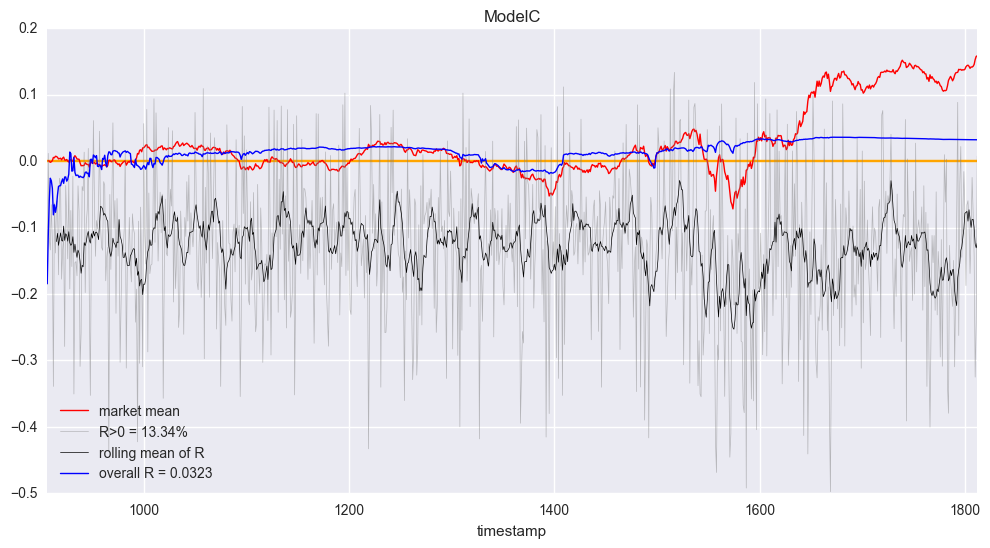

In [34]:
p4.plot()

## mixed_ridge_etr_xgb
- https://www.kaggle.com/cescfangs/two-sigma-financial-modeling/mixed-ridge-etr-xgb-private0-0252120/run/859377

In [35]:
import kagglegym
import pandas as pd
import numpy as np
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, Ridge
from xgboost import XGBRegressor



# Kaggle Environment #
env = kagglegym.make()
observation = env.reset()
# End of Kaggle Environment #

# Feature Selection #

null_labels = [
    'technical_21',
    'technical_19',
    'technical_27',
    'technical_36',
    'technical_35',
    'technical_17',
    'technical_43',
    'technical_13',
    'fundamental_33',
    'technical_14',
    'technical_33',
    'fundamental_18',
    'fundamental_48',
    'fundamental_59',
    'technical_9',
    'technical_16',
    'technical_42',
    'technical_18',
    'fundamental_42',
    'fundamental_0',
    'fundamental_7',
    'fundamental_41',
    'technical_41',
    'fundamental_21',
    'fundamental_19',
    'technical_29',
    'technical_24',
    'derived_0',
    'derived_1',
    'fundamental_17',
    'technical_3',
    'fundamental_20',
    'fundamental_32',
    'fundamental_62',
    'fundamental_25',
    'technical_1',
    'fundamental_58',
    'derived_3',
    'technical_5',
    'fundamental_52',
    'technical_10',
    'technical_31',
    'technical_25',
    'technical_44',
    'technical_28',
    'fundamental_40',
    'fundamental_27',
    'fundamental_29',
    'fundamental_43',
    'fundamental_15',
    'fundamental_30',
    'fundamental_60',
    'fundamental_16',
    'fundamental_50',
    'fundamental_44',
    'fundamental_37',
    'fundamental_14',
    'fundamental_23',
    'fundamental_55',
    'fundamental_8',
    'fundamental_63',
    'fundamental_39',
    'fundamental_54',
    'derived_2',
    'derived_4',
    'fundamental_35',
    'fundamental_34',
    'fundamental_47',
    'fundamental_51',
    'fundamental_31',
    'fundamental_49',
    'fundamental_22',
    'fundamental_9',
    'fundamental_24',
    'fundamental_57',
    'fundamental_28',
    'fundamental_61',
    'fundamental_1',
    'fundamental_6',
    'fundamental_38',
    'fundamental_5']
etr_features = ['y_past',
 'tec20-30',
 'technical_30',
 'tec123',
 'technical_43',
 'technical_43_diff',
 'tec123_past',
 'technical_11_diff',
 'technical_2_diff',
 'technical_11',
 'technical_20',
 'technical_2',
 'fundamental_25_nan',
 'technical_14_diff',
 'technical_21_diff',
 'technical_9_nan',
 'technical_40',
 'technical_30_diff',
 'technical_6_diff',
 'technical_6',
 'technical_17_diff',
 'technical_17',
 'technical_14',
 'technical_7',
 'technical_19',
 'technical_44_nan',
 'fundamental_27_nan',
 'technical_18_nan',
 'technical_28_nan',
 'technical_21',
 'technical_42_nan',
 'technical_29_diff',
 'technical_20_diff',
 'technical_31_nan',
 'fundamental_53',
 'technical_24_nan',
 'technical_36',
 'technical_19_diff',
 'technical_27',
 'technical_29',
 'technical_35',
 'technical_22',
 'technical_41_nan',
 'fundamental_8',
 'fundamental_21',
 'fundamental_17_nan',
 'technical_34',
 'technical_16_nan',
 'technical_27_diff',
 'fundamental_33_nan',
 'fundamental_58',
 'derived_1_nan',
 'technical_10',
 'technical_25_nan',
 'fundamental_18',
 'fundamental_59',
 'technical_40_diff',
 'null_count',
 'fundamental_5_nan',
 'fundamental_48',
 'fundamental_47_nan',
 'technical_36_diff',
 'fundamental_41_nan',
 'fundamental_42_nan',
 'fundamental_0_nan',
 'fundamental_50',
 'fundamental_40',
 'technical_3_nan',
 'fundamental_23',
 'fundamental_49_nan',
 'fundamental_36',
 'technical_44',
 'fundamental_2',
 'fundamental_0',
 'technical_41',
 'fundamental_62_diff',
 'technical_38_diff',
 'fundamental_22_nan',
 'technical_12',
 'fundamental_62',
 'technical_37_diff',
 'fundamental_44',
 'technical_29_nan',
 'fundamental_24_nan',
 'technical_10_nan',
 'fundamental_46',
 'technical_1',
 'fundamental_54_nan',
 'fundamental_0_diff',
 'technical_12_diff',
 'technical_35_diff',
 'derived_3_nan',
 'fundamental_63_nan',
 'fundamental_31_nan',
 'fundamental_40_nan',
 'fundamental_35_nan',
 'technical_3',
 'fundamental_13']
 
xgb_features = ['technical_38_diff',
 'technical_17_diff',
 'technical_14_diff',
 'technical_35_diff',
 'technical_11_diff',
 'fundamental_50',
 'fundamental_35_nan',
 'fundamental_48',
 'technical_29_diff',
 'tec123',
 'technical_41',
 'technical_19',
 'technical_2',
 'technical_11',
 'technical_35',
 'fundamental_2',
 'fundamental_0_diff',
 'fundamental_36',
 'technical_37_diff',
 'technical_30_diff',
 'fundamental_44',
 'technical_21',
 'technical_36',
 'technical_40',
 'technical_1',
 'fundamental_23',
 'technical_27_diff',
 'technical_7',
 'technical_30',
 'null_count',
 'technical_9_nan',
 'fundamental_18',
 'technical_43_diff',
 'tec123_past',
 'technical_12_diff',
 'fundamental_13',
 'fundamental_58',
 'technical_40_diff',
 'fundamental_8',
 'technical_41_nan',
 'technical_17',
 'technical_36_diff',
 'technical_43',
 'technical_31_nan',
 'technical_21_diff',
 'technical_20_diff',
 'y_past',
 'technical_27',
 'fundamental_62_diff',
 'fundamental_21',
 'tec20-30',
 'technical_3',
 'technical_19_diff',
 'fundamental_53',
 'technical_2_diff']
seed = 17
excl = [env.ID_COL_NAME, env.SAMPLE_COL_NAME, env.TARGET_COL_NAME, env.TIME_COL_NAME]
origin_features = [c for c in observation.train.columns if c not in excl]
origin_features_exclude_y = [c for c in observation.train.columns if c not in ['y']]
diff_features = [feature + '_diff' for feature in origin_features]
# xgb_features = diff_features[:10] + normal_features[:-10] + nan_features[:-10] #+ normal_features[20::2]
# etr_features = diff_features[:2] +  normal_features + nan_features
linear_features = ['technical_20_diff', 'tec20-30']
# End of Feature Selection #
d_mean = observation.train.median(axis=0)

last_stamp = observation.train.loc[observation.train.timestamp ==
                                   observation.train.timestamp.max(), origin_features_exclude_y]
                                   
# add diffs #
def add_diff(data):
    data.sort_values(['id', 'timestamp'], inplace=True)
    data['id_diff'] = data.id.diff()
    for feature in origin_features:
        diff_tag = feature + '_diff'
        data[diff_tag] = data[feature].diff()
        d_mean[diff_tag] = 0
    data.loc[data.id_diff != 0, diff_features] = 0
# end of diffs #


# add Nan tags #
def add_nan(data):
    Nan_counts = data.isnull().sum(axis=1)
    for feature in null_labels:
        data[feature + '_nan'] = pd.isnull(data[feature])
        d_mean[feature + '_nan'] = 0
    data['null_count'] = Nan_counts
# end of Nan tags #

def R_sign(y_pred, y):
    '''
    input: ypred, y
    return: R2 score of prediction
    '''
    u = np.mean(y)
    R2 = 1 - np.sum(np.square(y - y_pred)) / np.sum(np.square(y - u))
    R = np.sign(R2) * np.sqrt(np.abs(R2))
    return R


def predict_y_past(x):
    # w =  np.array([-8.36489105,  9.19544792]).T
    w = np.array([-8.08872128,  8.89837742]).T
    c = -0.00026617524826966221
    return x.dot(w) + c #- 0.00020021698404804056
    
    
ymean_dict = dict(observation.train.groupby(["id"])["y"].median())

print('Processing data...')

train = observation.train
add_diff(train)
add_nan(train)
train = train.fillna(d_mean)

train['tec20-30'] = train.technical_20 - train.technical_30
train['tec123'] = train['tec20-30'] + train.technical_13
train['tec123_past'] = train.tec123.shift()
train['y_past'] = train.y.shift()
train.loc[train.id_diff != 0, ['tec123_past', 'y_past']] = 0

low_y_cut = -0.075
high_y_cut = 0.075
y_above_cut = (train.y > high_y_cut)
y_below_cut = (train.y < low_y_cut)
y_within_cut = (~y_above_cut & ~y_below_cut)
train.fillna(0, inplace=True)
# Generate models...
ridge_1 = Ridge()
ridge_2 = Ridge()
etr = ExtraTreesRegressor(n_estimators=248, max_depth=6, min_samples_leaf=27, max_features=0.6, n_jobs=-1, random_state=seed, verbose=0)
xgb = xgb = XGBRegressor(n_estimators=80, nthread=-1, max_depth=3, learning_rate=0.1, reg_lambda=1, subsample=1.0,
                   colsample_bytree=0.5, seed=seed)

print('Training Linear Model...\n', len(linear_features), 'features')
ridge_2.fit(train.loc[y_within_cut, linear_features], train.loc[y_within_cut, 'y'])
ridge_1.fit(np.array(train.loc[y_within_cut, linear_features[0]]).reshape(-1, 1), train.loc[y_within_cut, 'y'])

print('Training XGBoost Model...\n', len(xgb_features), 'features')
xgb.fit(train[xgb_features], train.y)

print('Training ETR Model...\n', len(etr_features), 'features')
etr.fit(train[etr_features], train.y)
# end of Generate models.
# full_df = pd.read_hdf('../input/train.h5')

train = 0
w_etr = 0.38
w_lr = 1
w_xgb = 0.38

reward = -1
# predicting...
print('Predicting...')
r_true = []
y_lr_1_p=0
y_lr_2_p=0
a = 0.5
b = 0.5
p5 = Performance('mixed_ridge_etr_xgb')
while True:
    timestamp = observation.features.timestamp[0]
    test = observation.features
    test = pd.concat([test, last_stamp])
    
    add_diff(test)
    test['tec20-30'] = test.technical_20 - test.technical_30
    test['tec123'] = test['tec20-30'] + test.technical_13
    test['tec123_past'] = test.tec123.shift()
    test.loc[test.id_diff != 0, 'tec123_past'] = 0
    test = test.loc[test.timestamp == timestamp]
    test.sort_index(inplace=True)
    add_nan(test)
    test.fillna(d_mean, inplace=True)
   
    test['y_past'] = predict_y_past(test[['tec123_past', 'tec123']])
    test.fillna(0, inplace=True)
    last_stamp = test.loc[test.timestamp == timestamp, origin_features_exclude_y]
    
    pred = observation.target
    
    # y_t = full_df.loc[full_df.timestamp == timestamp, 'y']
    y_etr = etr.predict(test[etr_features])
    y_xgb = xgb.predict(test[xgb_features]).clip(low_y_cut, high_y_cut)
    y_lr_2 = ridge_2.predict(test[linear_features]).clip(low_y_cut, high_y_cut)
    y_lr_1 = ridge_1.predict(np.array(test[linear_features[0]]).reshape(-1, 1)).clip(low_y_cut, high_y_cut)
    # r_1 = R_sign(y_lr_1, y_etr)
    # r_2 = R_sign(y_lr_2, y_etr)
    # r_1_t = R_sign(y_lr_1, y_t)
    # r_2_t = R_sign(y_lr_2, y_t)
    # r_true.append((r_1 > r_2) == (r_1_t > r_2_t))
    pred['y'] = y_lr_1 * 0.04 + y_lr_2 * 0.14 + y_etr * 0.54 + y_xgb * 0.28
    pred['y'] = pred.apply(lambda r: 0.98 * r['y'] + 0.02 * ymean_dict[r['id']]
                           if r['id'] in ymean_dict else r['y'], axis=1)
    pred['y'] = [float(format(x, '.6f')) for x in pred['y']]

    observation, reward, done, info = env.step(pred)
    p5.update(timestamp, pred.y)
    if done:
        print("R score ...", info["public_score"])
        # print("true predict", np.array(r_true).mean())
        break
    if timestamp % 100 == 0:
        print('timestamp:', timestamp, '---->', reward)
        # print("true predict", np.array(r_true).mean())

Processing data...
Training Linear Model...
 2 features
Training XGBoost Model...
 55 features
Training ETR Model...
 98 features
Predicting...
timestamp: 1000 ----> 0.0530243561495
timestamp: 1100 ----> -0.00872341782673
timestamp: 1200 ----> -0.0753468684215
timestamp: 1300 ----> -0.0880201219512
timestamp: 1400 ----> -0.167078129686
timestamp: 1500 ----> -0.137234794679
timestamp: 1600 ----> -0.166964591914
timestamp: 1700 ----> 0.0163047175823
timestamp: 1800 ----> -0.0721618376391
R score ... 0.029529279059


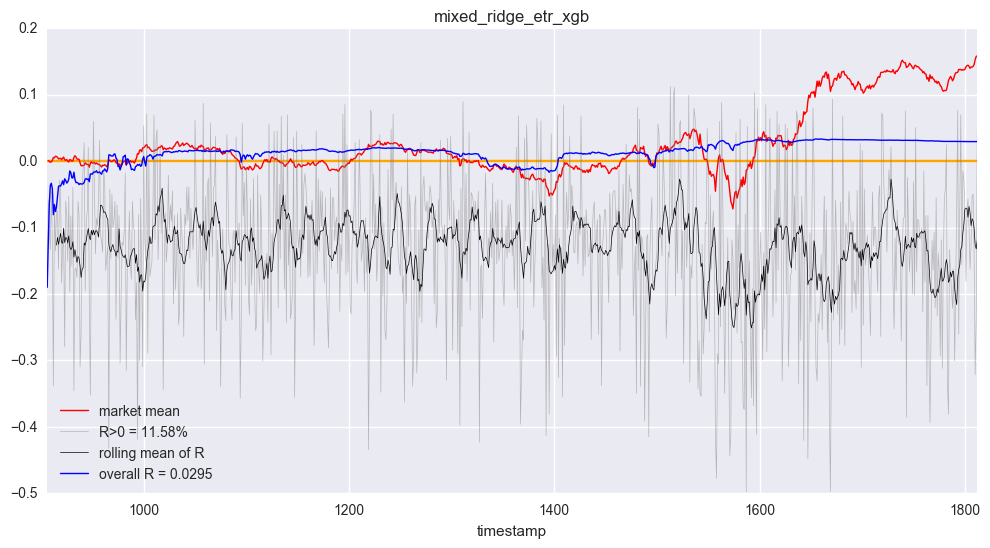

In [36]:
p5.plot()

## linear-bag-1
- https://www.kaggle.com/ggrizzly/two-sigma-financial-modeling/linear-bag-1-py/code

In [39]:
import kagglegym
import numpy as np
import pandas as pd
import math
import time
import gc   # do garbage collection manually
from sklearn.base import BaseEstimator
from sklearn.linear_model import LinearRegression
from sklearn.base import clone
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

class fast_BaggingRegressor(BaseEstimator):
    ''' bagging of linear regressors are still a linear model '''
    def __init__(self, base_estimator=None, n_estimators=10, random_state=123456,
                 max_samples=1.0, max_features=0, bootstrap=True, bootstrap_features=False, filter_estimators=False):
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.max_samples = max_samples
        self.max_features = max_features
        self.bootstrap = bootstrap  # not used yet
        self.bootstrap_features = bootstrap_features
        self.is_fitted = False
        self.model_coef = None  # np.array(n_estimators, n_features)
        self.model_constants = np.zeros((n_estimators,))  # np.array(n_estimators, 1)
        self.model_rewards = np.zeros((n_estimators, ))  # np.array(n_estimators, 1)
        self.n_features = None
        self.prng = np.random.RandomState(random_state)
        self.filter_estimators = filter_estimators
        self.max_features = max_features  # number of features instead of percentage

    def normalized_rms_error(self, y_true, y_pred):
        return np.sum((y_true - y_pred)**2) / np.sum((y_true - np.mean(y_true))**2)

    def fit(self, X, y):
        try:
            X = X.values
            y = y.values
        except:
            pass
        n_samples, self.n_features = X.shape
        # the first column will be used to split the classifier
        assert self.n_features >= 1, 'dimension of X should better than 1, n_samples'
        self.model_coef = np.zeros((self.n_estimators, self.n_features))

        assert self.base_estimator is not None, 'please set base_estimator'

        # implicit assumpution: base_estimator is a linear regression
        features_indices_ = np.arange(self.n_features)
        sample_indices_ = np.arange(n_samples)
        train_filter = np.zeros((n_samples, ), dtype=bool)
        current_model = clone(self.base_estimator)
        for idx_ in np.arange(self.n_estimators):
            train_filter[:] = False
            # we are doing sampling with replacement of the whole thing
            train_indices = self.prng.choice(sample_indices_, size=int(self.max_samples*n_samples), replace=True)
            train_filter[train_indices] = True

            if self.bootstrap_features:
                assert (self.max_features > 1) and (self.max_features <= self.n_features), \
                    'selected number of features should be more than 1 and not more than n_features'
                n_selected_features = int(self.max_features)
                current_features = self.prng.choice(features_indices_, size=n_selected_features, replace=False)
            else:
                current_features = features_indices_
            # inspired by sklearn estimator.predict((X[mask, :])[:, features])
            current_model.fit((X[train_filter, :])[:, current_features], y[train_filter])
            y_pred = current_model.predict((X[~train_filter, :])[:, current_features])
            # print self.rms_error(y[~train_filter], y_pred), current_model.intercept_, current_model.coef_[:]
            self.model_rewards[idx_] = self.normalized_rms_error(y[~train_filter], y_pred)
            self.model_constants[idx_] = current_model.intercept_
            self.model_coef[idx_, current_features] = current_model.coef_

            if idx_ % 50 == 0:
                print('fast_BaggingRegressor finished %d out of %d' % (idx_, self.n_estimators))

        self.final_model = clone(self.base_estimator)
        if self.filter_estimators:
            # select top performing models on out of sample
            selected_models = self.model_rewards.argsort()[-int(0.5*self.n_estimators):]
            self.final_model.coef_ = np.mean(self.model_coef[selected_models, :], axis=0)
            self.final_model.intercept_ = np.mean(self.model_constants[selected_models], axis=0)
        else:
            # linearity of the model allows for simple additions
            self.final_model.coef_ = np.mean(self.model_coef, axis=0)
            self.final_model.intercept_ = np.mean(self.model_constants, axis=0)

        self.is_fitted = True
        self.coef_ = self.final_model.coef_
        self.intercept_ = self.final_model.intercept_
        return self

    def predict(self, X):
        if not self.is_fitted:
            raise RuntimeError('model is not fitted yet ')
        try:
            X = X.values
        except:
            pass
        return self.final_model.predict(X)

def _reward(y_true, y_fit):
    R2 = 1 - np.sum((y_true - y_fit)**2) / np.sum((y_true - np.mean(y_true))**2)
    R = np.sign(R2) * math.sqrt(abs(R2))
    return(R)


def index_chunker(data_df, n_chunks):
    # returns a pd.DataFrame with number of columns depending on the chunksize
    # print('splitting data into %d chunks' % n_chunks)
    unique_timestamp = data_df["timestamp"].unique()
    n_total = len(unique_timestamp)
    chunk_size = int(n_total/n_chunks)
    chunk_boundaries = np.arange(0, n_total, chunk_size)
    index_df = pd.DataFrame(data=True, index=data_df.index, columns=range(chunk_boundaries.shape[0]))
    for idx_, pos in enumerate(chunk_boundaries):
        # append the last partial chunk to the last list
        if (pos + 2*chunk_size) > n_total:
            current_filter = (data_df.timestamp >= pos)
            index_df.ix[current_filter, idx_] = False
            if (idx_+1) <= index_df.shape[0]:
                index_df = index_df.iloc[:, :(idx_+1)]
            break
        current_filter = (data_df.timestamp >= pos) & (data_df.timestamp < (pos + chunk_size))
        index_df.ix[current_filter, idx_] = False
    return index_df

# cross validated model building to avoid stacking overfitting
# not preforming well, we need some overfitting as the signal is so weak.
def train_base_model_cv(train, y_train, model_columns, sk_model, predictor_name):
    if predictor_name not in train.columns:
        # train.loc[:, predictor_name] = np.nan --> produce SettingWithCopyWarning
        train.assign(**{predictor_name: np.nan})

    # need timestamp for chunker
    train_columns = ['timestamp']+model_columns
    X_train = train[train_columns]

    # (1) Does not respect the time flow
    # (2) some data leakage as we applied fillna on the whole training data
    n_chunks = 10
    train_test_df = index_chunker(X_train, n_chunks)
    for column_idx_ in train_test_df.columns:
        train_indices = train_test_df[column_idx_]
        sk_model.fit(X_train.ix[train_indices, model_columns], y_train[train_indices])
        train.ix[~train_indices, predictor_name] = sk_model.predict(X_train.ix[~train_indices, model_columns])

    # fit the final model
    X_train = train[model_columns]
    sk_model.fit(X_train, y_train)
    # adhoc overfitting as the signal is weak
    # train.loc[index_filter, predictor_name] = (y_pred + sk_model.predict(train.loc[index_filter, model_columns]))/2.0

def train_base_model(train, y_train, model_columns, sk_model, predictor_name):
    X_train = train[model_columns]
    sk_model.fit(X_train, y_train)
    if predictor_name not in train.columns:
        # train.loc[:, predictor_name] = np.nan --> produce SettingWithCopyWarning
        train.assign(**{predictor_name: np.nan})
    train[predictor_name] = sk_model.predict(X_train)

def process_features_training(train, id_mean_columns_list, id_mean_rolling_list):
#    print('processing features during training')

    train['tech23'] = train['technical_20'] + train['technical_13'] - train['technical_30']
    train['tech23_v2'] = train['technical_20'] - train['technical_30']

    grouped_data_id = train.groupby('id')

    process_tech23 = lambda x: (x - 0.925*x.shift(1))/0.075
    approx_y = grouped_data_id['tech23'].transform(process_tech23)
    train['approx_y_prev'] = approx_y
    train['approx_y_prev'].fillna(0, inplace=True)
    train['approx_y_prev'] = train['approx_y_prev'].clip(-0.07, 0.07)

    approx_y = grouped_data_id['tech23_v2'].transform(process_tech23)
    train['approx_y_prev_v2'] = approx_y
    train['approx_y_prev_v2'].fillna(0, inplace=True)
    train['approx_y_prev_v2'] = train['approx_y_prev_v2'].clip(-0.07, 0.07)

    grouped_data_id = train.groupby('id')
    for current_column in id_mean_columns_list:
        for n_rolling_length in id_mean_rolling_list:
            if current_column == 'approx_y_prev':
                temp_data = grouped_data_id[current_column].rolling(window=n_rolling_length).median()

            else:
                temp_data = grouped_data_id[current_column].rolling(window=n_rolling_length).mean()

            # temp_data.fillna(0.0, inplace=True)
            temp_data = pd.DataFrame(temp_data.values, index=temp_data.index.get_level_values(1))
            new_column_name1 = current_column+'_id_mean_'+str(n_rolling_length)
            train[new_column_name1] = temp_data

            new_column_name2 = current_column + '_id_diff_mean_' + str(n_rolling_length)
            train[new_column_name2] = train[current_column] - train[new_column_name1]
            print('done with: %s, %s' % (new_column_name1, new_column_name2))

    grouped_data_ts = train.groupby('timestamp')
    average_values = grouped_data_ts['tech23'].agg([np.mean, np.std])
    average_values_extended = average_values.ix[train['timestamp']].reset_index(drop=True)
    train['tech23_cs_mean'] = average_values_extended['mean'].values
    train['tech23_cs_std'] = average_values_extended['std'].values

    n_rolling_length_long = 10
    average_values = grouped_data_ts['tech23'].mean().rolling(n_rolling_length_long).mean().fillna(0.0)
    train['tech23_cs_mean_10'] = average_values.ix[train['timestamp']].reset_index(drop=True).values

    train_median = train.median(axis=0)
    train = train.replace([np.inf, -np.inf], np.nan)
    train = train.fillna(train_median)
    return train, train_median

def process_features_online(test, id_mean_columns_list, id_mean_rolling_list,
                            prev_test_lists, train_median):
#    print('processing features during prediction')

    max_rolling_length = np.max(id_mean_rolling_list)

    test['tech23'] = test['technical_20'] + test['technical_13'] - test['technical_30']
    test['tech23_cs_mean'] = test['tech23'].mean(axis=0)
    test['tech23_cs_std'] = test['tech23'].std(axis=0)
    # n_ids = test.shape[0]
    test_prev = prev_test_lists[-1]
    # here is should be setting by common id
    approx_y_prev_values = test[['id', 'tech23']].set_index('id') - 0.925*(test_prev[['id', 'tech23']].set_index('id'))
    approx_y_prev_values /= 0.075

    test['approx_y_prev'] = approx_y_prev_values.loc[test.id].values
    test['approx_y_prev'].fillna(0, inplace=True)

    test['tech23_v2'] = test['technical_20'] - test['technical_30']
    approx_y_prev_values = test[['id', 'tech23_v2']].set_index('id') - 0.925*(test_prev[['id', 'tech23_v2']].set_index('id'))
    approx_y_prev_values /= 0.075

    test['approx_y_prev_v2'] = approx_y_prev_values.loc[test.id].values
    test['approx_y_prev_v2'].fillna(0, inplace=True)

    # test['approx_y_prev_cs_mean'] = test['approx_y_prev'].mean()

    prev_test_lists.append(test)
    if len(prev_test_lists) > max_rolling_length:
        prev_test_lists = prev_test_lists[1:]

    test_temp = test.set_index(test.id)
    for n_rolling_length in id_mean_rolling_list:
            test_grouped_data_id = pd.concat(prev_test_lists[-n_rolling_length:], axis=0).groupby('id')
            for current_column in id_mean_columns_list:
                if current_column == 'approx_y_prev':
                    temp_data = test_grouped_data_id[current_column].median()
                else:
                    temp_data = test_grouped_data_id[current_column].mean()

                new_column_name1 = current_column+'_id_mean_'+str(n_rolling_length)
                test_temp[new_column_name1] = temp_data

                new_column_name2 = current_column + '_id_diff_mean_' + str(n_rolling_length)
                test_temp[new_column_name2] = test_temp[current_column] - test_temp[new_column_name1]
                # print('done with: %s, %s' % (new_column_name1, new_column_name2))

    test_grouped_data_id = pd.concat(prev_test_lists, axis=0).groupby('id')
    test_temp['tech23_cs_mean_10'] = test_grouped_data_id['tech23_cs_mean'].mean()

    # assert len(test_lists) == 10
    # print(test.timestamp[0], approx_y_prev_cs_mean_smoothed[0])

    test = test_temp.reset_index(drop=True)
    test = test.fillna(train_median)
    return test, prev_test_lists


env = kagglegym.make()
observation = env.reset()
# excl = [env.ID_COL_NAME, env.TARGET_COL_NAME, env.TIME_COL_NAME]  # env.SAMPLE_COL_NAME
# col = [c for c in observation.train.columns if c not in excl]

train = observation.train
# train = pd.read_hdf('../input/train.h5')

id_mean_columns_list = ['tech23', 'approx_y_prev', 'tech23_v2', 'approx_y_prev_v2']
id_mean_rolling_list = [3, 5, 7, 10]
train, train_median = process_features_training(train, id_mean_columns_list, id_mean_rolling_list)

# https://www.kaggle.com/bguberfain/two-sigma-financial-modeling/univariate-model-with-clip/run/482189
# Observed with histograns:
low_y_cut = -0.085
high_y_cut = 0.092

mean_normalization_column = 'tech23_cs_mean_10'
volatility_column = 'tech23_cs_std'
cs_factor = 0.25  # try to adjust the mean y_train + some trial and error

print('mean_normalization_columns: %s, current cs_factor: %f' % (mean_normalization_column, cs_factor))

y_train = train['y'] - cs_factor*train[mean_normalization_column]
y_train /= train[volatility_column]

base_models = []
# simple_model = LinearRegression(fit_intercept=True)
simple_model = make_pipeline(StandardScaler(), LinearRegression(fit_intercept=True))

# now one could add tons of models here
base_models = []
base_models_columns = [['tech23', 'tech23_id_mean_3'],
                       ['technical_40', 'fundamental_11'],
                       ['approx_y_prev', 'approx_y_prev_id_mean_3', 'approx_y_prev_id_mean_10'],
                       ['approx_y_prev_id_mean_3', 'tech23_id_diff_mean_10'],
                       ['approx_y_prev_id_mean_3', 'approx_y_prev_id_mean_7', 'fundamental_11'],
                       ['tech23_id_diff_mean_3', 'fundamental_11'],
                       ['tech23', 'tech23_id_mean_5'],
                       ['fundamental_11', 'approx_y_prev_id_mean_7'],
                       ['approx_y_prev_id_mean_5', 'approx_y_prev_id_mean_10'],
                       ['technical_19', 'tech23_v2_id_diff_mean_10'],
                       ['approx_y_prev', 'approx_y_prev_id_mean_3', 'approx_y_prev_id_mean_5'],
                       ]

n_base_models = len(base_models_columns)
print('start of training')
t0 = time.time()

collected = gc.collect()
print('Garbage collector: collected %d objects.' % collected)

for idx_ in np.arange(n_base_models):
    model_columns_ = base_models_columns[idx_]
    predictor_name = 'pred_%d' % idx_
    sk_model_ = clone(simple_model)
    train_base_model(train, y_train, model_columns_, sk_model_, predictor_name)
    # print('train_base_model %d, with parameters intercept_ and coef_: %s, %s' % (idx_, sk_model_.intercept_, sk_model_.coef_))
    print('train_base_model %d' % (idx_))
    base_models.append(sk_model_)

# using all data in model stacking -- overfitting
base_models_outputs = ['pred_%d' % idx_ for idx_ in np.arange(n_base_models)]
model_final_columns = base_models_outputs  # + ['fundamental_11', 'approx_y_prev', 'approx_y_prev_id_mean_3', 'approx_y_prev_id_mean_10']

X_train = train[model_final_columns]
predictor_stacked_name = 'stacked_pred'

# clone mess-up things with random state
# More features is somehow good -- max_features 0.6 is better and 0.3 for 7 features
sk_model_final = fast_BaggingRegressor(LinearRegression(fit_intercept=True), n_estimators=3000,
                                       random_state=565776, max_samples=1.0, max_features=3,
                                       bootstrap=True, bootstrap_features=True, filter_estimators=True)

sk_model_final.fit(X_train, y_train)
print('sk_model_final with parameters intercept_ and coef_: %s, %s' % (sk_model_final.intercept_, sk_model_final.coef_))

print('Done training in %f sec' % (time.time()-t0))

# this is for generating features online
max_rolling_length = np.max(id_mean_rolling_list)
prev_test_lists = list(train.groupby('timestamp'))[-max_rolling_length:]
prev_test_lists = [x[1] for x in prev_test_lists]

collected = gc.collect()
# print('Garbage collector: collected %d objects.' % collected)

p6 = Performance('linear-bag-1')
i = 0
reward_ = []
while True:
    test = observation.features
    pred = observation.target

    test, prev_test_lists = process_features_online(test, id_mean_columns_list, id_mean_rolling_list,
                                                    prev_test_lists, train_median)

    for temp_pred_name in model_final_columns + [predictor_stacked_name]:
        if temp_pred_name not in test.columns:
            test[temp_pred_name] = np.nan

    for idx_local_ in np.arange(n_base_models):
        model_columns_ = base_models_columns[idx_local_]
        predictor_name = 'pred_%d' % idx_local_
        sk_model_ = base_models[idx_local_]
        X_current = test[model_columns_]
        test[predictor_name] = sk_model_.predict(X_current)

    # predict on the stacked model
    X_current = test[model_final_columns]
    test[predictor_stacked_name] = sk_model_final.predict(X_current)

    test[predictor_stacked_name].replace([np.inf, -np.inf, np.nan], 0.0, inplace=True)

    test['y_pred'] = test[predictor_stacked_name]
    test['y_pred'] *= test[volatility_column]
    test['y_pred'] += cs_factor*test[mean_normalization_column]

    test['y_pred'] = test['y_pred'].clip(low_y_cut, high_y_cut)

    pred['y'] = test.loc[:, 'y_pred']
    ts = observation.features.timestamp[0]
    observation, reward, done, info = env.step(pred[['id', 'y']])
    reward_.append(reward)
    p6.update(ts, pred.y)
    
    if i % 100 == 0:
        print(reward, np.mean(np.array(reward_)))
        collected = gc.collect()
#        print('Garbage collector: collected %d objects.' % collected)

    i += 1
    if done:
        print("finished ...", info["public_score"])
        break

done with: tech23_id_mean_3, tech23_id_diff_mean_3
done with: tech23_id_mean_5, tech23_id_diff_mean_5
done with: tech23_id_mean_7, tech23_id_diff_mean_7
done with: tech23_id_mean_10, tech23_id_diff_mean_10
done with: approx_y_prev_id_mean_3, approx_y_prev_id_diff_mean_3
done with: approx_y_prev_id_mean_5, approx_y_prev_id_diff_mean_5
done with: approx_y_prev_id_mean_7, approx_y_prev_id_diff_mean_7
done with: approx_y_prev_id_mean_10, approx_y_prev_id_diff_mean_10
done with: tech23_v2_id_mean_3, tech23_v2_id_diff_mean_3
done with: tech23_v2_id_mean_5, tech23_v2_id_diff_mean_5
done with: tech23_v2_id_mean_7, tech23_v2_id_diff_mean_7
done with: tech23_v2_id_mean_10, tech23_v2_id_diff_mean_10
done with: approx_y_prev_v2_id_mean_3, approx_y_prev_v2_id_diff_mean_3
done with: approx_y_prev_v2_id_mean_5, approx_y_prev_v2_id_diff_mean_5
done with: approx_y_prev_v2_id_mean_7, approx_y_prev_v2_id_diff_mean_7
done with: approx_y_prev_v2_id_mean_10, approx_y_prev_v2_id_diff_mean_10
mean_normalizati

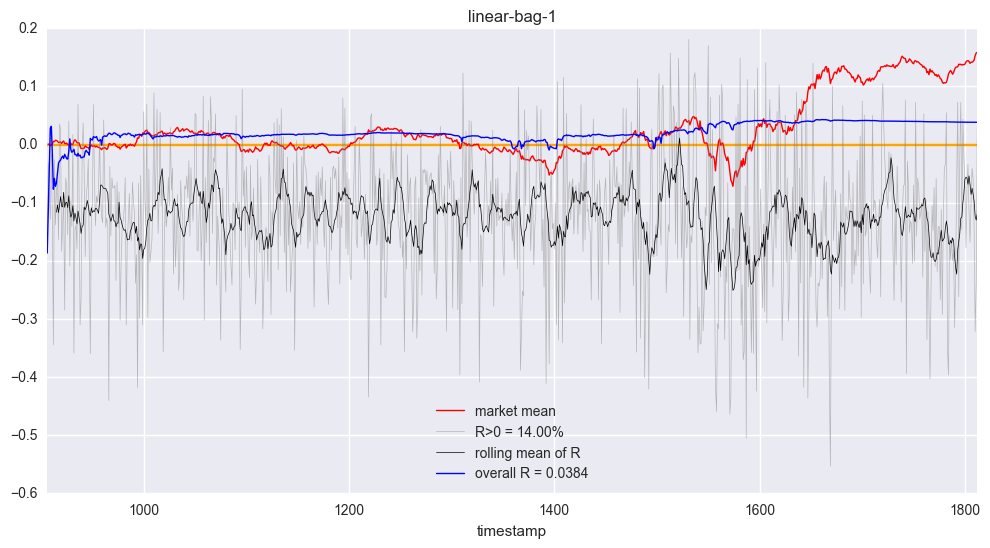

In [40]:
p6.plot()

## RL by Pradeep & Arthur
- https://www.kaggle.com/phegde/two-sigma-financial-modeling/reinforcement-learning-private-lb-0-0333/code

In [10]:
import kagglegym
import numpy as np
import pandas as pd
import random
from sklearn import ensemble, linear_model, metrics
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.linear_model import HuberRegressor
from itertools import combinations
import gc
from threading import Thread
import multiprocessing
from multiprocessing import Manager
from sklearn import preprocessing as pp

env = kagglegym.make()
o = env.reset()
train = o.train
print(train.shape)
d_mean= train.median(axis=0)
train["nbnulls"]=train.isnull().sum(axis=1)
col=[x for x in train.columns if x not in ['id', 'timestamp', 'y']]

rnd=17

#keeping na information on some columns (best selected by the tree algorithms)
add_nas_ft=True
nas_cols=['technical_9', 'technical_0', 'technical_32', 'technical_16', 'technical_38', 
'technical_44', 'technical_20', 'technical_30', 'technical_13']

#columns kept for evolution from one month to another (best selected by the tree algorithms)
add_diff_ft=True
diff_cols=['technical_22','technical_20', 'technical_30', 'technical_13', 'technical_34']

def get_reward(y_true, y_fit):
    R2 = 1 - np.sum((y_true - y_fit)**2) / np.sum((y_true - np.mean(y_true))**2)
    R = np.sign(R2) * np.sqrt(abs(R2))
    return(R)

class createLinearFeatures:
    
    def __init__(self, n_neighbours=1, max_elts=None, verbose=True, random_state=None):
        self.rnd=random_state
        self.n=n_neighbours
        self.max_elts=max_elts
        self.verbose=verbose
        self.neighbours=[]
        self.clfs=[]
        
    def fit(self,train,y):
        if self.rnd!=None:
            random.seed(self.rnd)
        if self.max_elts==None:
            self.max_elts=len(train.columns)
        #list_vars=list(train.columns)
        #random.shuffle(list_vars)
        list_vars = ['fundamental_44', 'technical_37', 'fundamental_53', 'technical_13_na', 'fundamental_37', 'fundamental_0', 
                     'technical_14', 'fundamental_40', 'technical_44', 'technical_9', 'fundamental_23', 'technical_21', 'fundamental_25', 
                     'fundamental_55', 'fundamental_58', 'technical_33', 'fundamental_24', 'fundamental_26', 'technical_24', 
                     'fundamental_61', 'fundamental_5', 'technical_5', 'derived_1', 'technical_22_d', 'fundamental_52', 'technical_20', 
                     'fundamental_50', 'technical_9_na', 'technical_39', 'fundamental_7', 'fundamental_20', 'technical_30_d', 
                     'fundamental_59', 'fundamental_32', 'technical_43', 'technical_34_d', 'fundamental_17', 'technical_12', 
                     'fundamental_16', 'technical_30_na', 'technical_38_na', 'fundamental_12', 'technical_17', 'fundamental_63', 
                     'fundamental_30', 'fundamental_54', 'technical_20_d', 'technical_6', 'fundamental_8', 'technical_7', 'fundamental_46', 
                     'derived_4', 'technical_34', 'nbnulls', 'fundamental_19', 'fundamental_29', 'technical_10', 'fundamental_9', 
                     'technical_0_na', 'technical_30', 'technical_18', 'technical_28', 'technical_31', 'derived_0', 'technical_32_na', 
                     'fundamental_57', 'technical_25', 'fundamental_41', 'fundamental_1', 'fundamental_43', 'fundamental_51', 'derived_2', 
                     'fundamental_39', 'technical_11', 'technical_13', 'fundamental_14', 'fundamental_56', 'technical_38', 'fundamental_6', 
                     'fundamental_48', 'fundamental_35', 'fundamental_3', 'technical_36', 'fundamental_11', 'technical_16_na', 
                     'fundamental_38', 'fundamental_22', 'technical_20_na', 'technical_3', 'technical_0', 'fundamental_15', 'fundamental_21', 
                     'technical_42', 'fundamental_2', 'technical_2', 'fundamental_13', 'fundamental_47', 'technical_29', 'technical_22', 
                     'technical_16', 'fundamental_36', 'fundamental_60', 'fundamental_28', 'technical_13_d', 'technical_32', 'technical_41', 
                     'fundamental_45', 'fundamental_27', 'derived_3', 'fundamental_10', 'fundamental_31', 'technical_19', 'technical_1', 
                     'technical_44_na', 'technical_27', 'technical_35', 'fundamental_18', 'fundamental_33', 'fundamental_42', 
                     'fundamental_34', 'technical_40', 'fundamental_49', 'fundamental_62']
        
        lastscores=np.zeros(self.n)+1e15

        for elt in list_vars[:self.n]:
            self.neighbours.append([elt])
        list_vars=list_vars[self.n:]
        
        for elt in list_vars:
            indice=0
            scores=[]
            for elt2 in self.neighbours:
                if len(elt2)<self.max_elts:
                    clf=linear_model.LinearRegression(fit_intercept=False, normalize=True, copy_X=True, n_jobs=-1) 
                    clf.fit(train[elt2+[elt]], y)
                    scores.append(metrics.mean_squared_error(y,clf.predict(train[elt2 + [elt]])))
                    indice=indice+1
                else:
                    scores.append(lastscores[indice])
                    indice=indice+1
            gains=lastscores-scores
            if gains.max()>0:
                temp=gains.argmax()
                lastscores[temp]=scores[temp]
                self.neighbours[temp].append(elt)

        indice=0
        for elt in self.neighbours:
            clf=linear_model.LinearRegression(fit_intercept=False, normalize=True, copy_X=True, n_jobs=-1) 
            clf.fit(train[elt], y)
            self.clfs.append(clf)
            if self.verbose:
                print(indice, lastscores[indice], elt)
            indice=indice+1
                    
    def transform(self, train):
        indice=0
        for elt in self.neighbours:
            #this line generates a warning. Could be avoided by working and returning
            #with a copy of train.
            #kept this way for memory management
            train['neighbour'+str(indice)]=self.clfs[indice].predict(train[elt])
            indice=indice+1
        return train
    
    def fit_transform(self, train, y):
        self.fit(train, y)
        return self.transform(train)

class huber_linear_model():
    def __init__(self):

        self.bestmodel=None
        self.scaler = pp.MinMaxScaler()
       
    def fit(self, train, y):

        indextrain=train.dropna().index
        tr = self.scaler.fit_transform(train.ix[indextrain])
        self.bestmodel = HuberRegressor().fit(tr, y.ix[indextrain])
        

    def predict(self, test):
        te = self.scaler.transform(test)
        return self.bestmodel.predict(te)

class LGB_model():
    def __init__(self, num_leaves=25, feature_fraction=0.6, bagging_fraction=0.6):
        self.lgb_params = {
                'task': 'train',
                'boosting_type': 'gbdt',
                'objective': 'regression',
                'metric': {'l2'},
                'learning_rate': 0.05,
                'bagging_freq': 5,
                'num_thread':4,
                'verbose': 0
            }
        
        self.lgb_params['feature_fraction'] = feature_fraction
        self.lgb_params['bagging_fraction'] = bagging_fraction
        self.lgb_params['num_leaves'] = num_leaves
        

        self.bestmodel=None
       
    def fit(self, train, y):
        
        X_train, X_val, y_train, y_val = train_test_split(train, y, test_size=0.2, random_state=343)
        
        lgtrain = lgb.Dataset(X_train, y_train)
        lgval = lgb.Dataset(X_val, y_val, reference=lgtrain)
                
        self.bestmodel = lgb.train(self.lgb_params,
                                    lgtrain,
                                    num_boost_round=100,
                                    valid_sets=lgval,
                                    verbose_eval=False,
                                    early_stopping_rounds=5)


    def predict(self, test):
        return self.bestmodel.predict(test, num_iteration=self.bestmodel.best_iteration)

    def feature_importance(self, imptype="gain"):
        return self.bestmodel.feature_importance(importance_type=imptype)

if add_nas_ft:
    for elt in nas_cols:
        train[elt + '_na'] = pd.isnull(train[elt]).apply(lambda x: 1 if x else 0)
        #no need to keep columns with no information
        if len(train[elt + '_na'].unique())==1:
            print("removed:", elt, '_na')
            del train[elt + '_na']
            nas_cols.remove(elt)


if add_diff_ft:
    train=train.sort_values(by=['id','timestamp'])
    for elt in diff_cols:
        #a quick way to obtain deltas from one month to another but it is false on the first
        #month of each id
        train[elt+"_d"]= train[elt].rolling(2).apply(lambda x:x[1]-x[0]).fillna(0)
    #removing month 0 to reduce the impact of erroneous deltas
    train=train[train.timestamp!=0]

print(train.shape)
cols=[x for x in train.columns if x not in ['id', 'timestamp', 'y']]

tokeepmodels=[]
tokeepcolumns=[]
tokeeprewards=[]


cols2fit=['technical_22','technical_20', 'technical_30_d', 'technical_20_d', 'technical_30', 
          'technical_13', 'technical_34']

huber_models=[]
huber_columns=[]
huber_rewards=[]

#for (col1, col2) in [('technical_22', 'technical_30'), ('technical_22', 'technical_20')]:
for (col1, col2) in combinations(cols2fit, 2):    
    print("fitting Huber model on ", [col1, col2])
    model=huber_linear_model()
    model.fit(train.loc[:,[col1, col2]],train.loc[:, 'y'])
    huber_models.append(model)
    huber_columns.append([col1, col2])
    
    y_pred = pd.Series(model.predict(train[[col1, col2]].fillna(d_mean)), index=train.index, name="y_pred")
    tmp_train = pd.concat([train[['id', 'timestamp', 'y']], y_pred], axis=1)
    reward = tmp_train.timestamp.map(tmp_train.groupby('timestamp').apply(lambda x: get_reward(x['y'], x['y_pred'])))
    reward.name = "reward"
    tmp_train = pd.concat([tmp_train, reward], axis=1)
    reward_shift = tmp_train.groupby('id').apply(lambda x: x['reward'].shift(1)).fillna(0)
    
    huber_rewards.append(reward_shift)
    del y_pred, tmp_train, reward
    gc.collect()


huber_to_keep=6
targetselector=np.array(huber_rewards).T
targetselector=np.argmax(targetselector, axis=1)

print("selecting best models:")
print(pd.Series(targetselector).value_counts().head(huber_to_keep))
tokeep=pd.Series(targetselector).value_counts().head(huber_to_keep).index

for elt in tokeep:
    tokeepmodels.append(huber_models[elt])
    tokeepcolumns.append(huber_columns[elt])
    tokeeprewards.append(huber_rewards[elt])


del huber_models
del huber_columns
del huber_rewards
gc.collect()

train=train.fillna(d_mean)

print("adding new features")
featureexpander=createLinearFeatures(n_neighbours=20, max_elts=2, verbose=True, random_state=rnd)
index2use=train[abs(train.y)<0.086].index
featureexpander.fit(train.ix[index2use,cols],train.ix[index2use,'y'])
trainer=featureexpander.transform(train[cols])

treecols = trainer.columns

print("training LGB model ")

lg_models=[]
lg_columns=[]
lg_rewards=[]

num_leaves = [70]
feature_fractions = [0.2, 0.6, 0.8]
bagging_fractions = [0.7]

#with Timer("running LGB models "):
for num_leaf in num_leaves:
    for feature_fraction in feature_fractions:
        for bagging_fraction in bagging_fractions:
            print("fitting LGB tree model with ", num_leaf, feature_fraction, bagging_fraction)
            model = LGB_model(num_leaves=num_leaf, feature_fraction=feature_fraction, bagging_fraction=bagging_fraction)
            model.fit(trainer[treecols],train.y)
            print("LGB feature importance")
            print(pd.DataFrame(model.feature_importance(),index=treecols).sort_values(by=[0]).tail(20))
            print(" ")
            lg_models.append(model)
            lg_columns.append(treecols)
            
            y_pred = pd.Series(model.predict(trainer[treecols]), index=train.index, name="y_pred")
            tmp_train = pd.concat([train[['id', 'timestamp', 'y']], y_pred], axis=1)
            reward = tmp_train.timestamp.map(tmp_train.groupby('timestamp').apply(lambda x: get_reward(x['y'], x['y_pred'])))
            reward.name = "reward"
            tmp_train = pd.concat([tmp_train, reward], axis=1)
            reward_shift = tmp_train.groupby('id').apply(lambda x: x['reward'].shift(1)).fillna(0)
            
            lg_rewards.append(reward_shift)
            del y_pred, tmp_train, reward
            gc.collect()
            

LG_to_keep=3
targetselector=np.array(lg_rewards).T
targetselector=np.argmax(targetselector, axis=1)
print("selecting best models:")
print(pd.Series(targetselector).value_counts().head(LG_to_keep))
tokeep=pd.Series(targetselector).value_counts().head(LG_to_keep).index

for elt in tokeep:
    tokeepmodels.append(lg_models[elt])
    tokeepcolumns.append(lg_columns[elt])
    tokeeprewards.append(lg_rewards[elt])

del lg_models
del lg_columns
del lg_rewards
gc.collect()



print("training trees")

ET_models=[]
ET_columns=[]
ET_rewards=[]

model = ensemble.ExtraTreesRegressor(n_estimators=40, max_depth=4, n_jobs=-1, random_state=rnd, verbose=0)
model.fit(trainer,train.y)
print(pd.DataFrame(model.feature_importances_,index=treecols).sort_values(by=[0]).tail(20))
for elt in model.estimators_:
    ET_models.append(elt)
    ET_columns.append(treecols)
    
    y_pred = pd.Series(elt.predict(trainer[treecols]), index=train.index, name="y_pred")
    tmp_train = pd.concat([train[['id', 'timestamp', 'y']], y_pred], axis=1)
    reward = tmp_train.timestamp.map(tmp_train.groupby('timestamp').apply(lambda x: get_reward(x['y'], x['y_pred'])))
    reward.name = "reward"
    tmp_train = pd.concat([tmp_train, reward], axis=1)
    reward_shift = tmp_train.groupby('id').apply(lambda x: x['reward'].shift(1)).fillna(0)
    
    ET_rewards.append(reward_shift)
    del y_pred, tmp_train, reward
    gc.collect()




ET_to_keep=5
targetselector=np.array(ET_rewards).T
targetselector=np.argmax(targetselector, axis=1)

print("selecting best models:")
print(pd.Series(targetselector).value_counts().head(ET_to_keep))
tokeep=pd.Series(targetselector).value_counts().head(ET_to_keep).index

for elt in tokeep:
    tokeepmodels.append(ET_models[elt])
    tokeepcolumns.append(ET_columns[elt])
    tokeeprewards.append(ET_rewards[elt])

del ET_models
del ET_columns
del ET_rewards
gc.collect()

targetselector=np.array(tokeeprewards).T
avg_rewards = pd.Series(targetselector.mean(axis=1), index=trainer.index, name="reward")

targetselector=np.argmax(targetselector, axis=1)
trainer = pd.concat([trainer, avg_rewards], axis=1)
last_reward = trainer[train.timestamp == max(train.timestamp)]['reward'].iloc[-1]

#with Timer("Training ET selection model "):
print("training selection model")
modelselector = ensemble.ExtraTreesClassifier(n_estimators=100, max_depth=4, n_jobs=-1, random_state=rnd, verbose=0)
modelselector.fit(trainer[ list(cols2fit) + ['reward']], targetselector)
print(pd.DataFrame(modelselector.feature_importances_,index= list(cols2fit) + ['reward']).sort_values(by=[0]).tail(20))


for modelp in tokeepmodels:
    print("")
    print(modelp)


lastvalues=train[train.timestamp==max(train.timestamp)][['id']+diff_cols].copy()

del trainer
del train
del tokeeprewards
gc.collect()

print("end of training, now predicting")
indice=0
countplus=0
rewards=[]
infoList = []

p7 = Performance('Reinforcement Learning by Pradeep & Arthur')
while True:
    infoDict = dict()
    indice+=1
    test = o.features
    test["nbnulls"]=test.isnull().sum(axis=1)
    if add_nas_ft:
        for elt in nas_cols:
            test[elt + '_na'] = pd.isnull(test[elt]).apply(lambda x: 1 if x else 0)
    test=test.fillna(d_mean)
    
    timestamp = o.features.timestamp[0]

    pred = o.target
    if add_diff_ft:
        #creating deltas from lastvalues
        indexcommun=list(set(lastvalues.id) & set(test.id))
        lastvalues=pd.concat([test[test.id.isin(indexcommun)]['id'],
            pd.DataFrame(test[diff_cols][test.id.isin(indexcommun)].values-lastvalues[diff_cols][lastvalues.id.isin(indexcommun)].values,
            columns=diff_cols, index=test[test.id.isin(indexcommun)].index)],
            axis=1)
        #adding them to test data    
        test=test.merge(right=lastvalues, how='left', on='id', suffixes=('','_d')).fillna(0)
        #storing new lastvalues
        lastvalues=test[['id']+diff_cols].copy()
        

    test=featureexpander.transform(test[cols])
    #prediction using modelselector and models list
    test['reward'] = last_reward

    selected_prediction = modelselector.predict_proba(test.loc[: , list(cols2fit) + ['reward']])
    
    for ind,elt in enumerate(tokeepmodels):
        pred['y']+=selected_prediction[:,ind]*elt.predict(test[tokeepcolumns[ind]])
    
    o, reward, done, info = env.step(pred)
    p7.update(timestamp, pred.y)
        
    #infoDict['timestamp'] = timestamp
    #infoDict['reward'] = reward
    #infoDict['score'] = info['public_score']
    #infoList.append(infoDict)
    
    last_reward = reward
    rewards.append(reward)
    if reward>0:
        countplus+=1
    
    if indice%100==0:
        print(indice, countplus, reward, np.mean(rewards), info)
        
    if done:
        print(info["public_score"])
        break

#pd.DataFrame(infoList).to_csv("../CSV/new_new2.csv", index=False)

(806298, 111)
(805548, 126)
fitting Huber model on  ['technical_22', 'technical_20']
fitting Huber model on  ['technical_22', 'technical_30_d']
fitting Huber model on  ['technical_22', 'technical_20_d']
fitting Huber model on  ['technical_22', 'technical_30']
fitting Huber model on  ['technical_22', 'technical_13']
fitting Huber model on  ['technical_22', 'technical_34']
fitting Huber model on  ['technical_20', 'technical_30_d']
fitting Huber model on  ['technical_20', 'technical_20_d']
fitting Huber model on  ['technical_20', 'technical_30']
fitting Huber model on  ['technical_20', 'technical_13']
fitting Huber model on  ['technical_20', 'technical_34']
fitting Huber model on  ['technical_30_d', 'technical_20_d']
fitting Huber model on  ['technical_30_d', 'technical_30']
fitting Huber model on  ['technical_30_d', 'technical_13']
fitting Huber model on  ['technical_30_d', 'technical_34']
fitting Huber model on  ['technical_20_d', 'technical_30']
fitting Huber model on  ['technical_20_d

/Users/paulperry/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


training LGB model 
fitting LGB tree model with  70 0.2 0.7
LGB feature importance
                       0
technical_20_d  0.660406
technical_21    0.662412
technical_36    0.667452
fundamental_44  0.667803
technical_35    0.696280
technical_3     0.705712
fundamental_41  0.707333
technical_43    0.730749
technical_40    0.793204
technical_41    0.797276
fundamental_21  0.809523
technical_27    0.815475
technical_33    0.891369
technical_2     0.939130
technical_30_d  1.015913
technical_19    1.041876
technical_30    1.382178
technical_11    1.407430
neighbour11     1.430935
technical_17    1.490227
 
fitting LGB tree model with  70 0.6 0.7
LGB feature importance
                       0
neighbour15     1.016417
technical_21    1.021455
neighbour18     1.037578
technical_6     1.062017
technical_41    1.093725
technical_1     1.153577
technical_19    1.190747
technical_20    1.212956
fundamental_44  1.216412
technical_33    1.256797
technical_35    1.373330
neighbour11     1.395141
te

/Users/paulperry/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


100 13 -0.0368930274095 -0.122219426963 {}
200 30 -0.175124465615 -0.114858466164 {}
300 46 -0.0342731025065 -0.114330139194 {}
400 57 -0.144481538598 -0.116145550332 {}
500 72 -0.116381089375 -0.117225619111 {}
600 83 -0.1317446658 -0.116742552584 {}
700 101 -0.258796177823 -0.122613813222 {}
800 115 -0.0968254943446 -0.12522120481 {}
900 128 -0.163660070435 -0.125637188802 {}
0.0308290906651


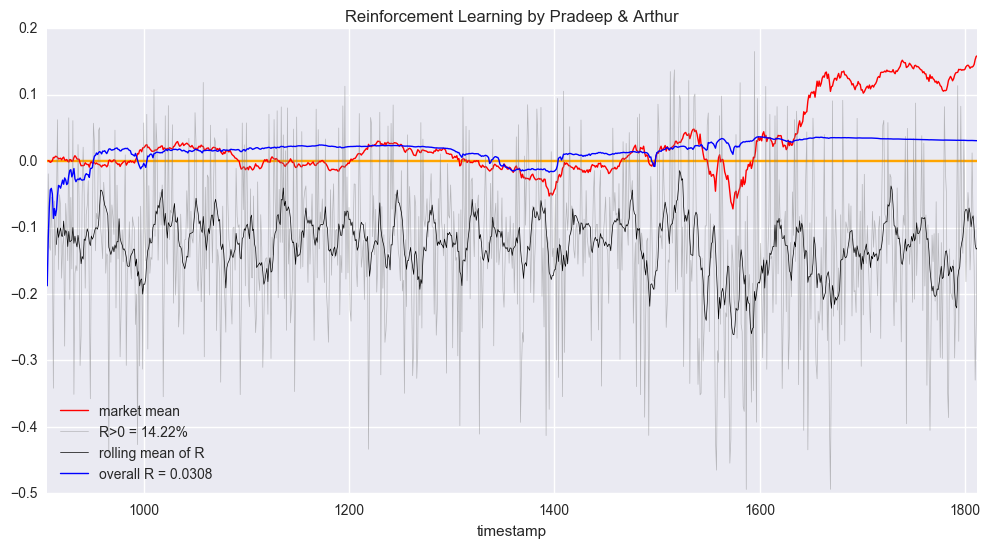

In [11]:
p7.plot()

## 2Sigma with RANSAC
- https://www.kaggle.com/adolphe/two-sigma-financial-modeling/two-sigma

In [9]:
import kagglegym

import numpy as np
import pandas as pd
import time
start = time.time()
import copy              
from sklearn.ensemble import (RandomForestRegressor,ExtraTreesRegressor ,
                                  BaggingRegressor, GradientBoostingRegressor  ,
                                 IsolationForest )
from sklearn.tree import DecisionTreeRegressor

from sklearn import preprocessing as prep
from sklearn.cross_validation import train_test_split as tts
from sklearn.metrics import r2_score
from sklearn import grid_search
from sklearn.linear_model import (LinearRegression, TheilSenRegressor, RANSACRegressor, 
                                      HuberRegressor,BayesianRidge,LassoLars,Ridge,Lasso,ElasticNet,
                                      ARDRegression,LogisticRegression,LassoCV)
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor 
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.svm import SVR
#The "environment" is our interface for code competitions

# The "environment" is our interface for code competitions
env = kagglegym.make()

# We get our initial observation by calling "reset"
observation = env.reset()
#DotProduct(sigma_0=rn, sigma_0_bounds=(1e-05, 10000))
                                      
estimators = [('RANSACReg', RANSACRegressor(base_estimator=LinearRegression(fit_intercept=False))),
        ('LinReg', LinearRegression(fit_intercept=False)),('Theil_Sen', TheilSenRegressor(fit_intercept=False)),
                  ('Ridge', Ridge(fit_intercept=False)),('HuberRegressor', HuberRegressor(fit_intercept=False)),
                 ('BayesRidge', BayesianRidge(fit_intercept=False)),('LassoLars', LassoLars(fit_intercept=False,alpha = 25)),
                  ('Lasso', Lasso(fit_intercept=False,alpha = 25)),('ElasticNet',ElasticNet(alpha=13,fit_intercept=False)),
                  ('ARDRegression',ARDRegression(fit_intercept=False))]
param_grid = {'n_estimators': np.random.randint(10,300,10),
                          'max_depth':np.random.randint(3,30,5),
                          'min_samples_split':(2,4,0.05,0.001,0.0001),
                          'max_features':('auto',0.5,0.05,1,'sqrt','log2'),
                          'min_weight_fraction_leaf':np.random.uniform(0,0.5,5)
                         }
# Note that the first observation we get has a "train" dataframe
trains=observation.train
print("Train has {} rows".format(len(trains)))

# The "target" dataframe is a template for what we need to predict:
print("Target column names: {}".format(", ".join(['"{}"'.format(col) for col in list(observation.target.columns)])))
param_grids = {'learning_rate': np.random.uniform(0.00001,0.9,10)} #'loss':('ls','lad','huber'),
                              #'max_features':('auto',0.5,0.005,10,'sqrt','log2'),
                              #'n_estimators': np.random.randint(100,200,3),
                              #,'max_depth':np.random.randint(2,50,5) , 
#print(model0.get_params().keys())
#mdl=MLPRegressor(warm_start=True)
mdl =Ridge()
#mdl=BaggingRegressor(base_estimator=ExtraTreesRegressor(max_depth=10),warm_start=True, n_jobs=-1)

mdl= BaggingRegressor(GradientBoostingRegressor(learning_rate=0.00000000000022227))
mdl=GradientBoostingRegressor(learning_rate=0.00000000000022227)
mdl=BaggingRegressor(GaussianProcessRegressor(n_restarts_optimizer=6),warm_start=True)#,warm_start=True)

#mdl=GaussianProcessRegressor(n_restarts_optimizer=36)
mdl=BaggingRegressor(base_estimator=SVR(kernel='linear', C=1e-3),warm_start=True)
seed=19781980
#good condition
#BaggingRegressor(base_estimator=SVR(kernel='linear', C=1e-4))  Timestamp you rare here 0.115240906412 False 1543
np.random.seed(seed)
#model0= RandomForestRegressor();
#', 'tol':np.random.uniform(0.0001,0.09,5),
 #'solver' :('auto', 'svd',  'lsqr', 'sparse_cg', 'sag')} #'cholesky'
print("Train has {} rows".format(len(observation.train)))

#The "target" dataframe is a template for what we need to predict:
print("Target column names: {}".format(", ".join(['"{}"'.format(col) for col in list(observation.target.columns)])))
#trains["timestamp"].unique())
#
def check_nan(dataframe,reject='no'):
    allcol = dataframe.columns;maxx=len(dataframe);bfor = maxx
    #print(dataframe.head())
    for na in allcol:
        nan0 = pd.isnull(dataframe[na]).sum()
        #print('sum of nan0',nan0,'maxx',maxx )
        
 
        if nan0/maxx >=0.70: #  drop columns with more than 70% of NaN
            #print('column removed',na)
            
            dataframe = dataframe.drop(na,1)
        else:
            if bfor>=nan0 and na!='y' and na!='id' and na!='timestamp':
                bfor=nan0;na0 = na # identified the column with minimum NaN
                #print('column kept nan',bfor)

    dfdropped = dataframe.dropna(0,subset=[na0])
    #print('dfdropped',dfdropped.columns)
    #print('dfdrop.shape:',dfdrop.shape,'dfdrop.columns',dfdrop.columns)
    return(dfdropped.fillna(dfdropped.median()))


       
#col_abov02 = ['id', 'timestamp', 'technical_2', 'technical_6', 'technical_11',
       #'technical_17', 'technical_22', 'technical_34', 'y']      
#target_var = 
## Check_nan

def PreprocessBox(dataframe,fil_method,testtrain='ok'):
    #res = dfRangeBox(pre_df[1],opt =1)
    import numpy as np
    from sklearn import preprocessing as prep
    #indx =trains["timestamp"].unique()

    #df_nona =dataframe.fillna(0) if fil_method==0 else dataframe
    #print(df_nona)
    df_nona0 = check_nan(dataframe,reject='yes')

    #df_nona = (dataframe.fillna(dataframe.mean()) if fil_method==3 else df_nona)
    df_nona1 = df_nona0.interpolate(method='akima') #if fil_method==4 else df_nona)
    df_nona = df_nona1.fillna(df_nona1.median()) #if fil_method==4 else df_nona1
    

    df_nona1 = pd.DataFrame(data=prep.robust_scale(df_nona,axis=0,quantile_range=(0,100))
                            ,columns=(df_nona.columns))
    df_nona0 = check_nan(df_nona1,reject='yes')

    #df_nona1 = pd.DataFrame(data=prep.StandardScaler(df_nona0,axis=0,quantile_range=(0,100))
                            #,columns=(df_nona0.columns))

                      
                           
  

    return(df_nona0)
#timestamp = observation.features["timestamp"][0]
    
#actual_y = list(df[df["timestamp"] == timestamp]["y"].values)
#print(len(actual_y))
#print(df[df.timestamp==906].head())
##print(observation.features.head())
#print(observation.train.head())
#print(observation.test.head())
lower_cut = -0.0860941; upper_cut = 0.0934978

rsqs =-10000000
scaler = StandardScaler()
lp=np.arange(402,452,1)
it=0;ite=0
bond=1000;ites1=0
rggg = np.arange(0,905,10);lop=True;lop1=True
tmsp = trains['timestamp']
trains = trains.drop('timestamp',1)
trains0 = PreprocessBox(trains,4,testtrain='ok')
allcol = trains0.columns
col_fund = allcol[7:70];col_der=allcol[2:7];col_tech=allcol[70:110]
y=trains0.loc[trains0.index,'y']
Xtrain =trains0.loc[trains0.index,trains0.columns.drop(col_der,1)]
Xtrain = Xtrain.loc[Xtrain.index,Xtrain.columns.drop(col_fund,1)]
todelete=['id','technical_1','technical_2','technical_3','technical_5','technical_6','technical_7','technical_9',
            'technical_10', 'technical_11', 'technical_12','technical_13',  'technical_16', 'technical_17',
            'technical_18', 'technical_19', 'technical_20', 'technical_21', 'technical_24', 'technical_25',
            'technical_27','technical_28', 'technical_30', 'technical_31','technical_32', 'technical_33', 
             'technical_35' , 'technical_36', 'technical_37', 'technical_38', 'technical_39', 'technical_40',
            'technical_41', 'technical_42', 'technical_44']
           
Xtrain = Xtrain.loc[Xtrain.index,Xtrain.columns.drop(todelete,1)]
Xtrain['timestamp']=tmsp
cols = Xtrain.columns.drop('y',1)

print(cols)
colss=[]

#model0.fit(Xtr,y)
#prd = mdl.predict(tX_test0.reshape(-1, 1))
#rrr2 =np.round(r2_score(ty_test0,prd),8)
lo_lim = 1000000;j=0;mdl_list=[]
j=j+1
while lop==True:
    Xtr = Xtrain[Xtrain.timestamp==rggg[j]]
    y = Xtr['y']
    Xtr=Xtr.drop('y',1)
    
    for i in np.random.randint(lo_lim,1000000000,2):
        tX_train0,tX_test0,ty_train0,ty_test0 = tts(Xtr,y,train_size=0.65,random_state = i)
        j=j+1
        #mdl0 = grid_search.GridSearchCV(mdl, param_grid=param_grid,cv=3, n_jobs=-1)
        #mdl0.fit(tX_train0, tX_train0).predict(tX_test0)
        prd=mdl.fit(tX_train0,ty_train0).predict(tX_test0)
        rrr2 =np.round(r2_score(ty_test0,prd),8)
        #print(rrr2)
        
        mdl_list.append(mdl)
        if rrr2 > rsqs:
            lo_lim=lo_lim+1000000 
            #print(tX_train0.shape)
            rsqs=rrr2
            model0=mdl
            mdl_list.append(mdl)
            r22 = (np.sign(rsqs)*np.sqrt(np.abs(rsqs)))
            print('R2 : ',rsqs,'r2_score : ',r22, 'i : ',i)
    tm = np.round(time.time() - start,4)
    lop = False if tm>=50 else True
    lop= False if j>=20 else lop
    j= 0 if j>= len(rggg)-2 else j 

print('time :',tm)

#print(len(cols))
print('pass')
#trains=trains.interpolate(method='akima')
#trains=trains.fillna(observation.features.median())
#trains = pd.DataFrame(data=prep.robust_scale(trains,axis=0,quantile_range=(0,100))
                            #,columns=(trains.columns))
def get_weighted_y(series):
    id, y = series["id"], series["y"]
    return 0.95 * y + 0.05 * ymean_dict[id] if id in ymean_dict else y


p8 = Performance('2Sigma with RANSAC')
k=0
prv_reward = 0;count=0;rew=0
while True:
    count=count+1
    target = observation.target
    timestamp = observation.features["timestamp"][0]
    #timestamp=1587
    if timestamp % 100 == 0:
        print("Timestamp #{}".format(timestamp), end='')
    df_nona = observation.features.interpolate(method='akima')
    df_nona =df_nona[cols.drop('timestamp',1)]
    #indx_test =df_nona["timestamp"].unique()
    df_nona = df_nona.fillna(df_nona.median()) 
    #print(observation.features.shape)
    df_nona0 = pd.DataFrame(data=prep.robust_scale(df_nona,axis=0,quantile_range=(0,100))
                            ,columns=(df_nona.columns))
    df_nona0["timestamp"] = timestamp                   
    #print(df_nona0.head())
    #df_nona0 = pd.DataFrame(data=prep.StandardScaler(df_nona,axis=0,quantile_range=(0,100))
                            #,columns=(df_nona.columns))
    observation.target.y =mdl_list[k].predict( df_nona0)
    #model0.predict( df_nona0)#mdl_list[k].predict( df_nona0)#mdl.predict( df_nona0)# 
    # We perform a "step" by making our prediction and getting back an updated "observation":
    pred_y = observation.target.y ### for Performance()
    observation, reward, done, info = env.step(target)
    k=k+1
    rew=rew+reward
    p8.update(timestamp,pred_y)
    if k>=len(mdl_list)-1:
        k=0
    if reward>=prv_reward:
        #done=True
        # print('you rare here',reward,done,timestamp)
        pass

    if timestamp % 100 == 0:
        print(reward,done,timestamp)

    if done:
        print('my av_reward',rew/count)
        print("Public score: {}".format(info["public_score"]))
        break

/Users/paulperry/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/paulperry/anaconda3/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Train has 806298 rows
Target column names: "id", "y"
Train has 806298 rows
Target column names: "id", "y"
Index(['derived_0', 'technical_14', 'technical_22', 'technical_29',
       'technical_34', 'technical_43', 'timestamp'],
      dtype='object')
R2 :  -0.03452686 r2_score :  -0.185814046832 i :  267671030
R2 :  0.01324796 r2_score :  0.115099782797 i :  627461306


/Users/paulperry/anaconda3/lib/python3.5/site-packages/sklearn/ensemble/bagging.py:346: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "


time : 33.7521
pass
Timestamp #1000-1 False 1000
Timestamp #1100-0.671395760192 False 1100
Timestamp #1200-0.99163774748 False 1200
Timestamp #1300-0.814792365089 False 1300
Timestamp #1400-0.510291394724 False 1400
Timestamp #1500-0.449173512723 False 1500
Timestamp #1600-0.36709547106 False 1600
Timestamp #1700-0.660072233816 False 1700
Timestamp #1800-0.60930199234 False 1800
my av_reward -0.710190758327
Public score: -0.6015668283224324


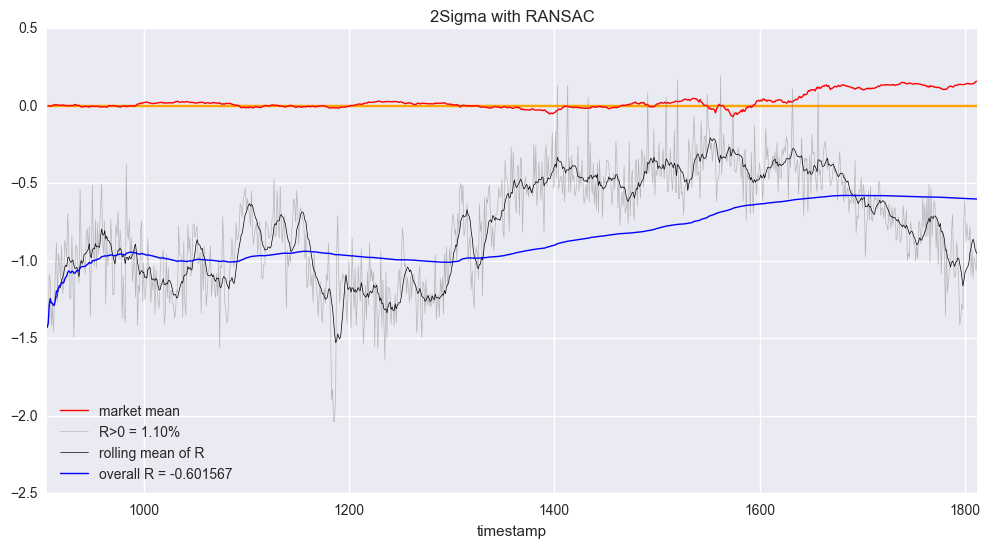

In [10]:
p8.plot()

## happycube two-feature-xgb
- https://www.kaggle.com/happycube/two-sigma-financial-modeling/202-with-two-feature-xgb/run/968991
- https://www.kaggle.com/happycube/two-sigma-financial-modeling/lightly-annotated-final-submission-13-51

In [26]:
import kagglegym
import numpy as np
import pandas as pd
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import xgboost as xgb
import math

import time

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge

from operator import itemgetter

localrun = True
usepublic = True
vmode = False
all_features = True # use w/vmode for feature selection.  run twice, cutting # of rounds to peak round

# This is taken from Frans Slothoubers post on the contest discussion forum.
# https://www.kaggle.com/slothouber/two-sigma-financial-modeling/kagglegym-emulation

def r_score(y_true, y_pred, sample_weight=None, multioutput=None):
    r2 = r2_score(y_true, y_pred, sample_weight=sample_weight,
                  multioutput=multioutput)
    r = (np.sign(r2)*np.sqrt(np.abs(r2)))
    if r <= -1:
        return -1
    else:
        return r

# From the xgboost script (along with the param settings)
    
# Function XGBOOST ########################################################
def xgb_obj_custom_r(y_pred, dtrain):
    y_true = dtrain.get_label()
    y_mean = np.mean(y_true)
    y_median = np.median(y_true)
    c1 = y_true
    #c1 = y_true - y_mean
    #c1 = y_true - y_median
    grad = 2*(y_pred-y_true)/(c1**2)
    hess = 2/(c1**2)
    return grad, hess

def xgb_eval_custom_r(y_pred, dtrain):
    #y_pred = np.clip(y_pred, -0.075, .075)
#    y_pred[y_pred > .075] = .075
#    y_pred[y_pred < -.075] = -.075
    y_true = dtrain.get_label()
    ybar = np.sum(y_true)/len(y_true)
    ssres = np.sum((y_true - y_pred) ** 2)
    sstot = np.sum((y_true - ybar)**2)
    r2 = 1 - ssres/sstot
    error = np.sign(r2) * np.absolute(r2)**0.5
    return 'error', error

env = kagglegym.make()
o = env.reset()

#excl = [env.ID_COL_NAME, env.SAMPLE_COL_NAME, env.TARGET_COL_NAME, env.TIME_COL_NAME]
excl = ['id', 'sample', 'y', 'timestamp']
basecols = [c for c in o.train.columns if c not in excl]


rcol_orig = ['Dtechnical_20', 'y_prev_pred_avg_diff', 'Dtechnical_21', 'technical_43_prev', 'technical_20', 'y_prev_pred_avgT0', 'y_prev_pred_mavg5', 'y_prev_pred_avgT1', 'fundamental_8_prev', 'Dtechnical_40', 'technical_7_prev', 'technical_7', 'fundamental_5', 'Dtechnical_30', 'technical_32_prev', 'technical_14_prev', 'fundamental_1', 'fundamental_43_prev', 'Dfundamental_22', 'Dtechnical_35', 'Dtechnical_6', 'Dtechnical_17', 'Dtechnical_27', 'Dfundamental_42', 'fundamental_1_prev', 'Dtechnical_0', 'technical_40', 'technical_40_prev', 'fundamental_36', 'Dfundamental_33', 'Dfundamental_48', 'technical_27_prev', 'fundamental_62_prev', 'fundamental_41_prev', 'Dfundamental_50', 'fundamental_48', 'derived_2_prev', 'Dtechnical_18', 'fundamental_35', 'Dfundamental_49', 'fundamental_26_prev', 'technical_28_prev', 'Dfundamental_63', 'fundamental_10_prev', 'fundamental_36_prev', 'fundamental_16', 'Dfundamental_8', 'fundamental_32', 'fundamental_40_prev', 'derived_0', 'Dfundamental_32', 'fundamental_17', 'Dtechnical_7', 'fundamental_25', 'technical_35', 'Dtechnical_19', 'technical_35_prev', 'fundamental_8', 'Dtechnical_32', 'Dfundamental_18', 'Dtechnical_37', 'fundamental_33_prev', 'Dtechnical_28', 'fundamental_46', 'Dfundamental_1', 'Dfundamental_45', 'fundamental_18', 'technical_12', 'technical_44', 'fundamental_22', 'Dtechnical_5', 'technical_17_prev', 'Dfundamental_25']
rcol = rcol_orig.copy()

if all_features:
    rcol = []
    for c in basecols:
        rcol.append(c)
        rcol.append(c + '_prev')
        rcol.append('D' + c)

backy_fset = ['technical_13', 'technical_20', 'technical_13_prev', 'technical_20_prev', 'technical_30_prev', 'technical_30']
for f in backy_fset:
    if f not in rcol:
        rcol.append(f)

def get_basecols(rcol):
    duse = {}

    for r in rcol:
        if 'y' in r:
            continue

        if 'D' in r:
            duse[r[1:]] = True
        elif '_prev' in r:
            duse[r[:-5]] = True
        elif r in basecols:
            duse[r] = True

    return [k for k in duse.keys()]

basecols_touse = get_basecols(rcol)

if vmode:
    train = pd.read_hdf('../input/train.h5')
else:
    train = o.train.copy()

d_mean = o.train[basecols_touse].median(axis=0)
for c in basecols_touse:
    d_mean[c + '_prev'] = d_mean[c]
    d_mean['D' + c] = 0

median = {t[0]:t[1] for t in zip(d_mean.index, d_mean.values)}
median['y'] = 0

print('processed medians')

class DataPrep:
    
    def __init__(self, yprev_model = None, keepinput = True, cols = rcol):
        self.previnput = None
        self.prevavg = 0
        self.cols = cols.copy()
        
        self.basecols = get_basecols(self.cols)
        self.keepcols = ['y', 'id', 'timestamp'] + self.basecols
        
        self.allinput = [] if keepinput else None
        
        self.dayavg = []
        
        self.yprev_model = yprev_model
        
    def procday(self, day_in):
        
        if 'y' not in day_in and 'y' in self.keepcols:
            self.keepcols.remove('y')
        
        day = day_in[self.keepcols].copy()
        
        notinnew = []
        
        if self.previnput is not None:
            olen = len(day)
            day = pd.merge(day, self.previnput, on='id', how = 'left', suffixes=['', '_prev'])
            notinnew = self.previnput[~self.previnput.id.isin(day_in.id)].copy()
            #print(day.iloc[0].timestamp, len(notinnew))
        else:
            for c in self.basecols:
                day[c + '_prev'] = np.full_like(day[c], 0, dtype=np.float32)
                #day[c + '_prev'] = np.zeros_like(day[c], dtype=np.float32)
        
        for c in self.cols:
            if c == 'y_prev_pred':
                continue

            if c[0] == 'D':
                day[c] = day[c[1:]] - day[c[1:] + '_prev']
                
        self.previnput = day_in[self.keepcols].copy()
        if len(notinnew) > 0:
            self.previnput = self.previnput.append(notinnew[self.keepcols])
        
        if self.yprev_model:
            day['y_prev_pred'] = self.yprev_model.predict(day[backy_fset].fillna(d_mean).values.reshape(-1,len(backy_fset)))

            avg = day.y_prev_pred.mean()

            self.dayavg.append(avg)
            day['y_prev_pred_mavg5'] = np.ma.average(np.array(self.dayavg[-5:]))#, weights=range(1, len(self.dayavg[-10:]) + 1))
            day['y_prev_pred_min5'] = day.y_prev_pred - day.y_prev_pred_mavg5
            day['y_prev_pred_mavg5d'] = avg - np.ma.average(np.array(self.dayavg[-5:]))
            
            day['y_prev_pred_mavg10'] = np.ma.average(np.array(self.dayavg[-10:]))#, weights=range(1, len(self.dayavg[-10:]) + 1))
            day['y_prev_pred_mavg20'] = np.ma.average(np.array(self.dayavg[-20:]))
            day['y_prev_pred_mavg40'] = np.ma.average(np.array(self.dayavg[-40:]))
            
            day['y_prev_pred_avgT1'] = self.prevavg
            day['y_prev_pred_avgT0'] = avg
            day['y_prev_pred_avg_diff'] = avg - self.prevavg

            self.prevavg = avg
            
        if self.allinput is not None:
            self.allinput.append(day.copy())

        return day
    
    def run(self, df):
        assert self.allinput is not None
        
        for g in df.groupby('timestamp'):
            self.procday(g[1])
            
        return pd.concat(self.allinput)

yptrain = DataPrep(keepinput=True, cols=backy_fset).run(train)

#yptrain_prep = tmp.run(yptrain)

yptrain.sort_values(['id', 'timestamp'], inplace=True)

ypmodel = LinearRegression(n_jobs=-1)
low_y_cut = -0.0725
high_y_cut = 0.075

mask = np.logical_and(yptrain.y > low_y_cut, yptrain.y < high_y_cut)
for f in backy_fset:
    mask = np.logical_and(mask, ~yptrain[f].isnull())
    
yptraina = yptrain[mask]
ypmodel.fit(yptraina[backy_fset].values.reshape(-1,len(backy_fset)), yptraina.y_prev.fillna(0))

print(len(yptraina), ypmodel.coef_, ypmodel.intercept_)

#630210 [  4.94327753  10.22880098  -4.53049511  -9.34886941   8.94329596
#  -9.83007277] -2.68988841901e-05


d_mean['y'] = 0

start = time.time()

train = DataPrep(keepinput = True, yprev_model = ypmodel).run(train)

print('train proc')

endt = time.time()
print(endt - start)

dcol = [c for c in train.columns if c not in excl]

if usepublic:
    data_all = pd.read_hdf('../input/train.h5', mode='r')

    #public = data_all[data_all.timestamp > 905]
    allpublic = DataPrep(yprev_model = ypmodel, keepinput=True).run(data_all)
    public = DataPrep(yprev_model = ypmodel, keepinput=True).run(data_all[data_all.timestamp > 905])

print(r_score(train.y_prev.fillna(0), train.y_prev_pred))

if usepublic:
    print(r_score(public.y_prev.fillna(0), public.y_prev_pred))

train.sort_values(['id', 'timestamp'], inplace=True)

print('prepping xgb now')
xtrain, xvalid = train_test_split(train, test_size = 0.2, random_state = 2017)

cols_to_use = [c for c in rcol if c in xtrain.columns and c in rcol_orig] 

                                                      
# Convert to XGB format
to_drop = ['timestamp', 'y']
xtrain = xtrain[np.abs(xtrain['y']) < 0.018976588919758796]
#xtrain = xtrain[np.abs(xtrain['y']) < 0.015]
train_xgb = xgb.DMatrix(data=xtrain[cols_to_use],
                        label=xtrain['y'])

#del xtrain

# determined by using testing w/public set that this matches public_xgb better.
# higher values make it end sooner.
#xvalid = xvalid[np.abs(xvalid['y']) > 0.009]
valid_xgb = xgb.DMatrix(data=xvalid[cols_to_use],
                        label=xvalid['y'])

#del xvalid

evallist = [(train_xgb, 'train'), (valid_xgb, 'valid')]

if usepublic:
    public_xgb = xgb.DMatrix(data=public[cols_to_use], label=public['y'])

    evallist = [(train_xgb, 'train'), (valid_xgb, 'xvalid'), (public_xgb, 'public')]

print('xtrain+valid')

params = {
    'objective': 'reg:linear'
    ,'eta': 0.08
    ,'max_depth': 3
    , 'subsample': 0.9
    #, 'colsample_bytree': 1
    ,'min_child_weight': 2**11
    #,'gamma': 100
    , 'seed': 10
    #, 'base_score': 0
}


model = []
for seed in [5041976, 31338]:
    params['seed'] = seed
    model.append(xgb.train(params.items()
                  , dtrain=train_xgb
                  , num_boost_round=90
                  , evals=evallist
                  , early_stopping_rounds=20
                  , maximize=True
                  , verbose_eval=10
                  , feval=xgb_eval_custom_r
                  ))

if not localrun:
    del train_xgb
    del valid_xgb
    if usepublic:
        del public_xgb

print('xgb done, linear now')

lin_features = ['Dtechnical_20', 'technical_20', 'Dtechnical_21']

def prep_linear(df, c = lin_features):
    df_tmp = df.fillna(d_mean)
    m2mat = np.zeros((len(df), len(c)))
    for i in range(len(c)):
        m2mat[:,i] = df_tmp[c[i]].values
    
    return m2mat

# Observed with histograns:
#https://www.kaggle.com/bguberfain/two-sigma-financial-modeling/univariate-model-with-clip/run/482189
low_y_cut = -0.075
high_y_cut = 0.075
traincut = train[np.logical_and(train.y > low_y_cut, train.y < high_y_cut)][['y'] + lin_features].copy().fillna(d_mean)

model2 = LinearRegression(n_jobs=-1)
model2.fit(prep_linear(traincut), traincut.y)

print('linear done')

if vmode:
    preds_xgb = model[0].predict(valid_xgb, ntree_limit=model[0].best_ntree_limit)
    preds_linear = model2.predict(prep_linear(xvalid))
    
    preds = (preds_xgb * 0.7) + (preds_linear * 0.3)
    #preds = preds_xgb
    
    rs = kagglegym.r_score(xvalid.y, preds)
    
    ID = 'expv-{0}.pkl'.format(int(rs * 10000000))
    print(rs, ID)
    
    #ID = 'subv-203172.pkl' # if actual submission
    
    output = xvalid[['id', 'timestamp', 'y']].copy()
    output['y_hat'] = preds
    output['y_hat_xgb'] = preds_xgb
    output['y_hat_linear'] = preds_linear
    
    output.to_pickle(ID)

if all_features:
    m = model[0]

    fs = m.get_fscore()
    fsl = [(f,fs[f]) for f in fs.keys()]
    fsl = sorted(fsl, key=itemgetter(1), reverse=True)

    len(fsl)

    print('rcol =', [f[0] for f in fsl])

razz_params = {
    'objective': 'reg:linear'
    ,'eta': 0.04
    ,'max_depth': 3
    , 'subsample': 0.9
    #, 'colsample_bytree': 1
    ,'min_child_weight': 2**11
    #,'gamma': 100
    , 'seed': 10
    #, 'base_score': 0
}

frazz = ['Dtechnical_20', 'technical_43_prev']
dtrain_razz = xgb.DMatrix(xtrain[frazz], label = xtrain.y)
dvalid_razz = xgb.DMatrix(xvalid[frazz], label = xvalid.y)
razz_evallist = [(dvalid_razz, 'xvalid'), (dtrain_razz, 'train')]
if usepublic:
    dpublic_razz = xgb.DMatrix(public[frazz], label = public.y)
    razz_evallist = [(dtrain_razz, 'train'), (dvalid_razz, 'xvalid'), (dpublic_razz, 'public')]
    
model_razz = xgb.train(razz_params.items()
                  , dtrain=dtrain_razz
                  , num_boost_round=400 if usepublic else 188
                  , evals=razz_evallist
                  , early_stopping_rounds=20
                  , maximize=True
                  , verbose_eval=10
                  , feval=xgb_eval_custom_r)

start = time.time()        

dprep = DataPrep(yprev_model = ypmodel, keepinput=localrun)
        

if localrun:
    env = kagglegym.make()
    o = env.reset()

p9 = Performance('happycube final-submission')
while True:
    test_preproc = o.features.copy()
    
    #if c in basecols:
        #test_preproc.fillna(d_mean, inplace=True)
    
    test = dprep.procday(test_preproc)
    
    #test.fillna(0, inplace=True)
    
    test_xgb = xgb.DMatrix(data=test.drop(['id', 'timestamp'], axis=1)[cols_to_use])
    test_xgb_razz = xgb.DMatrix(data=test.drop(['id', 'timestamp'], axis=1)[frazz])

    xgbpreds = np.zeros(len(test), dtype=np.float64)
    for m in model:
        xgbpreds += m.predict(test_xgb, ntree_limit=m.best_ntree_limit)
    xgbpreds /= len(model)
    
    preds_razz = model_razz.predict(test_xgb_razz, ntree_limit=model_razz.best_ntree_limit)
    
    preds_linear = model2.predict(prep_linear(test)).clip(low_y_cut, high_y_cut)
    
    test_y = (preds_razz * 0.25) + (xgbpreds * 0.55) + (preds_linear * 0.2)
    
    o.target['y'] = test_y
    target = o.target
    
    timestamp = o.features["timestamp"][0]
    if timestamp % 100 == 0:
        print("Timestamp #{0} {1}".format(timestamp, time.time() - start))
        start = time.time()

    p9.update(timestamp,test_y)
    # We perform a "step" by making our prediction and getting back an updated "observation":
    o, reward, done, info = env.step(target)
    if done:
        print("Public score: {}".format(info["public_score"]))
        break

processed medians
788557 [  4.7967096   10.07235529  -4.38579377  -9.20176369   8.77051007
  -9.62992077] -6.13848550352e-05
train proc
57.31120586395264
0.822220728131
0.818093292415
prepping xgb now
xtrain+valid
[0]	train-rmse:0.460114	xvalid-rmse:0.46026	public-rmse:0.460378	train-error:-50.8505	xvalid-error:-21.0952	public-error:-20.0598
Multiple eval metrics have been passed: 'public-error' will be used for early stopping.

Will train until public-error hasn't improved in 20 rounds.
[10]	train-rmse:0.200033	xvalid-rmse:0.200734	public-rmse:0.200922	train-error:-22.0887	xvalid-error:-9.15618	public-error:-8.70831
[20]	train-rmse:0.087273	xvalid-rmse:0.089217	public-rmse:0.089539	train-error:-9.59506	xvalid-error:-3.96968	public-error:-3.7761
[30]	train-rmse:0.038776	xvalid-rmse:0.043289	public-rmse:0.043887	train-error:-4.16795	xvalid-error:-1.71622	public-error:-1.63273
[40]	train-rmse:0.018707	xvalid-rmse:0.027074	public-rmse:0.028005	train-error:-1.80996	xvalid-error:-0.737082	p

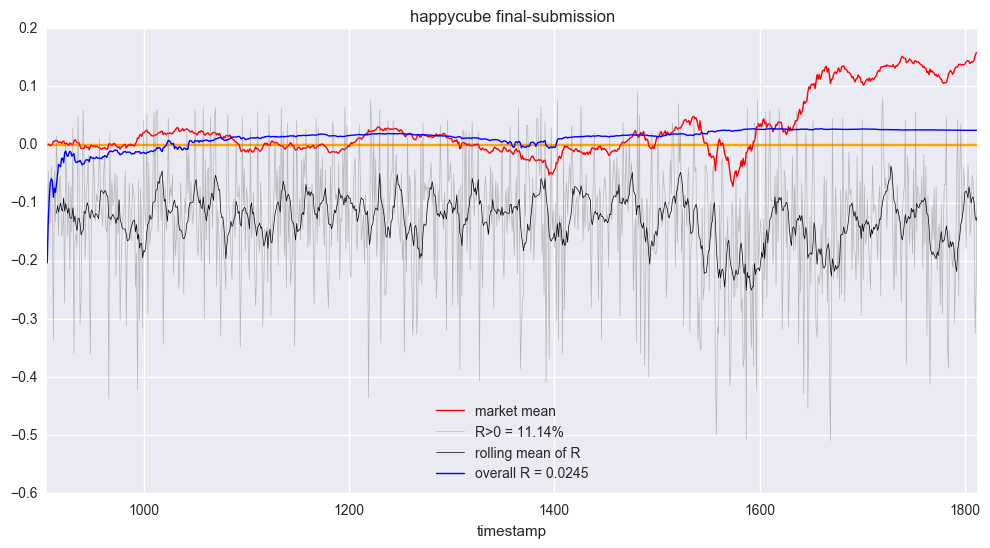

In [27]:
0.02341814
p9.plot()

## two-sigma-playground by trottefox
- best public kernel score
- https://www.kaggle.com/trottefox/two-sigma-financial-modeling/two-sigma-playground/run/850759
- public score: 0.0139441
- train: 0.0222018889099

In [56]:
env = kagglegym.make()
o = env.reset()
train = o.train
print(train.shape)
d_mean= train.median(axis=0)
train["nbnulls"]=train.isnull().sum(axis=1)
col=[x for x in train.columns if x not in ['id', 'timestamp', 'y']]

rnd=17

#keeping na information on some columns (best selected by the tree algorithms)
add_nas_ft=True
nas_cols=['technical_9', 'technical_0', 'technical_32', 'technical_16', 'technical_38', 
'technical_44', 'technical_20', 'technical_30', 'technical_13']
#columns kept for evolution from one month to another (best selected by the tree algorithms)
add_diff_ft=True
diff_cols=['technical_22','technical_20', 'technical_30', 'technical_13', 'technical_34']

#homemade class used to infer randomly on the way the model learns
class createLinearFeatures:
    
    def __init__(self, n_neighbours=1, max_elts=None, verbose=True, random_state=None):
        self.rnd=random_state
        self.n=n_neighbours
        self.max_elts=max_elts
        self.verbose=verbose
        self.neighbours=[]
        self.clfs=[]
        
    def fit(self,train,y):
        if self.rnd!=None:
            random.seed(self.rnd)
        if self.max_elts==None:
            self.max_elts=len(train.columns)
        list_vars=list(train.columns)
        random.shuffle(list_vars)
        
        lastscores=np.zeros(self.n)+1e15

        for elt in list_vars[:self.n]:
            self.neighbours.append([elt])
        list_vars=list_vars[self.n:]
        
        for elt in list_vars:
            indice=0
            scores=[]
            for elt2 in self.neighbours:
                if len(elt2)<self.max_elts:
                    clf=linear_model.LinearRegression(fit_intercept=False, normalize=True, copy_X=True, n_jobs=-1) 
                    clf.fit(train[elt2+[elt]], y)
                    scores.append(metrics.mean_squared_error(y,clf.predict(train[elt2 + [elt]])))
                    indice=indice+1
                else:
                    scores.append(lastscores[indice])
                    indice=indice+1
            gains=lastscores-scores
            if gains.max()>0:
                temp=gains.argmax()
                lastscores[temp]=scores[temp]
                self.neighbours[temp].append(elt)

        indice=0
        for elt in self.neighbours:
            clf=linear_model.LinearRegression(fit_intercept=False, normalize=True, copy_X=True, n_jobs=-1) 
            clf.fit(train[elt], y)
            self.clfs.append(clf)
            if self.verbose:
                print(indice, lastscores[indice], elt)
            indice=indice+1
                    
    def transform(self, train):
        indice=0
        for elt in self.neighbours:
            #this line generates a warning. Could be avoided by working and returning
            #with a copy of train.
            #kept this way for memory management
            train['neighbour'+str(indice)]=self.clfs[indice].predict(train[elt])
            indice=indice+1
        return train
    
    def fit_transform(self, train, y):
        self.fit(train, y)
        return self.transform(train)

#a home-made class attempt to remove outliers by successive quantization on residuals
class recurrent_linear_approx():
    def __init__(self, quant=.999, limit_size_train=.9):
        self.quant=quant
        self.limit_size_train=limit_size_train
        self.bestmodel=[]
       
    def fit(self, train, y):
        internal_model=linear_model.LinearRegression()
        bestscore=1e15
        better=True
        indextrain=train.dropna().index
        limitlen=len(train)*self.limit_size_train
        while better:
            internal_model.fit(train.ix[indextrain], y.ix[indextrain])
            score=metrics.mean_squared_error(internal_model.predict(train.ix[indextrain]), y.ix[indextrain])
            if score < bestscore:
                bestscore=score
                self.bestmodel=internal_model
                residual=y.ix[indextrain]-internal_model.predict(train.ix[indextrain])
                indextrain=residual[abs(residual)<=abs(residual).quantile(self.quant)].index
                if len(indextrain)<limitlen:
                    better=False
            else:
                better=False
                self.bestmodel=internal_model

    def predict(self, test):
        return self.bestmodel.predict(test)

if add_nas_ft:
    for elt in nas_cols:
        train[elt + '_na'] = pd.isnull(train[elt]).apply(lambda x: 1 if x else 0)
        #no need to keep columns with no information
        if len(train[elt + '_na'].unique())==1:
            print("removed:", elt, '_na')
            del train[elt + '_na']
            nas_cols.remove(elt)


if add_diff_ft:
    train=train.sort_values(by=['id','timestamp'])
    for elt in diff_cols:
        #a quick way to obtain deltas from one month to another but it is false on the first
        #month of each id
        train[elt+"_d"]= train[elt].rolling(2).apply(lambda x:x[1]-x[0]).fillna(0)
    #removing month 0 to reduce the impact of erroneous deltas
    train=train[train.timestamp!=0]

print(train.shape)
cols=[x for x in train.columns if x not in ['id', 'timestamp', 'y']]


#generation of linear models
cols2fit=['technical_22','technical_20', 'technical_30_d', 'technical_20_d', 'technical_30', 
'technical_13', 'technical_34']
models=[]
columns=[]
residuals=[]
for elt in cols2fit:
    print("fitting linear model on ", elt)
    model=recurrent_linear_approx(quant=.99, limit_size_train=.9)
    model.fit(train.loc[:,[elt]],train.loc[:, 'y'])
    models.append(model)
    columns.append([elt])
    residuals.append(abs(model.predict(train[[elt]].fillna(d_mean))-train.y))

train=train.fillna(d_mean)
    
#adding all trees generated by a tree regressor
print("adding new features")
featureexpander=createLinearFeatures(n_neighbours=30, max_elts=2, verbose=True, random_state=rnd)
index2use=train[abs(train.y)<0.086].index
featureexpander.fit(train.ix[index2use,cols],train.ix[index2use,'y'])
trainer=featureexpander.transform(train[cols])
treecols=trainer.columns

print("training trees")
model = ensemble.ExtraTreesRegressor(n_estimators=100, max_depth=4, n_jobs=-1, random_state=rnd, verbose=0)
model.fit(trainer,train.y)
print(pd.DataFrame(model.feature_importances_,index=treecols).sort_values(by=[0]).tail(30))
for elt in model.estimators_:
    models.append(elt)
    columns.append(treecols)
    residuals.append(abs(elt.predict(trainer)-train.y))


#model selection : create a new target selecting models with lowest asolute residual for each line
#the objective at this step is to keep only the few best elements which should
#lead to a better generalization
num_to_keep=10
targetselector=np.array(residuals).T
targetselector=np.argmin(targetselector, axis=1)
print("selecting best models:")
print(pd.Series(targetselector).value_counts().head(num_to_keep))

tokeep=pd.Series(targetselector).value_counts().head(num_to_keep).index
tokeepmodels=[]
tokeepcolumns=[]
tokeepresiduals=[]
for elt in tokeep:
    tokeepmodels.append(models[elt])
    tokeepcolumns.append(columns[elt])
    tokeepresiduals.append(residuals[elt])

#creating a new target for a model in charge of predicting which model is best for the current line
targetselector=np.array(tokeepresiduals).T
targetselector=np.argmin(targetselector, axis=1)

print("training selection model")
modelselector = ensemble.ExtraTreesClassifier(n_estimators=100, max_depth=4, n_jobs=-1, random_state=rnd, verbose=0)
modelselector.fit(trainer, targetselector)
print(pd.DataFrame(modelselector.feature_importances_,index=treecols).sort_values(by=[0]).tail(30))

lastvalues=train[train.timestamp==905][['id']+diff_cols].copy()

print("end of trainind, now predicting")


(806298, 111)
(805548, 126)
fitting linear model on  technical_22
fitting linear model on  technical_20
fitting linear model on  technical_30_d
fitting linear model on  technical_20_d
fitting linear model on  technical_30
fitting linear model on  technical_13
fitting linear model on  technical_34
adding new features
0 0.000377842283342 ['fundamental_44', 'fundamental_20']
1 0.000377792151964 ['technical_37', 'technical_30_d']
2 0.000377782998839 ['fundamental_53', 'fundamental_59']
3 0.000377832649974 ['technical_13_na', 'fundamental_32']
4 0.000377836404368 ['fundamental_37', 'technical_43']
5 0.000377835837828 ['fundamental_0', 'technical_34_d']
6 0.000377841672162 ['technical_14', 'fundamental_17']
7 0.000377830030629 ['fundamental_40', 'technical_12']
8 0.000377840857254 ['technical_44', 'fundamental_16']
9 0.000377830583602 ['technical_9', 'technical_30_na']
10 0.000377797987312 ['fundamental_23', 'technical_38_na']
11 0.000377841555746 ['technical_21', 'fundamental_12']
12 0.0003

/Users/paulperry/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


training trees
                     0
fundamental_48  0.0083
technical_19    0.0083
technical_32_na 0.0084
technical_7     0.0089
technical_36    0.0094
technical_14    0.0095
technical_35    0.0098
fundamental_18  0.0106
technical_44_na 0.0107
neighbour17     0.0108
neighbour18     0.0122
technical_6     0.0124
neighbour2      0.0130
neighbour1      0.0133
fundamental_53  0.0134
technical_17    0.0138
technical_30_d  0.0142
fundamental_58  0.0143
neighbour27     0.0144
neighbour16     0.0158
technical_20_d  0.0185
technical_43    0.0209
neighbour10     0.0221
technical_2     0.0386
technical_11    0.0534
neighbour25     0.0590
fundamental_11  0.0726
technical_20    0.0766
technical_30    0.0818
neighbour29     0.0850
selecting best models:
0     196593
2      65423
57     58913
1      53319
15     51771
4      40061
3      32855
56     30691
20     27530
12     24106
dtype: int64
training selection model
                     0
technical_39    0.0063
technical_28    0.0063
technical_21

In [ ]:
##
p10 = Performance('two-sigma-playground by trottefox')
indice=0
countplus=0
rewards=[]
while True:
    indice+=1
    timestamp = o.features["timestamp"][0]
    test = o.features
    test["nbnulls"]=test.isnull().sum(axis=1)
    if add_nas_ft:
        for elt in nas_cols:
            test[elt + '_na'] = pd.isnull(test[elt]).apply(lambda x: 1 if x else 0)
    test=test.fillna(d_mean)

    pred = o.target
    if add_diff_ft:
        #creating deltas from lastvalues
        indexcommun=list(set(lastvalues.id) & set(test.id))
        lastvalues=pd.concat([test[test.id.isin(indexcommun)]['id'],
            pd.DataFrame(test[diff_cols][test.id.isin(indexcommun)].values-lastvalues[diff_cols][lastvalues.id.isin(indexcommun)].values,
            columns=diff_cols, index=test[test.id.isin(indexcommun)].index)],
            axis=1)
        #adding them to test data    
        test=test.merge(right=lastvalues, how='left', on='id', suffixes=('','_d')).fillna(0)
        #storing new lastvalues
        lastvalues=test[['id']+diff_cols].copy()
    
    testid=test.id
    test=featureexpander.transform(test[cols])
    #prediction using modelselector and models list
    selected_prediction = modelselector.predict_proba(test.loc[: ,treecols])
    for ind,elt in enumerate(tokeepmodels):
        pred['y']+=selected_prediction[:,ind]*elt.predict(test[tokeepcolumns[ind]])

    indexbase=pred.index
    pred.index=testid    
    oldpred=pred['y']
    pred.index=indexbase
    
    target=pred
    o, reward, done, info = env.step(pred)
    rewards.append(reward)
    if reward>0:
        countplus+=1
    
    if indice%100==0:
        print(indice, countplus, reward, np.mean(rewards))
    
    p10.update(timestamp, target.y)
    
    if done:
        print(info["public_score"])
        break

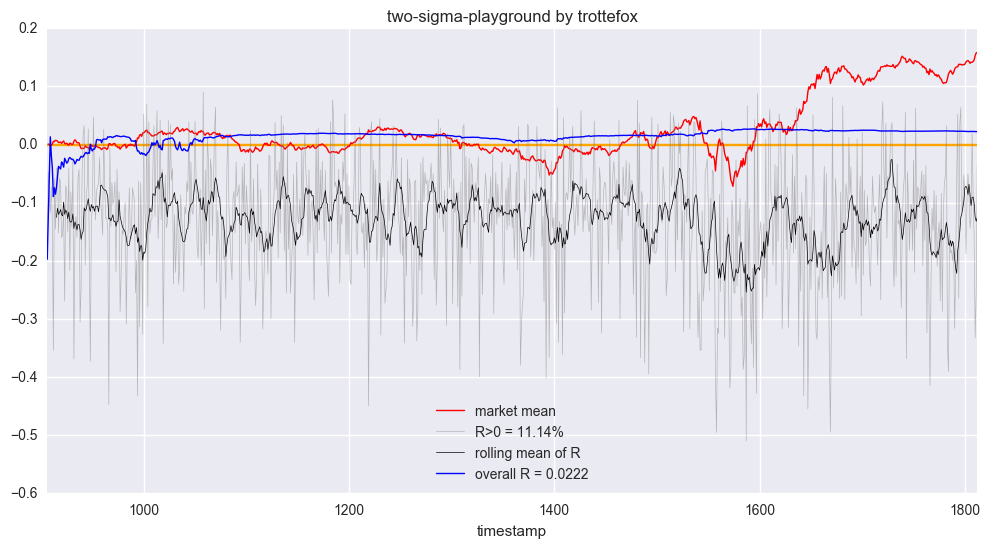

In [53]:
p10.plot()

## two-sigma-playground-clarified-and-criticised
https://www.kaggle.com/optimism/two-sigma-financial-modeling/two-sigma-playground-clarified-and-criticised

In [22]:
# This script is a clarified and criticised version of Trottefox's acclaimed "Two sigma
# playground" kernel (half train holdout 0.020876, pub LB 0.0149618).
# 
# (It may very well have a long history of forks before that and contributions by others,
# I did not follow the source trail; apologies if I ought to add credits.)
# 
# I (SK) am not really competing in this competition, but want to contribute my two cents
# this way. In my opinion the original script is (1) unnecessarily unclear due mostly to
# lack of comments and unfortunate variable naming, and (2) is methodologically unsound,
# reinventing many wheels but making them square, triangle, and elliptic instead of
# circular. This does a disservice to novices and as a result to our fine community.
# 
# One general thing to keep in mind here is that there is very low SNR in this problem,
# and it echos loudly in the evaluation metric (small changes to model can wildly change
# even the half-trainset validation score). On top of that, nonstationarity is a big
# issue, and so behavior in the second half of the trainset, the public leaderboard, and
# (supposedly) the private leaderboard is different. So do yourselves a big favor and
# don't take results in validation / public too seriously as predictors of the private
# score. The public ranking of this script will have much more to do with the correlation
# between competitors' solutions than its intrinsic quality. All that glitters is not
# gold.
# 
# All of this is not to say that the original script doesn't include several nice
# elementary ideas that are good to know and use. Let's just try to make them more
# accessible.

import kagglegym
import numpy as np
import pandas as pd
import random
from sklearn import ensemble, linear_model, metrics

# Configuration
# ========================================================================================

add_na_indicators = True
add_diff_features = True
na_indicator_cols = ['technical_9', 'technical_0', 'technical_32', 'technical_16', 
    'technical_38', 'technical_44', 'technical_20', 'technical_30', 'technical_13'] 
    # allegedly selected by tree-based algorithms
diff_cols = ['technical_22', 'technical_20', 'technical_30', 'technical_13', 
    'technical_34'] # also allegedly selected by tree-based algorithms
univar_rlm_cols = ['technical_22', 'technical_20', 'technical_30_d1', 'technical_20_d1',
    'technical_30', 'technical_13', 'technical_34']
nr_l2_best_models = 10
wrlm_quant = 0.99
wrlm_min_trainset_fraction = 0.9
wslm_n_covar_sets = 30
wslm_max_nr_covars_per_set = 2
wslm_max_abs_y = 0.086
l1_et_n_estimators = 100
l1_et_max_depth = 4
l3_et_n_estimators = 100
l3_et_max_depth = 4
rnd_seed = 17

# Helper functions and objects
# ========================================================================================

# FIXME: This is a weird reinvention of the stepwise regression wheel: We are going to
# greedily choose n_covar_sets of covariate sets and build linear models based on each
# set. We are going to do this in a way that is quite arbitrary and irrational. We'd
# probably be better off with something like linear XGB or lasso.

class weird_stepwise_lm:
    def __init__(self, n_covar_sets = 30, max_nr_covars_per_set = 2, verbose = True):
        self.n_covar_sets = n_covar_sets
        self.max_nr_covars_per_set = max_nr_covars_per_set
        self.verbose = verbose
        
        if self.max_nr_covars_per_set == None:
            self.max_nr_covars_per_set = len(train.columns)
        self.chosen_covar_sets = []
        self.models = []
        
    def fit(self, train, y):
        # We initialize the sets such that each one includes a single random unique feature.
        
        covar_pool = list(train.columns)
        random.shuffle(covar_pool)
        for var in covar_pool[:self.n_covar_sets]:
            self.chosen_covar_sets.append([var])
        covar_pool = covar_pool[self.n_covar_sets:]
        
        # Now we are going to do greedy forward stepwise regression in a very strange way:
        # We go over the set of covariates not chosen initially, and see to which set will
        # adding this new covariate improve the training error the most. We then add this 
        # new covariate to that set. When the maximum number of covariates 
        # max_nr_covars_per_set is reached, that set is no longer considered for adding 
        # new variables.
        
        # FIXME: it doesn't make sense to look at training error when considering the 
        # improvement achieved by adding covariates (except in degenerate cases, adding 
        # will always improve the training error, but the question is how much is useful 
        # fitting and how much is just overfitting). We should use Cp/AIC/SURE/CV to 
        # estimate out of sample error! (note that when max_nr_covars_per_set = 2, 
        # Cp/AIC/SURE and in sample error selection are in fact equivalent for the purpose
        # of deciding to which set a given covariate should be added, but not whether it
        # should be added at all!)
        
        # FIXME: I don't understand the rationale behind only considering disjoint 
        # covariate sets.
        
        # initialize to a big value any model will beat
        best_mses_by_set = np.zeros(self.n_covar_sets) + 1e15
        
        for var in covar_pool:
            ci = 0
            mses_per_candidate_covar = []
            for covar_set in self.chosen_covar_sets:
                if len(covar_set) < self.max_nr_covars_per_set:
                    model = linear_model.LinearRegression(fit_intercept = False, 
                        normalize = True, copy_X = True, n_jobs = -1) 
                    model.fit(train[covar_set + [var]], y)
                    # FIXME this is not a good measure of model quality
                    mse = metrics.mean_squared_error(y, model.predict(train[covar_set +
                        [var]]))
                    mses_per_candidate_covar.append(mse)
                else:
                    mses_per_candidate_covar.append(best_mses_by_set[ci])
                ci += 1
            
            gains = best_mses_by_set - mses_per_candidate_covar
            # currently, this will always be true (except degenerate cases), and is meant
            # for when we maxed out the max_nr_covars_per_set
            if gains.max() > 0: 
                temp = gains.argmax()
                self.chosen_covar_sets[temp].append(var)
                best_mses_by_set[temp] = mses_per_candidate_covar[temp]
        
        # Now we have grown our covariate sets, and for some reason we train the models 
        # again and now bother to store them for later.
        
        csi = 0
        for covar_set in self.chosen_covar_sets:
            model = linear_model.LinearRegression(fit_intercept = False, normalize = True, 
                copy_X = True, n_jobs = -1) 
            model.fit(train[covar_set], y)
            self.models.append(model)
            if self.verbose:
                print('Covar set', csi, 'includes', covar_set, 'and achieves', 
                    best_mses_by_set[csi])
            csi += 1

    def predict(self, data):
        csi = 0
        for covar_set in self.chosen_covar_sets:
            # Original script comment: This line generates a warning. Could be avoided by 
            # working and returning with a copy of data. kept this way for memory management
            # TODO: need to verify this always works as claimed
            data['stacked_lm' + str(csi)] = self.models[csi].predict(data[covar_set])
            csi += 1
        return data

# FIXME: and this one is a weird reinvention of robust regression / m-estimation (a very well 
# studied area in statistics that keeps resurfacing in popularity every decade or so)

class weird_robust_lm:
    def __init__(self, quant = 0.999, min_trainset_fraction = 0.9):
        self.quant = quant
        self.min_trainset_fraction = min_trainset_fraction
        self.best_model = []
       
    def fit(self, train, y):
        tmp_model = linear_model.Ridge(fit_intercept = False)
        best_mse = 1e15
        better = True
        train_idxs = train.dropna().index
        min_trainset_fraction = len(train) * self.min_trainset_fraction
        while better:
            tmp_model.fit(train.ix[train_idxs], y.ix[train_idxs])
            mse = metrics.mean_squared_error(tmp_model.predict(train.ix[train_idxs]), 
                y.ix[train_idxs])
            if mse < best_mse:
                best_mse = mse
                self.best_model = tmp_model
                residuals = y.ix[train_idxs] - tmp_model.predict(train.ix[train_idxs])
                train_idxs = residuals[abs(residuals) <= 
                    abs(residuals).quantile(self.quant)].index
                if len(train_idxs) < min_trainset_fraction:
                    better = False
            else:
                better = False
                self.best_model = tmp_model
    
    def predict(self, test):
        return self.best_model.predict(test)

# Actually do stuff
# ========================================================================================

print('Initializing')
random.seed(rnd_seed)
env = kagglegym.make()
obs = env.reset()

# Batch supervised training part
# ----------------------------------------------------------------------------------------

train = obs.train

# Obtain overall train median per column. We will use this to impute missing values.
# FIXME: in the training sample, this will look much more useful than it is out of sample 
# because it uses all future values. It may very well be that we'd be better off to compute
# a rolling median (using recent past values for each observation).
train_median = train.median(axis = 0)

print('Adding missing value counts per row')
train['nr_missing'] = train.isnull().sum(axis = 1)

print('Adding missing value indicators')
if add_na_indicators:
    for col in na_indicator_cols:
        train[col + '_isna'] = pd.isnull(train[col]).apply(lambda x: 1 if x else 0)
        if len(train[col + '_isna'].unique()) == 1:
            print('Dropped constant missingness indicator:', col, '_isna')
            del train[col + '_isna']
            na_indicator_cols.remove(col)

print('Adding diff features')
if add_diff_features:
    train = train.sort_values(by = ['id', 'timestamp'])
    for col in diff_cols:
        # FIXME: why not group by (id, ts)? why only a lag of 1 sample?
        train[col + '_d1'] = train[col].rolling(2).apply(lambda x: x[1] - x[0]).fillna(0)
    train = train[train.timestamp != 0] # Drop first timestamp that had no diffs 
    #(FIXME can be confusing; why not leave missing?)

# We're going to use all of these features for modeling
base_features = [x for x in train.columns if x not in ['id', 'timestamp', 'y']]

# FIXME: the following is a combination of models in a certain multilayer graph structure
# where one layer feeds the next (or sometimes multiple following layers). Normally, this
# kind of thing should be properly stacked, otherwise all layers but the base layer are
# biased because they are trained to think that the distribution of their inputs, which
# are fitted values (think: in sample error) of previous models represents the
# distribution of the same inputs when operating on holdout data (think: of out of sample
# error). This is not true because the previous layer model perform much better on the
# very examples they were trained on, relative to holdout examples, and ignoring this
# typically leads to nasty overfitting. Note though that stacking in this time-series
# context is more involved than the usual iid situation, just like cross validation is.

print('Fitting L0 weird robust univariate linear models')
l0_models = []
l0_columns = []
l0_residuals = []
for col in univar_rlm_cols:
    print('  working on', col)
    model = weird_robust_lm(quant = wrlm_quant, min_trainset_fraction = 
        wrlm_min_trainset_fraction)
    model.fit(train.loc[:, [col]], train.loc[:, 'y'])
    l0_models.append(model)
    l0_columns.append([col])
    # FIXME in sample, should be on holdout
    l0_residuals.append(abs(model.predict(train[[col]].fillna(train_median)) - train.y))

# Impute all missing values
# FIXME this is incredibly simplistic, aim for smarter imputation (I'm not saying in this 
# problem such a thing necessarily exists).
train = train.fillna(train_median)

print('Fitting L0 weird stepwise linear model')
l0_wslm = weird_stepwise_lm(n_covar_sets = wslm_n_covar_sets, max_nr_covars_per_set = 
    wslm_max_nr_covars_per_set, verbose = True)
# drop outlying response values from the trainset. 
# FIXME this is a very naive way to handle outliers, and probably required only because of
# the wheel-reinventing implementation of robust regression used in this script
train_idx = train[abs(train.y) < wslm_max_abs_y].index
l0_wslm.fit(train.ix[train_idx, base_features], train.ix[train_idx, 'y'])
# FIXME this "prediction" is on the same set the model was trained on, and so will look
# unrealistically good to the next layer compared to how it will be on the holdout...
l0_wslm_fitted_and_base_features = l0_wslm.predict(train[base_features])
l0_wslm_fitted_and_base_features_cols = l0_wslm_fitted_and_base_features.columns

print('Training L1 ETs')
model = ensemble.ExtraTreesRegressor(n_estimators = l1_et_n_estimators, 
    max_depth = l1_et_max_depth, n_jobs = -1, random_state = rnd_seed, verbose = 0)
model.fit(l0_wslm_fitted_and_base_features, train.y)
#print('NOTE: top 30 base features that ETs found useful:')
#print(pd.DataFrame(model.feature_importances_, 
#    index = l0_wslm_fitted_and_base_features_cols).sort_values(by = [0]).tail(30))
l1_models = []
l1_columns = []
l1_residuals = []
for extra_tree in model.estimators_:
    l1_models.append(extra_tree)
    l1_columns.append(l0_wslm_fitted_and_base_features_cols)
    # FIXME in sample, should be on holdout
    l1_residuals.append(abs(extra_tree.predict(l0_wslm_fitted_and_base_features) - train.y))

# We now connect some L0 and L1 outputs as inputs to an L2 (this is perfectly fine in theory;
# in this case it will create very correlated inputs, but that too should not be a problem 
# for the type of model we use in L2)
l01_models = l0_models + l1_models
l01_columns = l0_columns + l1_columns
l01_residuals = l0_residuals + l1_residuals

print('Training L2 select_best')
# FIXME oh my... the selection criterion here doesn't reflect the eval metric. What we want 
# is the model that gives the best average score, not the "highest number of best scores 
# observation-wise". Sometimes deviating from empirical risk minimization pays off (e.g., 
# regularization; a simplistic view of it anyway), but here the rationale is unclear, and
# we can probably do better.
midxs = np.argmin(np.array(l01_residuals).T, axis = 1)
midxs = pd.Series(midxs).value_counts().head(nr_l2_best_models).index
l2_best_models = []
l2_best_model_columns = []
l2_best_model_residuals = []
for midx in midxs:
    l2_best_models.append(l01_models[midx])
    l2_best_model_columns.append(l01_columns[midx])
    l2_best_model_residuals.append(l01_residuals[midx])

# FIXME again in sample predictions that should be stacked
l2_best_model_idx = np.argmin(np.array(l2_best_model_residuals).T, axis = 1)

print('Training L3 ET')
# FIXME: this is a VERY weird beast, it doesn't look like stacking, because it uses
# predictions form L2 to define a new *target* in L3. Sometimes weird ideas work well, but
# again I'd like to have some justification for this (theoretical, or empirical in the
# form of a hypothesis test versus the tried-and-true approach) we'd probably be much
# better off doing this by combining the actual predictions from L2 models the usual way. 
# On a fundamental level, note that in most realistic problems, we don't need to "learn to
# select models"? We can just select them as we go. In this competition we don't observe
# the targets or even individual model rewards as they unfold, so this strange idea is not
# totally without merit, at least at first glance.
l3_et = ensemble.ExtraTreesClassifier(n_estimators = l3_et_n_estimators, 
    max_depth = l3_et_max_depth, n_jobs = -1, random_state = rnd_seed, verbose = 0)
l3_et.fit(l0_wslm_fitted_and_base_features, l2_best_model_idx)
#print('NOTE: top 30 base features that ET found useful:')
#print(pd.DataFrame(l3_et.feature_importances_, 
#    index = l0_wslm_fitted_and_base_features_cols).sort_values(by = [0]).tail(30))

# Prediction / online training part
# ----------------------------------------------------------------------------------------

# TODO: this doesn't exploit the rewards we get as we go for learning (though those are 
# quite crude, tbh).

print('Predicting on holdout set')
oidx = 0
nr_positive_rewards = 0
holdout_rewards = []
prev_diff_cols_data = train[train.timestamp == max(train.timestamp)][['id'] + diff_cols].copy()

p11 = Performance('two-sigma-playground-clarified-and-criticised')
while True:
    oidx += 1
    test = obs.features
    
    # Preprocess
    test['nr_missing'] = test.isnull().sum(axis = 1)
    if add_na_indicators:
        for elt in na_indicator_cols:
            test[elt + '_isna'] = pd.isnull(test[elt]).apply(lambda x: 1 if x else 0)
    
    test = test.fillna(train_median)

    if add_diff_features:
        ids_with_prev = list(set(prev_diff_cols_data.id) & set(test.id))
        prev_diff_cols_data = pd.concat([
          test[test.id.isin(ids_with_prev)]['id'], 
          pd.DataFrame(
            test[diff_cols][test.id.isin(ids_with_prev)].values - 
                prev_diff_cols_data[diff_cols][prev_diff_cols_data.id.isin(ids_with_prev)].values, 
            columns = diff_cols, index = test[test.id.isin(ids_with_prev)].index
          )
        ], axis = 1)
        # FIXME why not ZOH missing values for which we have older values?
        test = test.merge(right = prev_diff_cols_data, how = 'left', on = 'id', 
            suffixes = ('', '_d1')).fillna(0)
        prev_diff_cols_data = test[['id'] + diff_cols].copy()
    
    # Pass the data through the stacked model to generate a prediction
    l0_wslm_fitted_and_base_features = l0_wslm.predict(test[base_features]) 
    l3_preds = l3_et.predict_proba(l0_wslm_fitted_and_base_features.loc[:, 
        l0_wslm_fitted_and_base_features_cols])
    pred = obs.target
    for idx, mdl in enumerate(l2_best_models):
        pred['y'] += (l3_preds[:, idx] * 
            mdl.predict(l0_wslm_fitted_and_base_features[l2_best_model_columns[idx]]))

    # One small step for man, one giant leap for mankind
    obs, reward, done, info = env.step(pred)
    p11.update(test.timestamp[0],pred.y)
    holdout_rewards.append(reward)
    
    if reward > 0:
        nr_positive_rewards += 1
    
    if oidx % 100 == 0:
        print('Step', oidx, '#pos', nr_positive_rewards, 'curr', reward, 'mean so far', 
            np.mean(holdout_rewards))
        
    if done:
        print('Done. Public score:', info['public_score'])
        break

Initializing
Adding missing value counts per row
Adding missing value indicators
Adding diff features
Fitting L0 weird robust univariate linear models
  working on technical_22
  working on technical_20
  working on technical_30_d1
  working on technical_20_d1
  working on technical_30
  working on technical_13
  working on technical_34
Fitting L0 weird stepwise linear model
Covar set 0 includes ['fundamental_44', 'fundamental_20'] and achieves 0.000377842283342
Covar set 1 includes ['technical_37', 'technical_30_d1'] and achieves 0.000377792151964
Covar set 2 includes ['fundamental_53', 'fundamental_59'] and achieves 0.000377782998839
Covar set 3 includes ['technical_13_isna', 'fundamental_32'] and achieves 0.000377832649974
Covar set 4 includes ['fundamental_37', 'technical_43'] and achieves 0.000377836404368
Covar set 5 includes ['fundamental_0', 'technical_34_d1'] and achieves 0.000377835837828
Covar set 6 includes ['technical_14', 'fundamental_17'] and achieves 0.000377841672162
C

/Users/paulperry/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:151: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training L1 ETs
Training L2 select_best
Training L3 ET
Predicting on holdout set


/Users/paulperry/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:151: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Step 100 #pos 8 curr 0.0274759919116 mean so far -0.127679703693
Step 200 #pos 19 curr -0.171590151321 mean so far -0.120529947449
Step 300 #pos 30 curr -0.0558749516681 mean so far -0.119773564451
Step 400 #pos 41 curr -0.141881329549 mean so far -0.119902816541
Step 500 #pos 50 curr -0.128714872504 mean so far -0.12074962358
Step 600 #pos 59 curr -0.140885395431 mean so far -0.119994561081
Step 700 #pos 72 curr -0.23209466452 mean so far -0.126730890405
Step 800 #pos 79 curr -0.0811965014162 mean so far -0.12956547444
Step 900 #pos 89 curr -0.147884289545 mean so far -0.129261195389
Done. Public score: 0.0208760224051


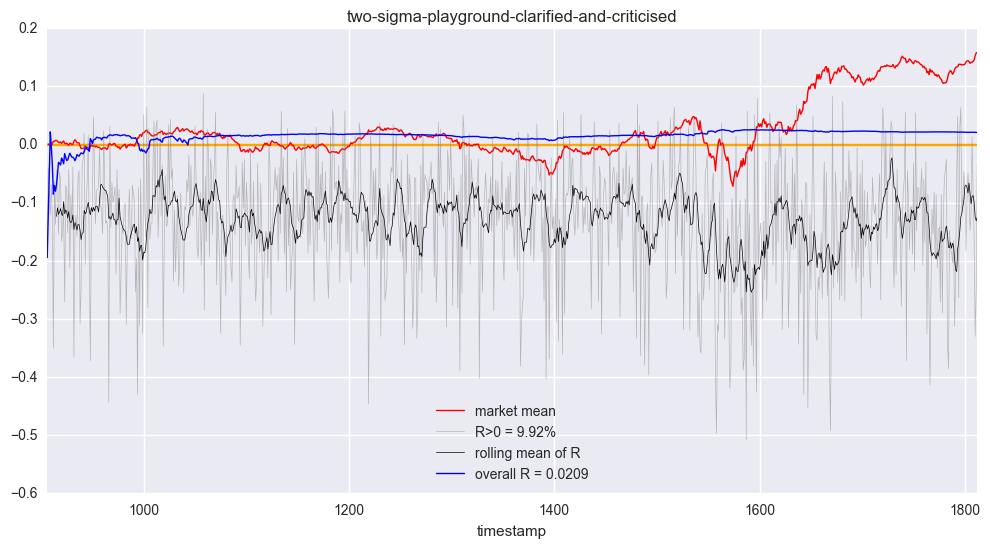

In [23]:
p11.plot()

## Simple autoregression
- https://www.kaggle.com/den3b81/two-sigma-financial-modeling/simple-autoregressive-pub-score-0-025-submit-fail/run/969833/code

In [29]:
import kagglegym
import numpy as np
import pandas as pd

# Additional includes
from sklearn import linear_model


################################################
# Initialize environment 
#
# The "environment" is our interface for code competitions
env = kagglegym.make()
# We get our initial observation by calling "reset"
observation = env.reset()

################################################
# Compute features
df = observation.train[['timestamp','id','y','technical_20','technical_30']].sort_values(by = ['id','timestamp'])
df['feat2030'] = df['technical_20']-df['technical_30'] # feature2030
df['y_hat1'] = (df['feat2030'] - (0.92 * df['feat2030'].shift(1))) / 0.07 # cc05 reconstructed past y

# Add lagged predictors
max_lag = 2
for lag in np.arange(2,max_lag+1):
    df['y_hat{}'.format(lag)] = df['y_hat1'].shift(lag-1)

all_feats = ['y_hat{}'.format(max_lag-lag) for lag in range(max_lag)]
print(all_feats)
# Handle NAN
fillnawith = df.mean(axis=0)
df.fillna(fillnawith, inplace = True)
df.fillna(0, inplace=True)

################################################
# Model training
print('Training!')
model = linear_model.RidgeCV(alphas=(0.1, 1.0, 10.0,100,1000,10000))
model = model.fit(df[all_feats], df.y)


################################################
# Prepare for predictions
temp = df[df['timestamp'] > df['timestamp'].max()-max_lag]
feat2030 = temp.pivot(index = 'id', columns = 'timestamp', values = 'feat2030') # past values of feat
y_hat = temp.pivot(index = 'id', columns = 'timestamp', values = 'y_hat1') # past values of y

print('Predicting!')

p12 = Performance('Simple Auto-regression')
while True:
    # get features
    test  = observation.features[['timestamp','id','technical_20','technical_30']].set_index('id')
    # get timestamp
    t = test["timestamp"][0]
    
    # compute autoregressive features and expand datasets (for new ids)
    feat2030 = pd.concat([feat2030,test['technical_20']-test['technical_30']], axis = 1, join = 'outer')
    feat2030.rename(columns={0: t}, inplace = True)
    y_hat = pd.concat([y_hat,(feat2030[t] - (0.92 * feat2030[t-1]))/ 0.07], axis = 1, join = 'outer')
    y_hat.rename(columns={0: t}, inplace = True)

    
    # create test features dataset
    Xtest = pd.concat([test,y_hat.loc[:,(t-max_lag+1):t]],axis = 1, join = 'inner').iloc[:,-max_lag:]
    Xtest = pd.DataFrame(index = Xtest.index, data = Xtest.values, columns = all_feats) 
    # handle NANs
    Xtest.fillna(fillnawith, inplace = True)
    Xtest.fillna(0, inplace=True) 
    
    # predict!
    # preds = observation.target.reset_index().set_index('id')
    preds = observation.target
    preds['y'] = model.predict(Xtest)
    

    # We perform a "step" by making our prediction and getting back an updated "observation":
    #print(preds.reset_index().set_index('index').head())
    #print(preds.reset_index().set_index('index').rename_axis(None).head())
    #observation, reward, done, info = env.step(preds.reset_index().set_index('index').rename_axis(None))
    observation, reward, done, info = env.step(preds)
    p12.update(t, preds.y)
    if t % 100 == 0:
        print(t,reward)

    if done:
        print("Public score: {}".format(info["public_score"]))
        break

['y_hat2', 'y_hat1']
Training!
Predicting!
1000 0.0711834319242
1100 -0.055111415616
1200 -0.0740418360811
1300 -0.0811796052363
1400 -0.181530021838
1500 -0.20492384429
1600 -0.176793382271
1700 0.0536337094689
1800 -0.0845011460054
Public score: 0.024814051872811407


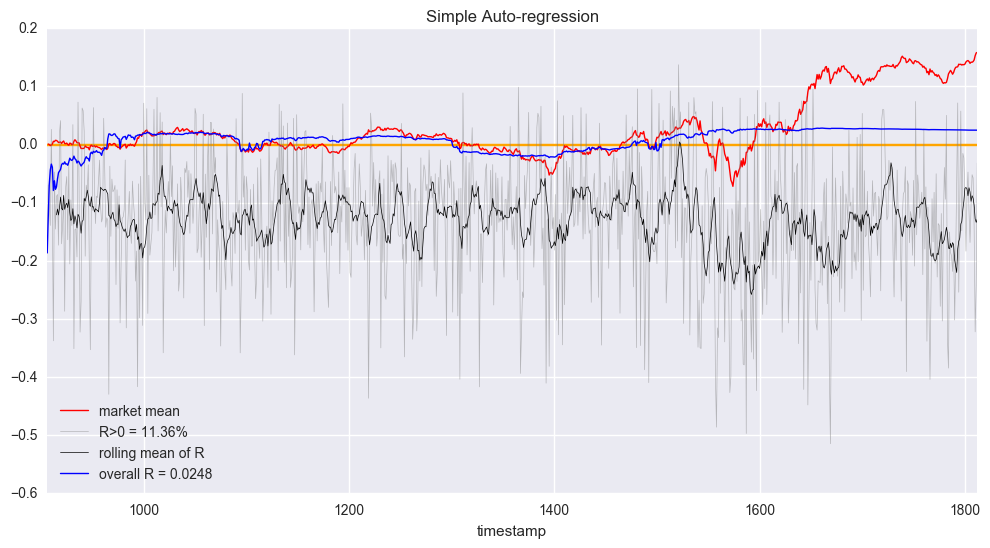

In [ ]:
p12.plot()

## Online Learning
- https://www.kaggle.com/ocolegro/two-sigma-financial-modeling/online-learning-027-offline-result/code

In [10]:
# import kagglegym
# import numpy as np
# import pandas as pd

from sklearn import linear_model as lm
from sklearn.metrics import r2_score
pd.set_option('chained_assignment',None)

low_y_cut   = -0.086093
high_y_cut  =  0.093497

env             = kagglegym.make()
observation     = env.reset()
train           = observation.train
y_is_above_cut  = (train.y > high_y_cut)
y_is_below_cut  = (train.y < low_y_cut)
y_is_within_cut = (~y_is_above_cut & ~y_is_below_cut)
train           = train.loc[y_is_within_cut,:]
train           = train[["id", "y", "timestamp","technical_20","technical_13","technical_30"]]

train["technical_20_shifted"]     = train.groupby('id')["technical_20"].shift(1)
train["technical_13_shifted"]     = train.groupby('id')["technical_13"].shift(1)
train["technical_30_shifted"]     = train.groupby('id')["technical_30"].shift(1)
train["y_shifted"]                = train.groupby('id')["y"].shift(1)
train['derived_feat']             = ( (train["technical_20"] + train["technical_13"] - train["technical_30"])  \
                                    -0.9327 * (train["technical_20_shifted"] + train["technical_13_shifted"] - train["technical_30_shifted"]) \
                                    )/(1 - 0.9327)

for col in train.columns:
    train.loc[(np.isfinite(train[col]) == 0),:] = 0

fit_lr_bound    = np.min(train['timestamp']) + 50
model           = lm.LinearRegression()

train_fit       = train[train['timestamp']<fit_lr_bound]


model.fit(train_fit['derived_feat'].values.reshape(len(train_fit),1),train_fit['y'])

coefs = [.075,1.]

def r_score(y_true, y_pred, sample_weight=None, multioutput=None):
    r2 = r2_score(y_true, y_pred, sample_weight=sample_weight,
                  multioutput=multioutput)
    r = (np.sign(r2)*np.sqrt(np.abs(r2)))
    return r

def fit_derived_coeffs(reward,preds,a1,a2,b1,b2):
    fit_alpha,fit_beta = 1e6,1e6
    residual  = 1e6
    for beta in [-1.,0,1.]:
        t1 = a1 + beta*b1
        t2 = a2 + beta*b2
        for alpha in np.linspace(0.01,.25,25):
                y = ((t1  - (1 - alpha) *t2)/alpha)
                r_score_fit = r_score(y,preds)
                temp_residual = np.abs(r_score_fit - reward)/np.abs(reward)
                if (temp_residual < residual ):
                    residual = temp_residual
                    fit_alpha = alpha
                    fit_beta = beta
    return ([fit_alpha,fit_beta],residual)

def update_derived_coeffs(coefs,fits_residual,lr = .125):
    fits     = fits_residual [0]
    residual = fits_residual[1]
    coefs[0] = coefs[0] + lr*(fits[0] - coefs[0]) * max(1 - residual,0)
    coefs[1] = coefs[1] + lr*(fits[1] - coefs[1]) * max(1 - residual,0)
    return coefs,residual

def update_lr_coeff(residual,actions,yhat_reco,var_to_update,coeff,lr = .125):
    dphi    =  (lr * np.mean( (yhat_reco - actions)*var_to_update)) * max((1 - residual),0)
    return coeff + dphi

def convert(actions,ids):
    d_ = {}
    for id,ele in enumerate(ids):
        d_[ele[0]] = actions[id]

    y_ = []
    for ele in observation.target.id:
        try:
            val = d_[ele]
            y_.append(val)
        except:
            y_.append(0)
    return y_

newList = list(set(train['timestamp'])) 
for i in newList[51:len(newList)-2]:
# for i in range(fit_lr_bound+1,np.max(train['timestamp'].unique())-2):
    subset = train[train['timestamp']== i]
    subset_future = train[train['timestamp'] == i+1]
    subset['derived_feat_better'] = ( (subset["technical_20"] + coefs[1]*subset["technical_13"] - subset["technical_30"])  \
                                    - (1 - coefs[0]) * (subset["technical_20_shifted"] + coefs[1]*subset["technical_13_shifted"] - subset["technical_30_shifted"]))/coefs[0]
    actions = model.predict(subset['derived_feat_better'].values.reshape(len(subset),1)).clip(low_y_cut,high_y_cut)
    reward  = r_score(subset['y'], actions)
    coefs,residual = update_derived_coeffs(coefs, fit_derived_coeffs(reward,actions,
                                (subset["technical_20"] - subset["technical_30"]).values,
                                (subset["technical_20_shifted"] - subset["technical_30_shifted"]).values,
                                subset["technical_13"].values,subset["technical_13_shifted"].values))
    subset_future['derived_feat_better'] = ( (subset_future["technical_20"] + coefs[1]*subset_future["technical_13"]- subset_future["technical_30"])  \
                                    - (1 - coefs[0]) * (subset_future["technical_20_shifted"] + coefs[1]*subset_future["technical_13_shifted"] - subset_future["technical_30_shifted"]))/coefs[0]
    subset['actions'] = actions

    subset_future = subset_future.merge(subset,on='id',suffixes=('','_shifted_2'))

    for col in ['actions','derived_feat_better']:
        subset_future   = subset_future.loc[np.isfinite(subset_future[col]),:]
    model.coef_[0] = update_lr_coeff(reward,subset_future['actions'],subset_future['derived_feat_better'],subset_future['derived_feat_better_shifted_2'],model.coef_[0])

print("Model Trained.")

reward,residual = 1e6,1e6
done = False
actions,prev_feats,prev_feats_derived_feat = [],[],[]

p14 = Performance('Online Learning')
while True:
    if done:
        break

    features      = observation.features
    features      = features[["id", "timestamp","technical_20","technical_30","technical_13"]]
    features_copy = features.copy()

    for col in features.columns:
        features.loc[(np.isfinite(features[col]) == 0),:] = 0

    if (len(prev_feats) == 0):
        prev_feats              = features_copy
        prev_feats["preds"]     = np.zeros(len(prev_feats))
        observation.target.y    = np.zeros(len(observation.target.id))
        target                  = observation.target
        observation, reward, done, info \
                                = env.step(target)
        continue


    features = features.merge(prev_feats[["id", "timestamp","technical_20","technical_30","technical_13","preds"]],on='id',suffixes=('','_shifted'))
    features = features.dropna()

    if (reward != 1e6):
        coefs,residual = update_derived_coeffs(coefs, fit_derived_coeffs(reward,features['preds'],
                            (features["technical_20"] - features["technical_30"]).values,
                            (features["technical_20_shifted"] - features["technical_30_shifted"]).values,
                            features["technical_13"].values,features["technical_13_shifted"].values))
    features['derived_feat'] \
             = ( (features["technical_20"] + coefs[1]*features["technical_13"] - features["technical_30"])  \
                - (1-coefs[0]) * (features["technical_20_shifted"] + coefs[1]*features["technical_13_shifted"]  - features["technical_30_shifted"]))/coefs[0]
    derived_features_copy = features.copy()

    if (len(features) > 0  ):
        actions = model.predict(features['derived_feat'].values.reshape(len(features),1)).clip(low_y_cut,high_y_cut)
        observation.target.y = convert(actions,features[['id']].as_matrix())

        if (reward != 1e6 and len(actions) != 0 and residual != 1e6):
            if (len(prev_feats_derived_feat) != 0):
                features = features.merge(prev_feats_derived_feat[['id','derived_feat']],on='id',suffixes=('','_shifted'))
                features.dropna()
                model.coef_[0] = update_lr_coeff(residual,features['preds'],features['derived_feat'],features['derived_feat_shifted'],model.coef_[0])


    else:
        prev_feats              = features_copy
        prev_feats["preds"]     = np.zeros(len(prev_feats))
        prev_feats_derived_feat = prev_feats.merge(derived_features_copy,on='id',suffixes=('','_shifted'))
        observation.target.y    = np.zeros(len(observation.target.id))
        target                  = observation.target
        observation, reward, done, info\
                                = env.step(target)
        continue

    if len(observation.features < 0):
        timestamp = observation.features["timestamp"][0]
        if timestamp % 100 == 0:
            print(timestamp,reward)

    prev_feats                      = features_copy
    prev_feats['preds']             = observation.target.y
    prev_feats_derived_feat         = prev_feats.merge(derived_features_copy,on='id',suffixes=('','_shifted'))

    p14.update(timestamp, prev_feats.preds.values)
    observation, reward, done, info = env.step(observation.target)
    
print(info)

Model Trained.
1000 -0.319276898474
1100 -0.177023162207
1200 -0.183735496108
1300 0.0335788680744
1400 -0.127308325492
1500 -0.189481909245
1600 -0.210803761121
1700 -0.286390672741
1800 -0.0252790596664
{'public_score': 0.027379409149408378}


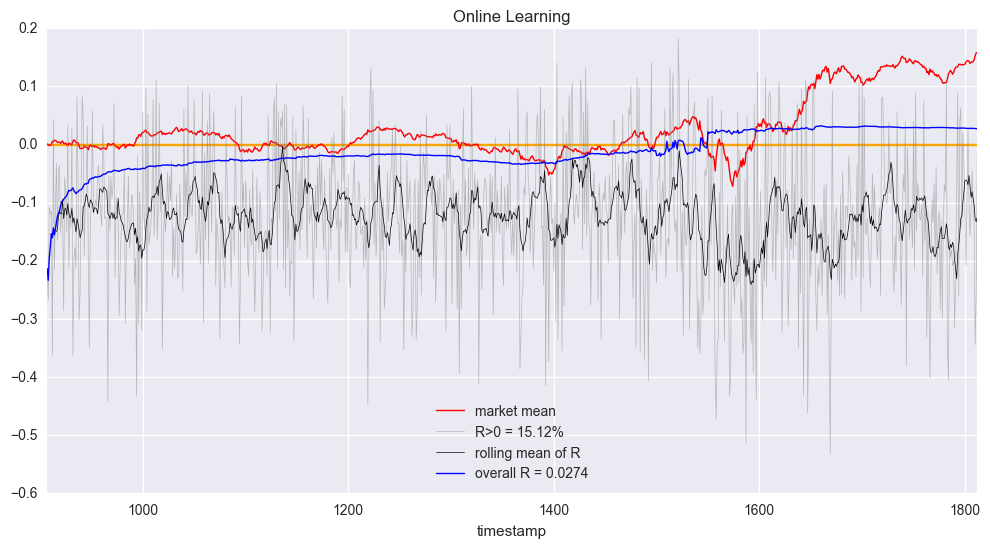

In [11]:
p14.plot()

## sdfoley two-sigma-03 (account and code since deleted)
- https://www.kaggle.com/sdfoley/two-sigma-financial-modeling/two-sigma-03/code
- Public Score 0.0180552

In [46]:
from collections import deque
from sklearn.linear_model import Ridge
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import MinMaxScaler
import kagglegym
import numpy as np
import pandas as pd
import random

random.seed(a=52)

# ------------------------------------------------------------------------------

def split_df(df):

    orig = df

    df = df.groupby(['timestamp'])

    t20_std = df[['technical_20']].std()
    t30_std = df[['technical_30']].std()

    x = (t20_std.values + t30_std.values) / 2

    df = pd.DataFrame({'vol': x.ravel()}, index=t20_std.index)
    df.vol = df.rolling(window=3, win_type='triang').mean()

    vol_33 = np.nanpercentile(df.vol, 33)
    vol_66 = np.nanpercentile(df.vol, 66)

    A = df[(df.vol < vol_33)]
    B = df[(df.vol > vol_33) & (df.vol <= vol_66)]
    C = df[(df.vol >= vol_66)]

    A = orig.loc[orig['timestamp'].isin(A.index)]
    B = orig.loc[orig['timestamp'].isin(B.index)]
    C = orig.loc[orig['timestamp'].isin(C.index)]

    return [A, B, C], [vol_33, vol_66]

# ------------------------------------------------------------------------------

class Model:

    def __init__(self, df, mode):

        self.cols = ['technical_20', 'technical_30']
        self.scale = MinMaxScaler()
        y = np.array(df.y)

        if mode == 'A':
            self.regr = SGDRegressor(
                loss = 'epsilon_insensitive',
                fit_intercept = False,
                random_state = 52
            )
        elif mode == 'B':
            self.regr = SGDRegressor(
                loss = 'huber',
                fit_intercept = False,
                random_state = 52
            )
        else:
            self.regr = Ridge(
                alpha = 200,
                random_state = 52
            )

        df = df[self.cols]
        self.means = df.mean()
        df = df.fillna(self.means)
        x = np.array(df)
        x = self.scale.fit_transform(x)

        self.regr.fit(x, y)

    # ------------------------------

    def predict(self, df):
        df = df[self.cols]
        df = df.fillna(self.means)
        x = np.array(df)
        x = self.scale.transform(x)
        return self.regr.predict(x)

# ------------------------------------------------------------------------------

class Crystalball:

    def __init__(self, df):

        self.mode = 'B'
        self.vol = deque([0], 3)
        self.y_mean = df.y.mean()

        df_list, vol_list = split_df(df)
        df1, df2, df3 = df_list
        self.vol_33, self.vol_66 = vol_list

        self.model_A = Model(df1, 'A')
        self.model_B = Model(df2, 'B')
        self.model_C = Model(df3, 'C')

    # ------------------------------

    def get_state(self, df):

        vol = (df.technical_20.std() + df.technical_30.std()) / 2

        self.vol.append(vol)

        vol = sum(self.vol) / len(self.vol)

        if vol < self.vol_33:
            self.mode = 'A'
        elif vol > self.vol_33 and vol <= self.vol_66:
            self.mode = 'B'
        else:
            self.mode = 'C'

    # ------------------------------

    def predict(self, df):

        self.get_state(df)

        if self.mode == 'A':
            x = self.model_A.predict(df)
        elif self.mode == 'B':
            x = self.model_B.predict(df)
        else:
            x = self.model_C.predict(df)

        return x

# ------------------------------------------------------------------------------

env = kagglegym.make()
observation = env.reset()
crystalball = Crystalball(observation.train)

p15 = Performance('two-sigma-03 by sdfoley')
while True:

    features = observation.features
    target = observation.target

    target.y = crystalball.predict(features)
    p15.update(features.timestamp[0],target.y)
    observation, reward, done, info = env.step(target)

    if done:
        break

print(info)

{'public_score': 0.026839613259479755}


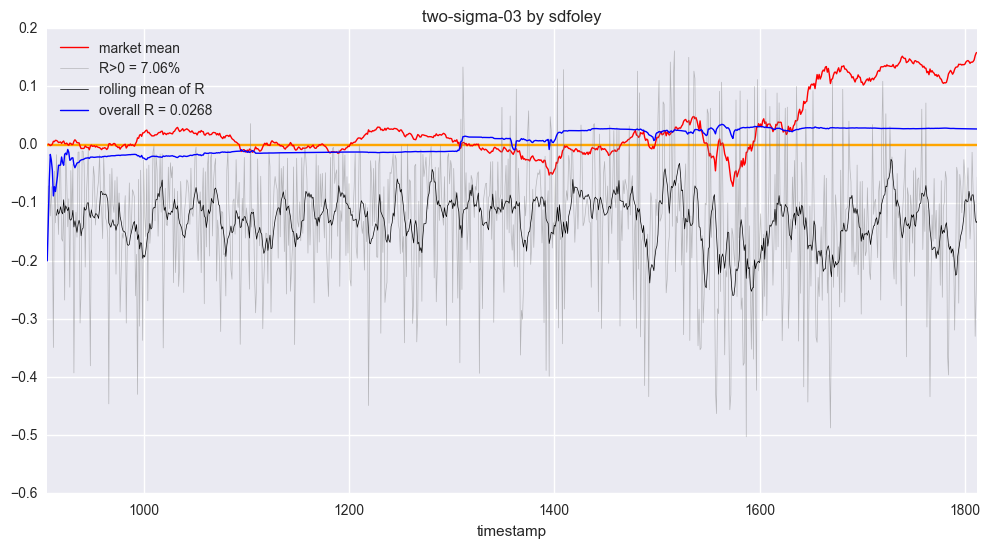

In [47]:
p15.plot()

## two-sigma-03 (shorter version) by happycube
- forked from two-sigma-03 by sdfoley 
- https://www.kaggle.com/happycube/two-sigma-financial-modeling/two-sigma-03-shorter-version
- Private Score 0.0199284  Public Score 0.0180552

In [48]:
from collections import deque
from sklearn.linear_model import Ridge
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import MinMaxScaler
import kagglegym
import numpy as np
import pandas as pd
import random
import math

random.seed(a=52)

class Model:

    def __init__(self, df, model):

        self.cols = ['technical_20', 'technical_30']
        self.scale = MinMaxScaler()
        
        self.regr = model

        df_cols = df[self.cols]
        self.means = df_cols.mean()
        
        df_cols = df_cols.fillna(self.means)
        x = self.scale.fit_transform(df_cols.values)

        self.regr.fit(x, df.y.values)

    # ------------------------------

    def predict(self, df):
        df_cut = df[self.cols].fillna(self.means)
        
        x = self.scale.transform(df_cut.values)
        
        return self.regr.predict(x)

env = kagglegym.make()
observation = env.reset()

train = observation.train

# build dataframe with volatility for each day

df = train[['timestamp', 'y', 'technical_20', 'technical_30']].copy()

grouped = df.groupby('timestamp')

stdgroup = grouped[['technical_20', 'technical_30']].std()
stdgroup_mean = stdgroup.rolling(window=3, win_type='triang').mean().mean(axis=1)

df_vol = pd.DataFrame({'vol': stdgroup_mean}, index=stdgroup.index)

regressors = [(SGDRegressor(loss = 'epsilon_insensitive', fit_intercept = False, random_state = 52), [-math.inf, 33]),
              (SGDRegressor(loss = 'huber', fit_intercept = False, random_state = 52), [33, 66]),
              (Ridge(alpha = 200, random_state = 52), [66, math.inf])]

models = []

for reg, rawlimits in regressors:
    limits = [0, 0]
    limits[0] = np.nanpercentile(df_vol.vol, rawlimits[0]) if not (np.isinf(rawlimits[0])) else rawlimits[0]
    limits[1] = np.nanpercentile(df_vol.vol, rawlimits[1]) if not (np.isinf(rawlimits[1])) else rawlimits[1]
    
    subset = (df_vol.vol > limits[0]) & (df_vol.vol <= limits[1])

    df_subset = train.loc[train.timestamp.isin(df_vol[subset].index)]
    
    models.append((Model(df_subset, reg), limits.copy()))

vol = deque([0, 0, 0], 3)

p16 = Performance('two-sigma-03 (shorter version) by happycube')
while True:
    df = observation.features
    target = observation.target
    
    vol.append((df.technical_20.std() + df.technical_30.std()) / 2)
    curvol = sum(vol) / len(vol)
    
    for model, bounds in models:
        if curvol > bounds[0] and curvol <= bounds[1]:
            target.y = model.predict(df)
            break
    
    p16.update(df.timestamp[0],target.y)
    observation, reward, done, info = env.step(target)
    
    if done:
        break

print(info)

{'public_score': 0.026839613259479755}


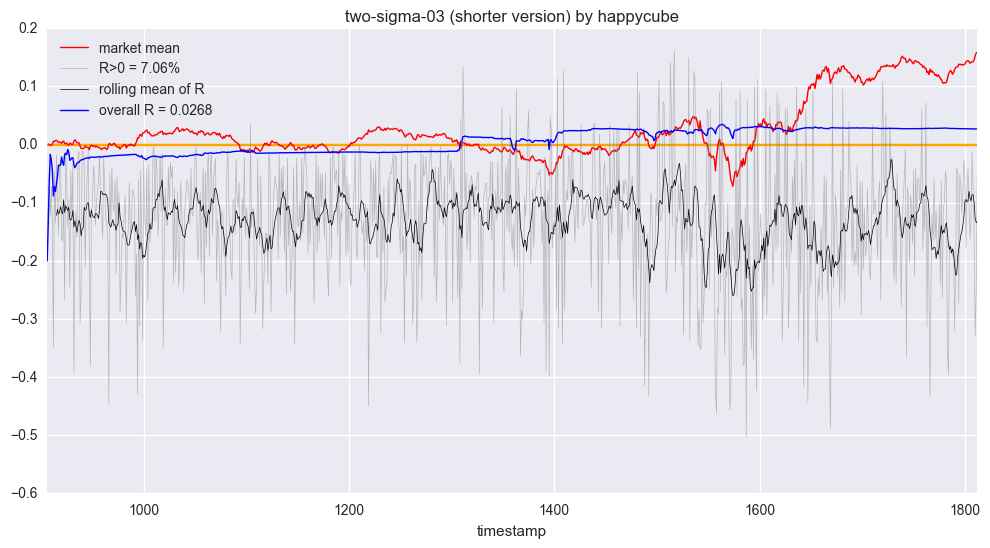

In [49]:
p16.plot()

## Policy Gradient
- https://www.kaggle.com/pravinbs/two-sigma-financial-modeling/policy-gradient

In [8]:
import kagglegym
import numpy as np
import pandas as pd
import tensorflow as tf
import tflearn
from sklearn.metrics import r2_score

class PolicyGradientREINFORCE(object):

    def __init__(self, session,
                     optimizer,
                     policy_network,
                     state_dim,
                     num_actions):
                         
        # tensorflow machinery
        self.session        = session
        self.optimizer      = optimizer

        # model components
        self.policy_network = policy_network

        # training parameters
        self.state_dim       = state_dim
        self.num_actions     = num_actions
        self.train_iteration = 1

        # rollout buffer
        self.state_buffer  = []
        self.reward_buffer = []
        self.action_buffer = []
        self.actual_buffer = []

        self.prev_reward = 0

        # create and initialize variables
        self.create_variables()
        var_lists = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
        self.session.run(tf.variables_initializer(var_lists))

        # make sure all variables are initialized
        self.session.run(tf.assert_variables_initialized())


    def resetModel(self):
        self.cleanUp()
        self.train_iteration = 0
        var_lists = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
        self.session.run(tf.variables_initializer(var_lists))

    def create_variables(self):
        self.inputs, self.policy_outputs = self.policy_network()
        self.discounted_rewards = tf.placeholder(tf.float32, (None,), name="discounted_rewards")
        self.gradients = tf.gradients(self.policy_outputs, tf.trainable_variables())

        for i, (grad, var) in enumerate(zip(self.gradients, tf.trainable_variables())):
            if grad is not None:
                self.gradients[i] = (-tf.sign(self.discounted_rewards) * grad * 1e-2, var)

        self.eval_op = self.optimizer.apply_gradients(self.gradients)
        self.no_op = tf.no_op()
    
    def sampleAction(self, states, explore):
        action_scores = self.session.run(self.policy_outputs, feed_dict={self.inputs: states})
        return action_scores

    def updateModel(self):
        states  = self.state_buffer
        rewards = self.reward_buffer
        self.train_iteration += 1
        self.session.run([
        self.eval_op,
        self.no_op
        ], {
        self.inputs:             states,
        self.discounted_rewards: rewards
        })

        self.cleanUp()

    def storeRollout(self, state, reward):
        self.reward_buffer = np.asarray([reward])
        self.state_buffer = state

    def cleanUp(self):
        pass

    
def r_score(y_true, y_pred, sample_weight=None, multioutput=None):
    r2 = r2_score(y_true, y_pred, sample_weight=sample_weight,
                  multioutput=multioutput)
    r = (np.sign(r2)*np.sqrt(np.abs(r2)))
    return r

def predict(feature, explore):
    return pg_reinforce.sampleAction(feature, explore)


env = kagglegym.make()
RANDOM_SEED=1234
np.random.seed(RANDOM_SEED)
tf.set_random_seed(RANDOM_SEED)

observation = env.reset()            
train = observation.train
train.fillna(0, inplace=True)
ts = train.timestamp.unique()
        
cols = []

for col in train.columns:
    if 'derive' in col:
        cols.append(col)
        
numfeat = len(cols)
sess = tf.Session()
optimizer = tflearn.SGD(learning_rate=1e-2).get_tensor() 


state_dim   = numfeat
num_actions = 1
seed = 1234

def policy_network():
    inputs = tflearn.input_data(shape=[None, state_dim])
    net = tflearn.fully_connected(inputs, 200)
    t1 = tflearn.fully_connected(net, 200)
    net = tflearn.activation(tf.matmul(net,t1.W) + t1.b, activation='relu')
    out = tflearn.fully_connected(net, 1, activation='tanh')
    out = tf.multiply(out, 0.08)
    return inputs, out

pg_reinforce = PolicyGradientREINFORCE(sess,
                                       optimizer,
                                       policy_network,
                                       state_dim,
                                       num_actions)

print('started')
prev = 0


for z in range(0, 25):
    for i in range(0, len(ts)):
        subset = train[train.timestamp == ts[i]]
        features = subset[cols].values
        y = subset.y
        actions = predict(features, True)
        reward = r_score(y, actions)
        # print(reward)
        pg_reinforce.storeRollout(features, reward - prev)
        prev = reward
        pg_reinforce.updateModel()

print('trained')

Instructions for updating:
Use `tf.variables_initializer` instead.
started
trained


In [15]:
env = kagglegym.make()
RANDOM_SEED=1234
np.random.seed(RANDOM_SEED)
tf.set_random_seed(RANDOM_SEED)

observation = env.reset()            

p17 = Performance('policy gradient')
while True:
    features = observation.features
    features.fillna(0, inplace=True)
    features = features[cols].values
    actions = predict(features, True)
    observation.target.y = actions

    timestamp = observation.features["timestamp"][4]
    if timestamp % 100 == 0:
        print("Timestamp #{}".format(timestamp))

    observation, reward, done, info = env.step(observation.target)
    p17.update(timestamp, actions, reward)
#    print(reward)
    if done:
        break
    pg_reinforce.storeRollout(features, reward - prev)
    prev = reward
    pg_reinforce.updateModel()

print(info)

Timestamp #1000
Timestamp #1100
Timestamp #1200
Timestamp #1300
Timestamp #1400
Timestamp #1500
Timestamp #1600
Timestamp #1700
Timestamp #1800
{'public_score': -0.46318956743614992}


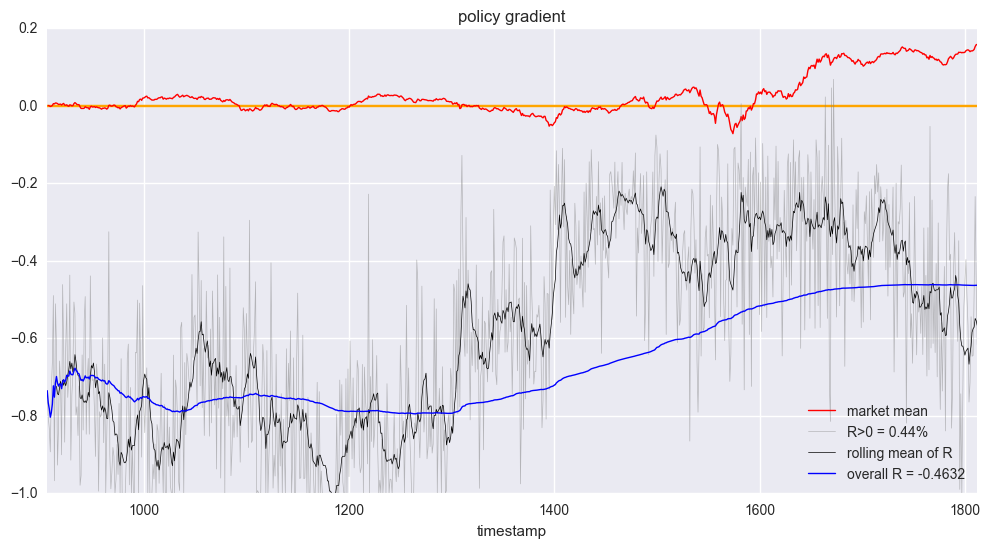

In [16]:
p17.plot()

## Team Rocket #13
- https://www.kaggle.com/titericz/two-sigma-financial-modeling/team-rocket-13/code
- the one change is that this model trains the XGB model rather than taking the pickled version, and therefore trains on only half of the train set (the pickled one was trained on the full set).

In [12]:
## !/usr/bin/env python3
# -*- coding: utf-8 -*-
### version 1.0
### Team Rocket v1

import kagglegym
import numpy as np
import pandas as pd
from datetime import datetime
pd.options.mode.chained_assignment = None

## helper functions

def clip_fundamentals(df_2_clean):
    # large value outliers
    outlierFs_num = {2:2.5, 3:2.5, 5:2.5, 6:1.2, 7:2.5, 8:1.2, 9:2.5, 10:1.2, 
                 11:2.5,12:1.2,13:1.2, 14:2.5, 15:2.5,17:1.2, 18:2.5, 
                 19:2.5, 20:2.0, 21:2.5,22:1.2,23:1.2, 24:2.5, 25:2.0,
                 26:2.5, 27:2.5, 28:3.5, 29:2.5, 30:2.5, 31:2.5, 32:1.2,
                 33:2.5, 34:0.9, 35:2.5, 36:2.5, 37:2.5, 38:2.5, 39:1.2,
                 40:1.0, 41:2.5, 42:2.5, 43:2.5, 44:3.0, 45:2.5, 46:2.5,
                 47:2.0, 48:4.0, 49:1.2, 50:2.5, 51:0.75,52:2.5, 53:2.5,
                 54:4.0, 55:2.5, 56:2.5, 57:2.5, 58:2.5, 59:2.0, 60:5.0,
                 61:1.0, 62:1.5, 63:2.5 }

    outlierFs = {'fundamental_'+str(k): v for k, v in outlierFs_num.items()}
    cleaned_df = df_2_clean.copy()
    for k,th in outlierFs.items():
        #cleaned_df.loc[np.abs(cleaned_df[k])>th, k] = np.NaN
        cleaned_df[k] = cleaned_df[k].clip(-th, th)
    return cleaned_df

def getCleanedDataFrame(df_all):
    #%% Load Data
    #with pd.HDFStore("../data/train.h5", "r") as train:
    #    df_all = train.get("train")
    
    #%% clean data 2. Half of the fundamentals are pruned here.. 
    
    df_all=clip_fundamentals(df_all)
    
    #%% specially engineered features
    
    df_all['CntNs'] = df_all.isnull().sum(axis=1) / (df_all.shape[1] - 3.0)
    
    df_all['g1']    = df_all['technical_19'] + df_all['technical_27'] \
                      + df_all['technical_35'] - df_all['technical_36']
    df_all['g2']    = df_all['technical_2'] + 0.5*df_all['technical_11'] \
                      + df_all['technical_43'] + 2.5
    
    df_all[['p2t11','p2t13']] = df_all[['id','technical_11','technical_13'] 
                               ].groupby('id').shift(periods=2)
    df_all[['p3t11','p3t13']] = df_all[['id','technical_11','technical_13'] 
                               ].groupby('id').shift(periods=3)
    
    df_all['technical_2030'] = df_all['technical_20'] - df_all['technical_30']
    df_all['grp'] = (np.abs(df_all.technical_2030)<1e-6)+2*(df_all.CntNs>0.3)
    
    #%% rolling and diffs
    print('about to roll fundamentals')
    
    ## lagged return
    t2roll_Cols = ['technical_'+str(x) for x in [2030, 20,30,40] ]
    for col in t2roll_Cols:
        #print('processing', col)
        d1col = col.replace('technical_','dt')
        d5col = col.replace('technical_','d5t')
        grped = df_all[['id', col]].groupby('id')
        df_all[d1col] = df_all[col] - 0.92 * grped[col].shift(periods=1)
        df_all[d1col] /= 0.08
        df_all[d5col] = df_all[col] - grped[col].shift(periods=5)

    # and shift back dt2030 for more lags.    
    df_all['d1t2030']= df_all[['id','dt2030']].groupby('id')['dt2030'].shift(1)
    df_all['d2t2030']= df_all[['id','dt2030']].groupby('id')['dt2030'].shift(2)
    df_all['d3t2030']= df_all[['id','dt2030']].groupby('id')['dt2030'].shift(3)
    #df_all['proxy_y']= df_all[['id','dt2030']].groupby('id')['dt2030'].shift(-1)
    # notice df_all['d5t2030'] has a different meaning
    
    # rolling proxy_y
    tmp = df_all[['id', 'dt2030']].groupby('id')['dt2030']
    df_all['w05ry'] = tmp.rolling( 5, 1).mean().reset_index(0, drop=True)
    df_all['w10ry'] = tmp.rolling(10, 1).mean().reset_index(0, drop=True)
    df_all['w20ry'] = tmp.rolling(20, 1).mean().reset_index(0, drop=True)
    
    ### relative to mkt
    mdt2030 = df_all.loc[np.abs(df_all.dt2030)>1e-6, 
        ['timestamp', 'dt2030']].groupby('timestamp')['dt2030'].mean()
    df_all['mdt2030'] = mdt2030[df_all['timestamp']].values
    df_all['ly0'] = df_all['dt2030'] - df_all['mdt2030']    
    df_all['ly1'] = df_all[['id','ly0']].groupby('id')['ly0'].shift(1)
    df_all['ly2'] = df_all[['id','ly0']].groupby('id')['ly0'].shift(2)
    cum5 = df_all[['id','ly0']].groupby('id')['ly0'].rolling(5, 1).sum()
    df_all['cy5'] = 0.2 * cum5.reset_index(drop=True, level=0)
    
    
    f2roll_Cols = ['fundamental_'+str(x) for x in 
                   [29,44,45,20,54,30,57,0,59,12,39,8,36,48,53,60,7,2,56,55]]
    for col in f2roll_Cols:
        #print('processing', col)
        d1col = col.replace('fundamental_', 'df')
        d5col = col.replace('fundamental_', 'd5f')
        grped = df_all[['id', col]].groupby('id')
        df_all[d1col] = df_all[col] - grped[col].shift(periods=1)
        df_all[d5col] = df_all[col] - grped[col].shift(periods=5)
        
    #flds_4_ret=['fundamental_11','fundamental_15','fundamental_18',
    #            'fundamental_29','fundamental_55','fundamental_60',
    #            'fundamental_62','technical_10','technical_14','technical_27']
    flds_4_ret=['fundamental_29']
    for col in flds_4_ret:
        mcol = col.replace('fundamental_', 'mf').replace('technical_', 'mt')
        tmp = df_all[['timestamp', col]].groupby('timestamp')[col].mean()
        df_all[mcol] = tmp[df_all['timestamp']].values
        
    #%% vol term
    v0 = df_all[['timestamp', 'dt2030']].groupby('timestamp')['dt2030'].std()
    v0 = v0 * np.sqrt(255.)
    v0 = v0.clip(0.1, 0.7).rolling(window=2, min_periods=1).mean()
    v0[0] = 0.3 # first ts specical
    df_all['v0'] = v0[df_all['timestamp']].values
    
    return df_all

def xgb_eval_custom_r(y_pred, dtrain):
    y_true = dtrain.get_label()
    ybar = np.sum(y_true)/len(y_true)
    ssres = np.sum((y_true - y_pred) ** 2)
    sstot = np.sum((y_true - ybar)**2)
    r2 = 1 - ssres/sstot
    error = np.sign(r2) * np.absolute(r2)**0.5
    return 'error', error

def xgb_obj_custom_r(y_pred, dtrain):
    y_true = dtrain.get_label()
    y_mean = np.mean(y_true)
    y_median = np.median(y_true)
    c1 = y_true
    #c1 = y_true - y_mean
    #c1 = y_true - y_median
    grad = 2*(y_pred-y_true)/(c1**2)
    hess = 2/(c1**2)
    return grad, hess

def pred_mkt_y_ts(dataf):
    flds=['fundamental_62', 'd5f53']
    X = dataf[['timestamp']+flds].groupby('timestamp').mean()
    theta = np.array([- 0.00241181, - 0.00543807])
    return X.dot(theta.T) + 7.5e-5

def pred_mkt_y(dataf):
    yh_ts = pred_mkt_y_ts(dataf)
    yh = yh_ts[dataf['timestamp']].values
    return yh

#%% ---------------------------------------------------------------------------
#             end of helper functions 
### ---------------------------------------------------------------------------
# The "environment" is our interface for code competitions
env = kagglegym.make()
d = env.reset()
df = d.train

t0 = datetime.now()
print(t0.strftime('%Y-%m-%d %H:%M:%S') + ' env reseted.')

#%% clean data 1. IDs with large alphas because of short presence.
idx_bad_beta = df['id'].isin([93,807,1431,1637,1778,1118,1893,1089,882,1229])
df = df.loc[ ~ idx_bad_beta ]
 
df = getCleanedDataFrame(df)

#%% fill median for all columns.
COLs = [c for c in df.columns if c not in ['id', 'timestamp', 'y']]
COLs_mean = df[COLs].dropna().median()
print(COLs_mean.head())
mean_train_vol = np.mean(df['v0'])
print("mean_train_vol = {:6.4f}".format(mean_train_vol))

df = df.fillna(COLs_mean)
print("df cleaned.")

# Note that the first observation we get has a "train" dataframe
print("Train data shape", df.shape)
# The "target" dataframe is a template for what we need to predict:
print("Target column names: {}".format(
        ", ".join(['"{}"'.format(col) for col in list(d.target.columns)])))

#%% features for models
techCols = [x for x in df.columns if 'tech' in x if x!='technical_44']
fundCols = [x for x in df.columns if 'fund' in x]
deriCols = [x for x in df.columns if 'deri' in x]

techColsx30 = [x for x in techCols if x != 'technical_30']

#rdg_Cols = ['dt20','technical_20','technical_30','technical_13','p2t13']
rdg_Cols = ['d5t2030', 'dt20', 'd1t2030', 'p2t13']           
dCols = ['dt20', 'dt30']


#etr_Cols = techColsx30 + fundCols + deriCols + dCols +['v0', 'CntNs']
etr_Cols = techCols + fundCols + deriCols + dCols +['CntNs']

etr_Cols = [ 'd5t2030', 'mf29','mdt2030', 'technical_30', 'technical_2030', 'technical_20',
       'technical_22', 'd1t2030', 'technical_27', 'technical_7', 'dt2030',
       'technical_43', 'technical_40', 'technical_36', 'technical_14',
       'technical_34', 'fundamental_44', 'fundamental_35', 'technical_11',
       'grp', 'technical_2', 'technical_19', 'technical_12', 'd3t2030',
       'technical_6', 'CntNs', 'fundamental_11', 'fundamental_55', 'df59',
       'fundamental_3', 'd2t2030', 'fundamental_39', 'technical_5',
       'technical_29', 'df60', 'fundamental_60', 'fundamental_59', 'df44',
       'technical_17', 'fundamental_43', 'fundamental_18']
       
xcld_Cols = ["id","derived_1","fundamental_1","fundamental_17"
              ,"technical_10","technical_9", "technical_18" ,"technical_29"
              ,"technical_16","technical_14","fundamental_28", "technical_34"
              ,"technical_39", "technical_38","fundamental_31"
              ,"fundamental_36"]
#etr_Cols = [x for x in etr_Cols if not x in xcld_Cols]

xgb_Cols = ['dt30','dt20','technical_40' ,'technical_21' ,'technical_17'
            ,'technical_20','fundamental_44','fundamental_18'
            ,'technical_12','technical_30','fundamental_53'
            ,'fundamental_42','technical_35','technical_13'
            ,'g1','g2','p3t11', 'p2t13',
            'fundamental_11', 'fundamental_16', 'fundamental_34', 'fundamental_0', 'fundamental_48', 'd5t20', 
            'fundamental_55', 'fundamental_43', 'technical_19']
rol_Cols = ['w05ry', 'w10ry', 'w20ry']           

def signedLog(x):
    return np.sign(x) * np.log(np.abs(x))

def signedExp(x):
    return np.sign(x) * np.exp(np.abs(x))


### 2 Models
### 2.1. Model1: Ridge
from sklearn.linear_model import Ridge

#RIDGE A
lo_y_cut = -0.075
hi_y_cut =  0.085
model1 = Ridge(alpha=.05)
cnd_y = ( df.y > -0.077) & (df.y < 0.077)
x1 = df.loc[cnd_y, rdg_Cols].copy().fillna(0.0)
y1 = df.loc[cnd_y, 'y'].copy()
for col in range( x1.shape[1] ):
    ind = np.random.np.random.randint( 0 , x1.shape[0]-1, int(0.75*x1.shape[0]) )
    x1.iloc[ind,col] = 0.0
model1.fit(x1, signedExp(y1+1.0) )

#RIDGE B
rdg_Cols2 = ['technical_13', 'technical_20', 'technical_30'
             ,'p2t13','df45','df56','df36','d5f56','df54','fundamental_11' ]
model1B = Ridge(alpha=.025,fit_intercept=False)
cnd_y = ( df.y > -0.07) & (df.y < 0.08)
x1 = df.loc[cnd_y, rdg_Cols2].copy().fillna(0.0)
y1 = df.loc[cnd_y, 'y'].copy()
for col in range( x1.shape[1] ):
    ind = np.random.np.random.randint( 0 , x1.shape[0]-1, int(0.75*x1.shape[0]) )
    x1.iloc[ind,col] = 0.0
model1B.fit(x1, y1)


#RIDGE C
rdg_Cols3 = ['derived_1','derived_3','fundamental_0','fundamental_8','fundamental_9'
             ,'fundamental_13','fundamental_25','fundamental_27','fundamental_28'
             ,'fundamental_32','fundamental_38','fundamental_51','fundamental_56'
             ,'technical_1','technical_3','technical_5','technical_9','technical_24'
             ,'technical_25','technical_28','technical_31','technical_32','technical_33'
             ,'technical_38','technical_39','technical_41','technical_42','technical_44'
             ,'ly0','cy5','d5f39','df36','df59','d5t30']

model1C = Ridge(alpha=.025,fit_intercept=False)
cnd_y = ( df.y > -0.09) & (df.y < 0.09)
x1 = df.loc[cnd_y, rdg_Cols3].copy().fillna(0.0)
y1 = df.loc[cnd_y, 'y'].copy()
for col in range( x1.shape[1] ):
    ind = np.random.np.random.randint( 0 , x1.shape[0]-1, int(0.50*x1.shape[0]) )
    x1.iloc[ind,col] = 0.0
model1C.fit(x1, y1)


### 2.2. model2: ExtraTrees
from sklearn.ensemble import ExtraTreesRegressor
etr = ExtraTreesRegressor(n_estimators=222, min_samples_leaf=100,
          max_depth=4, n_jobs=-1, random_state=104743, verbose=0)
          
print("Start training ETR...")
model2 = etr.fit(df[etr_Cols], df['y'])
print("Finished training ETR.")


### 2.3 model3: xgboost
import xgboost as xgb
print("Start training xgbMdl...")

train_xgb = xgb.DMatrix(data=df[xgb_Cols], label=df['y'])
params = {
    'objective' : 'reg:linear'
    ,'tree_method': 'hist'
    ,      'eta': 0.01
    ,'max_depth': 3
    ,'subsample': 0.90
    ,'colsample_bytree': 0.40
    ,'min_child_weight': 100
    ,     'seed': 104743
    # ,   'silent': 1
    ,'base_score' : 0.0
    ,'reg_lambda': 0.5
    ,'reg_alpha': 0.0
    #, 'nthread'  : 72 
}

# evallist = [(train_xgb, 'train'), (valid_xgb, 'valid')]

model3 = xgb.train(params.items()
                  , dtrain=train_xgb
                  # , evals=evallist
                  , num_boost_round=200
                  # , early_stopping_rounds=10
                  , maximize=True
                  , verbose_eval=True
                  , obj=xgb_obj_custom_r
                  , feval=xgb_eval_custom_r
                  )

print("Finished training xgboost.")


#%% 2.4 rolling model
model4 = Ridge(alpha=0.1)
RX1 = np.array( df.loc[cnd_y, rol_Cols] )
Ry1 = np.array( df.loc[cnd_y,      'y'] )
model4.fit(RX1, Ry1)

t1 = datetime.now()
print(t1.strftime('%Y-%m-%d %H:%M:%S') + ' model fitted.')


#%% 3. ready to step
rolling = True
verbose = False
analyze = False
print("Rolling state: {}".format(rolling))

SCORE = []
REWARDS = []
TS = []

Y_PRED_rdg = np.zeros(0)
Y_PRED_rol = np.zeros(0)
Y_PRED_cmb = np.zeros(0)
Y_PRED     = np.zeros(0)
VOL        = np.zeros(0)
V_TS       = np.zeros(0)



print("Start stepping.")
latest_ts = np.max(df.timestamp)
d0  = df[df.timestamp == latest_ts]
dp1 = df[df.timestamp == (latest_ts-1)]
dp2 = df[df.timestamp == (latest_ts-2)]
dp3 = df[df.timestamp == (latest_ts-3)]
dp4 = df[df.timestamp == (latest_ts-4)]
dp5 = df[df.timestamp == (latest_ts-5)]
steps = 0

p19 = Performance('Team Rocket #13')
while True:
    
    # for rolling
    dp5 = dp4
    dp4 = dp3
    dp3 = dp2
    dp2 = dp1
    dp1 = d0   
    
    d0 = d.features
    d0 = clip_fundamentals(d0)
    
    # engineered features
    d0['CntNs'] = d0.isnull().sum(axis=1) / (d0.shape[1] - 3.0)
    d0['technical_2030'] = d0['technical_20'] - d0['technical_30']
    d0['grp'] = (np.abs(d0.technical_2030)<1e-6)+2*(d0.CntNs>0.3)
    d0['g1'] = d0['technical_19'] +d0['technical_27'] + \
                  d0['technical_35'] - d0['technical_36']
    d0['g2'] = d0['technical_2'] + 0.5*d0['technical_11'] + \
                  d0['technical_43'] + 2.5
    
    # diff features
    keepIdx = d0.index
    d0.index = d0.id
    dp1.index = dp1.id
    dp2.index = dp2.id
    dp3.index = dp3.id
    dp4.index = dp4.id
    dp5.index = dp5.id
    
    t2roll_Cols =['technical_'+str(x) for x in [2030, 20, 30] ]
    for col in t2roll_Cols:
        #print('processing', col)
        d1col = col.replace('technical_','dt')
        d5col = col.replace('technical_','d5t')
        d0[d1col] = d0[col] - 0.92 * dp1[col]
        d0[d1col] /= 0.08
        d0[d5col] = d0[col] - dp5[col]

    f2roll_Cols = ['fundamental_'+str(x) for x in 
                   [29,44,45,20,54,30,57,0,59,12,39,8,36,48,53,60,7,2,56,55]]
    for col in f2roll_Cols:
        d1col = col.replace('fundamental_','df')
        d0[d1col] = d0[col] - dp1[col]
        d5col = col.replace('fundamental_','d5f')
        d0[d5col] = d0[col] - dp5[col]
        
    # and shift back dt2030 for more lags.
    d0['d1t2030']= dp1['dt2030']
    d0['d2t2030']= dp2['dt2030']
    d0['d3t2030']= dp3['dt2030']
    
    d0['w05ry'] = 0.20 * d0['dt2030'] + .80 * dp1['w05ry']
    d0['w10ry'] = 0.10 * d0['dt2030'] + .90 * dp1['w10ry']
    d0['w20ry'] = 0.05 * d0['dt2030'] + .95 * dp1['w20ry']
    
    ### relative to mkt
    d0['mdt2030'] = d0.loc[np.abs(d0.dt2030)>1e-6, 'dt2030'].mean()
    d0['ly0'] = d0['dt2030'] - d0['mdt2030']    
    d0['ly1'] = dp1['ly0']
    d0['ly2'] = dp2['ly0']
    d0['cy5'] = 0.2 * d0['ly0'] + 0.8*dp1['cy5']
    
    d0['mf29'] = d0['fundamental_29'].dropna().mean()
    
    vol_ts = d0['dt2030'].std() * np.sqrt(255.)
    d0['v0'] = vol_ts
      
    #dp1 = dp1.assign(y = d0['dt2030'].fillna(0.0))  # for rolling
    dp1['y'] = 0.3 * d0['dt2030'] #shrink
    dp1['y'].fillna(0.0, inplace=True)    

    d0['p2t11'] = dp2['technical_11']
    d0['p3t11'] = dp3['technical_11']
    d0['p2t13'] = dp2['technical_13']
    d0['p3t13'] = dp3['technical_13']

    d0.index = keepIdx    
    d0.fillna(COLs_mean, inplace=True)
    
    # predicting...
    yhat1 = signedLog( model1.predict(d0[rdg_Cols]) ) - 1.0
    yhat1B= model1B.predict(d0[rdg_Cols2])
    yhat1C= model1C.predict(d0[rdg_Cols3])
    yhat1 = 0.4*yhat1 + 0.3*yhat1B + 0.3*yhat1C
    
    yhat2 = model2.predict(d0[etr_Cols])
    
    xt3 = xgb.DMatrix(data=d0[xgb_Cols])
    yhat3 = model3.predict(xt3)
    
    pred = d.target
    vol_pwr = 1.6
    if rolling:
        yhat4 = model4.predict(d0[rol_Cols])
        c1, c2, c3, c4 = (0.33, 0.30, 0.32, 0.05)
        pred['y'] = (c1*yhat1+c2*yhat2+c3*yhat3+c4*yhat4) \
                         * np.power(d0['v0']/mean_train_vol, vol_pwr)
    else:
        c1, c2, c3 = (0.35, 0.31, 0.34)
        pred['y'] = (c1*yhat1+c2*yhat2+c3*yhat3) \
                         * np.power(d0['v0']/mean_train_vol, vol_pwr)
    
    pred['y'] = pred['y'].clip(-0.086, 0.093)
    
    d, reward, done, info = env.step(pred)
    p19.update(d0.timestamp[0] , pred.y, reward)
    
    # cumu for analysis
    Y_PRED = np.concatenate( (Y_PRED , pred['y'].values) )   
    TS.append(d0.timestamp[0])

    if rolling: #and vol_ts < 0.8: # update df
        N = min(480000, RX1.shape[0]) # short history memory
        RX1 = np.concatenate((RX1[-N:,], np.array(dp1.loc[:,rol_Cols])))
        Ry1 = np.concatenate((Ry1[-N: ], np.array(dp1.loc[:,'y'])))

    if rolling and (steps % 100 == 0):
        model4.fit( RX1, Ry1 )
        if analyze:
            score = model4.score(RX1, Ry1)
            SCORE.append(score)
            if verbose:
                print('Model updated with size = {}, score = {:6.4e}'.format(
                        RX1.shape, score))

    if done:
        print("finished with ...", info["public_score"])
        break
    if d.features.timestamp[0] % 100 == 0:
        print(d.features.timestamp[0], ":", reward)
    if steps < 5:
        print(d.features.timestamp[0], ":", reward)
    steps += 1

t2 = datetime.now()
print(t1.strftime('\n%Y-%m-%d %H:%M:%S') + ' stepping done.')
print('Total time:   {}'.format(t2-t0))
print('Fitting time: {}'.format(t1-t0))
print('Rolling time: {}'.format(t2-t1))


2017-03-18 15:46:51 env reseted.
about to roll fundamentals
derived_0   -0.007626
derived_1   -0.011186
derived_2    0.005314
derived_3   -0.027180
derived_4   -0.030672
dtype: float64
mean_train_vol = 0.3456
df cleaned.
Train data shape (805524, 181)
Target column names: "id", "y"
Start training ETR...
Finished training ETR.
Start training xgbMdl...
Finished training xgboost.
2017-03-18 15:50:18 model fitted.
Rolling state: True
Start stepping.
907 : -0.198793655289
908 : -0.07593300708
909 : -0.0919153891526
910 : -0.125170285373
911 : -0.0656173738625
1000 : -0.318460077742
1100 : -0.180847199132
1200 : -0.184525169222
1300 : -0.0279409012016
1400 : -0.125962400308
1500 : -0.145420185491
1600 : -0.207998768183
1700 : -0.303799289201
1800 : -0.0163526356394
finished with ... 0.0507069544258

2017-03-18 15:50:18 stepping done.
Total time:   0:09:06.726649
Fitting time: 0:03:27.525030
Rolling time: 0:05:39.201619


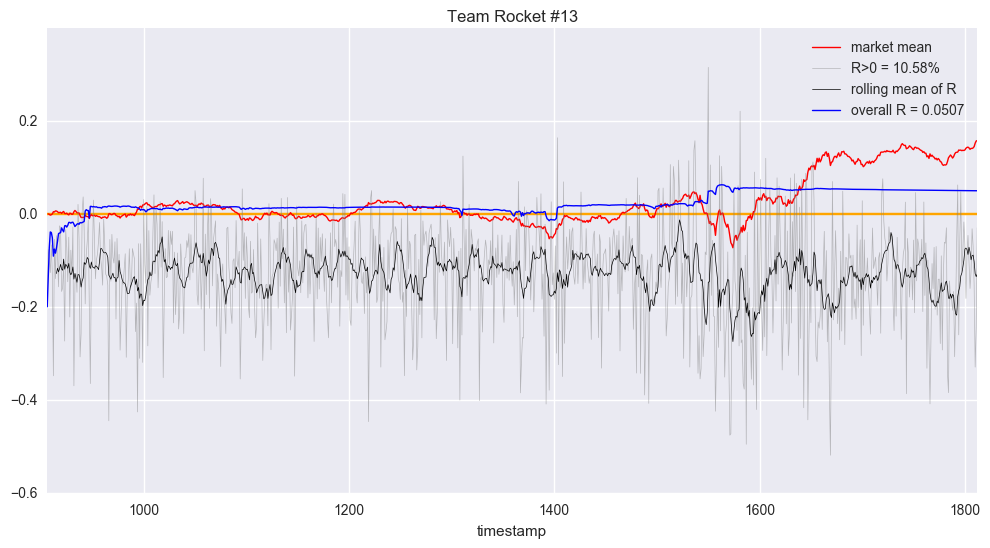

In [13]:
p19.plot()

The plot below reflects the original script which trained XGB on the full train set and therefore was overfit.

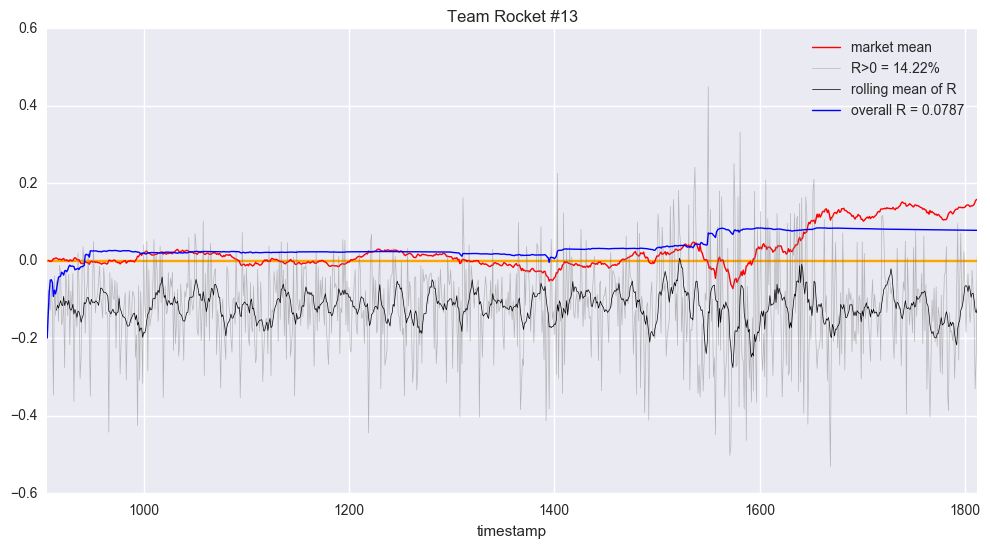

In [18]:
# p18.plot()

## Other documented models

A number of models were published in the forums:
- API: https://www.kaggle.com/ymcdull/two-sigma-financial-modeling/kaggle-gym-api-overview-1/run/483982/
- Mean per id: https://www.kaggle.com/ajoo88/two-sigma-financial-modeling/mean-baseline
- Univariate: https://www.kaggle.com/sudalairajkumar/two-sigma-financial-modeling/univariate-model/
- Univariate Regression: https://www.kaggle.com/sudalairajkumar/two-sigma-financial-modeling/univariate-analysis-regression-lb-0-006
- Univariate with clip: https://www.kaggle.com/bguberfain/two-sigma-financial-modeling/univariate-model-with-clip/
- ET: https://www.kaggle.com/the1owl/two-sigma-financial-modeling/initial-script
- Ridge: https://www.kaggle.com/ymcdull/two-sigma-financial-modeling/ridge-lb-0-0100659/
- ElasticNet: https://www.kaggle.com/sankhamukherjee/two-sigma-financial-modeling/prediction-model-elastic-net/
- XGB: https://www.kaggle.com/anokas/two-sigma-financial-modeling/xgboost-experiment/
- XGB .007: https://www.kaggle.com/jacquespeeters/two-sigma-financial-modeling/xgboost-0-007-lb
- XGB with update: https://www.kaggle.com/tks0123456789/two-sigma-financial-modeling/xgboost-refresh-updater-oob-feature-importance
- RF: https://www.kaggle.com/wangruixin/two-sigma-financial-modeling/randomforestregressor
- RL: https://www.kaggle.com/the1owl/two-sigma-financial-modeling/gaming-it
- GP: https://www.kaggle.com/scirpus/two-sigma-financial-modeling/last-public-gp/code
- TF: https://www.kaggle.com/ma2tg31/two-sigma-financial-modeling/prediction-using-tensorflow
- TF-LR: https://www.kaggle.com/pinocchio/two-sigma-financial-modeling/tensorflow-lr/
- by ID: https://www.kaggle.com/the1owl/two-sigma-financial-modeling/wild-attempts-sparks
- blend: https://www.kaggle.com/the1owl/two-sigma-financial-modeling/blending-high-ranking-public-kernels 0.0102406
- #10 https://www.kaggle.com/phegde/two-sigma-financial-modeling/team-pradeep-arthur-private-lb-10-solution/code
- xgb_500_600_001 https://www.kaggle.com/tks0123456789/two-sigma-financial-modeling/xgb-500-600-001/code
- two-sigma-03 (shorter version) https://www.kaggle.com/happycube/two-sigma-financial-modeling/two-sigma-03-shorter-version/code
- #51 https://www.kaggle.com/happycube/two-sigma-financial-modeling/lightly-annotated-final-submission-13-51/run/976076/notebook
- .202 with two-feature xgb https://www.kaggle.com/happycube/two-sigma-financial-modeling/202-with-two-feature-xgb/run/968991
- https://www.kaggle.com/trentb/two-sigma-financial-modeling/submission-44/code
- #13 https://www.kaggle.com/titericz/two-sigma-financial-modeling/team-rocket-13/code
- XGB Ensamble: https://www.kaggle.com/fernandocanteruccio/two-sigma-financial-modeling/twosigma-gradient-boosting-ensemble-model

